In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img


import math


# from sympy import * 
from utils.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 20  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=50 #"local batch size: B"
    bs=50 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD'
    loss = 'Cross'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

True
cuda


In [3]:
# load dataset and split users

from torchvision import datasets, transforms

if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


In [5]:
N = args.num_users

p_array = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
p_array = np.array([0])

# print(p_matrix)
p_sel = np.random.randint(low=0, high=len(p_array), size=(N,))

p_per_user = np.ones((N,))

for i in range(N):
    p_per_user[i] = p_array[p_sel[i]]

print(p_per_user)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 1. FedAvg (Random Selection)

In [9]:
from models.Nets import NIN,CNN_moderate, CNNCifar3, CNNCifar

p = 0
N = 20
K = 2

N_trials = 1
Max_iter = 30

args.opt = 'SGD'

lr_array = [0.1]

args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

acc_test_arr_random  = np.zeros((len(lr_array),N_trials,Max_iter))
loss_test_arr_random = np.zeros((len(lr_array),N_trials,Max_iter))

P_random = []

for lr_idx in range(len(lr_array)):
    
    for trial_idx in range(N_trials):
        
        args.lr       = lr_array[lr_idx]
        
        net_glob = CNNCifar(args)
        
        net_glob = net_glob.cuda()
        
        print(net_glob)

        net_glob.train()
        
        P_random = []

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4
            
            print('lr=',args.lr)
            
            w_locals, loss_locals = [], []

            ###############################
            # 0. Dropout Realization
            ###############################    
            
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)
            drop_result = np.where(u == 0)

            ###############################
            # 1. Weighted Random Selection
            ###############################

            idxs_users = np.random.choice(result[0], K, replace=False)


            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_random.append(p_tmp)

        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

            #loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_random[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_random[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)

CNNCifar(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
lr= 0.1

Test set: Average loss: 2.2054 
Accuracy: 1839/10000 (18.39%)

Round   0, Train average loss 2.271 Test accuracy 18.390
lr= 0.1

Test set: Average loss: 2.0523 
Accuracy: 2576/10000 (25.76%)

Round   1, Train average loss 2.156 Test accuracy 25.760
lr= 0.1

Test set: Average loss: 1.9440 
Accuracy: 2913/10000 (29.13%)

Round   2, Train average loss 2.045 Test accuracy 29.130
lr= 0.1

Test set: Average loss: 1.8897 
Accuracy: 3053/10000 (30.53%)

Round   3, Train average loss 1.967 Test accuracy 30.530
lr= 0.1

Test set: Average loss: 1.7898 
Accuracy: 3575/10000 (35.75%)

Round   4, Tr

In [38]:
from models.Nets import NIN,CNN_moderate, CNNCifar3

lr_array = [0.1]


args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'

args.local_ep = 1
args.local_bs = 50


acc_test_arr_w_random_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_w_random_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_w_random_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4
                
                
            ###############################
            # 0. Dropout Realization
            ###############################    
            
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]
            
            result = np.where(u == 1)
            drop_result = np.where(u == 0)

            ###############################
            # 1. Weighted Random Selection
            ###############################

            if iter == 0:
                idxs_users = np.random.choice(result[0], K, replace=False)
#                 print('select=',select)
            else:
                P = np.array(P_w_random_asymDrop)
                P_sum = np.sum(P, axis=0).astype(int)
        
                for i in drop_result[0]:
                    P_sum[i] = Max_iter + 1   

                P_sum_sort = P_sum.argsort()

                idxs_users = P_sum_sort[:K]
            

            p_tmp = np.zeros(N)
            p_tmp[idxs_users] = 1

            P_w_random_asymDrop.append(p_tmp)


        #     idxs_users = np.random.choice(range(N), K, replace=False)
            for idx in idxs_users:
        #         print(idx)
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            w_glob = FedAvg(w_locals)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)

    #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_w_random_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_w_random_asymDrop[lr_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.1

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Test set: Average loss: 2.2996 
Accuracy: 1006/10000 (10.06%)

Round   0, Train average loss 2.301 Test accuracy 10.060

Test set: Average loss: 2.2854 
Accuracy: 1375/10000 (13.75%)

Round   1, Train average loss 2.294 Test accuracy 13.750

Test set: Average loss: 2.2322 
Accuracy: 1943/10000 (19.43%)

Round   2, Train average loss 2.265 Test accuracy 19.430

Test set: Average loss: 2.1729 
Accuracy: 2313/10000 (23.13%)

Round   3, Train average loss 2.209 Test accuracy 23.130

Test set: Average loss: 2.1476 
Accuracy: 2071/100


Test set: Average loss: 1.5144 
Accuracy: 5031/10000 (50.31%)

Round  64, Train average loss 1.541 Test accuracy 50.310

Test set: Average loss: 1.5454 
Accuracy: 4879/10000 (48.79%)

Round  65, Train average loss 1.560 Test accuracy 48.790

Test set: Average loss: 1.4773 
Accuracy: 5103/10000 (51.03%)

Round  66, Train average loss 1.541 Test accuracy 51.030

Test set: Average loss: 1.5068 
Accuracy: 5047/10000 (50.47%)

Round  67, Train average loss 1.512 Test accuracy 50.470

Test set: Average loss: 1.5083 
Accuracy: 5157/10000 (51.57%)

Round  68, Train average loss 1.506 Test accuracy 51.570

Test set: Average loss: 1.4802 
Accuracy: 5044/10000 (50.44%)

Round  69, Train average loss 1.534 Test accuracy 50.440

Test set: Average loss: 1.4875 
Accuracy: 5148/10000 (51.48%)

Round  70, Train average loss 1.496 Test accuracy 51.480

Test set: Average loss: 1.4923 
Accuracy: 5103/10000 (51.03%)

Round  71, Train average loss 1.517 Test accuracy 51.030

Test set: Average loss: 1.4978 


Test set: Average loss: 1.3450 
Accuracy: 5469/10000 (54.69%)

Round 132, Train average loss 1.351 Test accuracy 54.690

Test set: Average loss: 1.3524 
Accuracy: 5489/10000 (54.89%)

Round 133, Train average loss 1.351 Test accuracy 54.890

Test set: Average loss: 1.3539 
Accuracy: 5369/10000 (53.69%)

Round 134, Train average loss 1.379 Test accuracy 53.690

Test set: Average loss: 1.3706 
Accuracy: 5286/10000 (52.86%)

Round 135, Train average loss 1.365 Test accuracy 52.860

Test set: Average loss: 1.3542 
Accuracy: 5506/10000 (55.06%)

Round 136, Train average loss 1.351 Test accuracy 55.060

Test set: Average loss: 1.3701 
Accuracy: 5444/10000 (54.44%)

Round 137, Train average loss 1.363 Test accuracy 54.440

Test set: Average loss: 1.3460 
Accuracy: 5517/10000 (55.17%)

Round 138, Train average loss 1.361 Test accuracy 55.170

Test set: Average loss: 1.3366 
Accuracy: 5504/10000 (55.04%)

Round 139, Train average loss 1.338 Test accuracy 55.040

Test set: Average loss: 1.3559 


Test set: Average loss: 1.2636 
Accuracy: 5792/10000 (57.92%)

Round 200, Train average loss 1.270 Test accuracy 57.920

Test set: Average loss: 1.2824 
Accuracy: 5667/10000 (56.67%)

Round 201, Train average loss 1.256 Test accuracy 56.670

Test set: Average loss: 1.2557 
Accuracy: 5814/10000 (58.14%)

Round 202, Train average loss 1.266 Test accuracy 58.140

Test set: Average loss: 1.2653 
Accuracy: 5741/10000 (57.41%)

Round 203, Train average loss 1.245 Test accuracy 57.410

Test set: Average loss: 1.2800 
Accuracy: 5657/10000 (56.57%)

Round 204, Train average loss 1.247 Test accuracy 56.570

Test set: Average loss: 1.2564 
Accuracy: 5639/10000 (56.39%)

Round 205, Train average loss 1.268 Test accuracy 56.390

Test set: Average loss: 1.2772 
Accuracy: 5706/10000 (57.06%)

Round 206, Train average loss 1.286 Test accuracy 57.060

Test set: Average loss: 1.2646 
Accuracy: 5700/10000 (57.00%)

Round 207, Train average loss 1.268 Test accuracy 57.000

Test set: Average loss: 1.2671 


Test set: Average loss: 1.2186 
Accuracy: 5871/10000 (58.71%)

Round 268, Train average loss 1.188 Test accuracy 58.710

Test set: Average loss: 1.1863 
Accuracy: 5897/10000 (58.97%)

Round 269, Train average loss 1.182 Test accuracy 58.970

Test set: Average loss: 1.1894 
Accuracy: 5955/10000 (59.55%)

Round 270, Train average loss 1.143 Test accuracy 59.550

Test set: Average loss: 1.2109 
Accuracy: 5892/10000 (58.92%)

Round 271, Train average loss 1.212 Test accuracy 58.920

Test set: Average loss: 1.2076 
Accuracy: 5802/10000 (58.02%)

Round 272, Train average loss 1.181 Test accuracy 58.020

Test set: Average loss: 1.2020 
Accuracy: 5967/10000 (59.67%)

Round 273, Train average loss 1.176 Test accuracy 59.670

Test set: Average loss: 1.2216 
Accuracy: 5928/10000 (59.28%)

Round 274, Train average loss 1.184 Test accuracy 59.280

Test set: Average loss: 1.1913 
Accuracy: 5881/10000 (58.81%)

Round 275, Train average loss 1.169 Test accuracy 58.810

Test set: Average loss: 1.2338 


Test set: Average loss: 1.1806 
Accuracy: 5986/10000 (59.86%)

Round 336, Train average loss 1.190 Test accuracy 59.860

Test set: Average loss: 1.1898 
Accuracy: 6007/10000 (60.07%)

Round 337, Train average loss 1.138 Test accuracy 60.070

Test set: Average loss: 1.1769 
Accuracy: 5915/10000 (59.15%)

Round 338, Train average loss 1.129 Test accuracy 59.150

Test set: Average loss: 1.1929 
Accuracy: 5922/10000 (59.22%)

Round 339, Train average loss 1.134 Test accuracy 59.220

Test set: Average loss: 1.1833 
Accuracy: 5974/10000 (59.74%)

Round 340, Train average loss 1.164 Test accuracy 59.740

Test set: Average loss: 1.2046 
Accuracy: 5881/10000 (58.81%)

Round 341, Train average loss 1.123 Test accuracy 58.810

Test set: Average loss: 1.1843 
Accuracy: 5940/10000 (59.40%)

Round 342, Train average loss 1.153 Test accuracy 59.400

Test set: Average loss: 1.1753 
Accuracy: 5985/10000 (59.85%)

Round 343, Train average loss 1.176 Test accuracy 59.850

Test set: Average loss: 1.1650 


Test set: Average loss: 1.0972 
Accuracy: 6214/10000 (62.14%)

Round 404, Train average loss 0.991 Test accuracy 62.140

Test set: Average loss: 1.1046 
Accuracy: 6151/10000 (61.51%)

Round 405, Train average loss 1.006 Test accuracy 61.510

Test set: Average loss: 1.0883 
Accuracy: 6245/10000 (62.45%)

Round 406, Train average loss 0.989 Test accuracy 62.450

Test set: Average loss: 1.0981 
Accuracy: 6245/10000 (62.45%)

Round 407, Train average loss 0.992 Test accuracy 62.450

Test set: Average loss: 1.0945 
Accuracy: 6234/10000 (62.34%)

Round 408, Train average loss 0.998 Test accuracy 62.340

Test set: Average loss: 1.0979 
Accuracy: 6206/10000 (62.06%)

Round 409, Train average loss 0.930 Test accuracy 62.060

Test set: Average loss: 1.0966 
Accuracy: 6194/10000 (61.94%)

Round 410, Train average loss 0.975 Test accuracy 61.940

Test set: Average loss: 1.0835 
Accuracy: 6278/10000 (62.78%)

Round 411, Train average loss 0.972 Test accuracy 62.780

Test set: Average loss: 1.0918 


Test set: Average loss: 1.0674 
Accuracy: 6319/10000 (63.19%)

Round 472, Train average loss 0.952 Test accuracy 63.190

Test set: Average loss: 1.0770 
Accuracy: 6270/10000 (62.70%)

Round 473, Train average loss 0.953 Test accuracy 62.700

Test set: Average loss: 1.0737 
Accuracy: 6297/10000 (62.97%)

Round 474, Train average loss 0.987 Test accuracy 62.970

Test set: Average loss: 1.0725 
Accuracy: 6272/10000 (62.72%)

Round 475, Train average loss 0.964 Test accuracy 62.720

Test set: Average loss: 1.0687 
Accuracy: 6297/10000 (62.97%)

Round 476, Train average loss 0.964 Test accuracy 62.970

Test set: Average loss: 1.0756 
Accuracy: 6263/10000 (62.63%)

Round 477, Train average loss 0.957 Test accuracy 62.630

Test set: Average loss: 1.0654 
Accuracy: 6319/10000 (63.19%)

Round 478, Train average loss 0.933 Test accuracy 63.190

Test set: Average loss: 1.0664 
Accuracy: 6309/10000 (63.09%)

Round 479, Train average loss 0.944 Test accuracy 63.090

Test set: Average loss: 1.0761 


Test set: Average loss: 1.0637 
Accuracy: 6328/10000 (63.28%)

Round 540, Train average loss 0.915 Test accuracy 63.280

Test set: Average loss: 1.0654 
Accuracy: 6314/10000 (63.14%)

Round 541, Train average loss 0.956 Test accuracy 63.140

Test set: Average loss: 1.0645 
Accuracy: 6342/10000 (63.42%)

Round 542, Train average loss 0.940 Test accuracy 63.420

Test set: Average loss: 1.0587 
Accuracy: 6354/10000 (63.54%)

Round 543, Train average loss 0.939 Test accuracy 63.540

Test set: Average loss: 1.0805 
Accuracy: 6279/10000 (62.79%)

Round 544, Train average loss 0.948 Test accuracy 62.790

Test set: Average loss: 1.0550 
Accuracy: 6364/10000 (63.64%)

Round 545, Train average loss 0.918 Test accuracy 63.640

Test set: Average loss: 1.0659 
Accuracy: 6346/10000 (63.46%)

Round 546, Train average loss 0.930 Test accuracy 63.460

Test set: Average loss: 1.0689 
Accuracy: 6351/10000 (63.51%)

Round 547, Train average loss 0.909 Test accuracy 63.510

Test set: Average loss: 1.0543 


Test set: Average loss: 1.0649 
Accuracy: 6377/10000 (63.77%)

Round 608, Train average loss 0.901 Test accuracy 63.770

Test set: Average loss: 1.0566 
Accuracy: 6343/10000 (63.43%)

Round 609, Train average loss 0.903 Test accuracy 63.430

Test set: Average loss: 1.0609 
Accuracy: 6339/10000 (63.39%)

Round 610, Train average loss 0.902 Test accuracy 63.390

Test set: Average loss: 1.0663 
Accuracy: 6365/10000 (63.65%)

Round 611, Train average loss 0.931 Test accuracy 63.650

Test set: Average loss: 1.0423 
Accuracy: 6420/10000 (64.20%)

Round 612, Train average loss 0.906 Test accuracy 64.200

Test set: Average loss: 1.0573 
Accuracy: 6363/10000 (63.63%)

Round 613, Train average loss 0.899 Test accuracy 63.630

Test set: Average loss: 1.0501 
Accuracy: 6370/10000 (63.70%)

Round 614, Train average loss 0.919 Test accuracy 63.700

Test set: Average loss: 1.0505 
Accuracy: 6353/10000 (63.53%)

Round 615, Train average loss 0.901 Test accuracy 63.530

Test set: Average loss: 1.0747 


Test set: Average loss: 1.0423 
Accuracy: 6424/10000 (64.24%)

Round 676, Train average loss 0.873 Test accuracy 64.240

Test set: Average loss: 1.0531 
Accuracy: 6354/10000 (63.54%)

Round 677, Train average loss 0.913 Test accuracy 63.540

Test set: Average loss: 1.0581 
Accuracy: 6385/10000 (63.85%)

Round 678, Train average loss 0.920 Test accuracy 63.850

Test set: Average loss: 1.0572 
Accuracy: 6356/10000 (63.56%)

Round 679, Train average loss 0.896 Test accuracy 63.560

Test set: Average loss: 1.0572 
Accuracy: 6335/10000 (63.35%)

Round 680, Train average loss 0.912 Test accuracy 63.350

Test set: Average loss: 1.0634 
Accuracy: 6340/10000 (63.40%)

Round 681, Train average loss 0.922 Test accuracy 63.400

Test set: Average loss: 1.0383 
Accuracy: 6426/10000 (64.26%)

Round 682, Train average loss 0.896 Test accuracy 64.260

Test set: Average loss: 1.0454 
Accuracy: 6384/10000 (63.84%)

Round 683, Train average loss 0.897 Test accuracy 63.840

Test set: Average loss: 1.0523 


Test set: Average loss: 1.0553 
Accuracy: 6365/10000 (63.65%)

Round 744, Train average loss 0.899 Test accuracy 63.650

Test set: Average loss: 1.0420 
Accuracy: 6429/10000 (64.29%)

Round 745, Train average loss 0.896 Test accuracy 64.290

Test set: Average loss: 1.0518 
Accuracy: 6403/10000 (64.03%)

Round 746, Train average loss 0.910 Test accuracy 64.030

Test set: Average loss: 1.0531 
Accuracy: 6407/10000 (64.07%)

Round 747, Train average loss 0.894 Test accuracy 64.070

Test set: Average loss: 1.0456 
Accuracy: 6391/10000 (63.91%)

Round 748, Train average loss 0.883 Test accuracy 63.910

Test set: Average loss: 1.0401 
Accuracy: 6414/10000 (64.14%)

Round 749, Train average loss 0.855 Test accuracy 64.140

Test set: Average loss: 1.0580 
Accuracy: 6401/10000 (64.01%)

Round 750, Train average loss 0.904 Test accuracy 64.010

Test set: Average loss: 1.0462 
Accuracy: 6395/10000 (63.95%)

Round 751, Train average loss 0.912 Test accuracy 63.950

Test set: Average loss: 1.0385 


Test set: Average loss: 1.0264 
Accuracy: 6449/10000 (64.49%)

Round 812, Train average loss 0.847 Test accuracy 64.490

Test set: Average loss: 1.0298 
Accuracy: 6462/10000 (64.62%)

Round 813, Train average loss 0.829 Test accuracy 64.620

Test set: Average loss: 1.0234 
Accuracy: 6453/10000 (64.53%)

Round 814, Train average loss 0.814 Test accuracy 64.530

Test set: Average loss: 1.0227 
Accuracy: 6463/10000 (64.63%)

Round 815, Train average loss 0.823 Test accuracy 64.630

Test set: Average loss: 1.0285 
Accuracy: 6453/10000 (64.53%)

Round 816, Train average loss 0.822 Test accuracy 64.530

Test set: Average loss: 1.0208 
Accuracy: 6466/10000 (64.66%)

Round 817, Train average loss 0.826 Test accuracy 64.660

Test set: Average loss: 1.0223 
Accuracy: 6497/10000 (64.97%)

Round 818, Train average loss 0.842 Test accuracy 64.970

Test set: Average loss: 1.0210 
Accuracy: 6471/10000 (64.71%)

Round 819, Train average loss 0.816 Test accuracy 64.710

Test set: Average loss: 1.0240 


Test set: Average loss: 1.0226 
Accuracy: 6474/10000 (64.74%)

Round 880, Train average loss 0.825 Test accuracy 64.740

Test set: Average loss: 1.0152 
Accuracy: 6500/10000 (65.00%)

Round 881, Train average loss 0.839 Test accuracy 65.000

Test set: Average loss: 1.0191 
Accuracy: 6498/10000 (64.98%)

Round 882, Train average loss 0.801 Test accuracy 64.980

Test set: Average loss: 1.0229 
Accuracy: 6501/10000 (65.01%)

Round 883, Train average loss 0.812 Test accuracy 65.010

Test set: Average loss: 1.0209 
Accuracy: 6502/10000 (65.02%)

Round 884, Train average loss 0.804 Test accuracy 65.020

Test set: Average loss: 1.0233 
Accuracy: 6493/10000 (64.93%)

Round 885, Train average loss 0.817 Test accuracy 64.930

Test set: Average loss: 1.0132 
Accuracy: 6502/10000 (65.02%)

Round 886, Train average loss 0.834 Test accuracy 65.020

Test set: Average loss: 1.0221 
Accuracy: 6492/10000 (64.92%)

Round 887, Train average loss 0.817 Test accuracy 64.920

Test set: Average loss: 1.0279 


Test set: Average loss: 1.0193 
Accuracy: 6507/10000 (65.07%)

Round 948, Train average loss 0.813 Test accuracy 65.070

Test set: Average loss: 1.0168 
Accuracy: 6537/10000 (65.37%)

Round 949, Train average loss 0.792 Test accuracy 65.370

Test set: Average loss: 1.0151 
Accuracy: 6512/10000 (65.12%)

Round 950, Train average loss 0.810 Test accuracy 65.120

Test set: Average loss: 1.0161 
Accuracy: 6500/10000 (65.00%)

Round 951, Train average loss 0.822 Test accuracy 65.000

Test set: Average loss: 1.0241 
Accuracy: 6474/10000 (64.74%)

Round 952, Train average loss 0.799 Test accuracy 64.740

Test set: Average loss: 1.0208 
Accuracy: 6505/10000 (65.05%)

Round 953, Train average loss 0.804 Test accuracy 65.050

Test set: Average loss: 1.0130 
Accuracy: 6521/10000 (65.21%)

Round 954, Train average loss 0.815 Test accuracy 65.210

Test set: Average loss: 1.0179 
Accuracy: 6492/10000 (64.92%)

Round 955, Train average loss 0.811 Test accuracy 64.920

Test set: Average loss: 1.0141 


Test set: Average loss: 1.9736 
Accuracy: 3412/10000 (34.12%)

Round  12, Train average loss 1.952 Test accuracy 34.120

Test set: Average loss: 1.9470 
Accuracy: 3577/10000 (35.77%)

Round  13, Train average loss 1.948 Test accuracy 35.770

Test set: Average loss: 1.9134 
Accuracy: 3818/10000 (38.18%)

Round  14, Train average loss 1.925 Test accuracy 38.180

Test set: Average loss: 1.8799 
Accuracy: 3740/10000 (37.40%)

Round  15, Train average loss 1.897 Test accuracy 37.400

Test set: Average loss: 1.8903 
Accuracy: 3888/10000 (38.88%)

Round  16, Train average loss 1.896 Test accuracy 38.880

Test set: Average loss: 1.8900 
Accuracy: 3835/10000 (38.35%)

Round  17, Train average loss 1.872 Test accuracy 38.350

Test set: Average loss: 1.8561 
Accuracy: 4055/10000 (40.55%)

Round  18, Train average loss 1.873 Test accuracy 40.550

Test set: Average loss: 1.8853 
Accuracy: 3928/10000 (39.28%)

Round  19, Train average loss 1.852 Test accuracy 39.280

Test set: Average loss: 1.8701 


Test set: Average loss: 1.4858 
Accuracy: 4984/10000 (49.84%)

Round  80, Train average loss 1.521 Test accuracy 49.840

Test set: Average loss: 1.4609 
Accuracy: 5131/10000 (51.31%)

Round  81, Train average loss 1.480 Test accuracy 51.310

Test set: Average loss: 1.4618 
Accuracy: 5084/10000 (50.84%)

Round  82, Train average loss 1.485 Test accuracy 50.840

Test set: Average loss: 1.4724 
Accuracy: 5096/10000 (50.96%)

Round  83, Train average loss 1.463 Test accuracy 50.960

Test set: Average loss: 1.4696 
Accuracy: 5016/10000 (50.16%)

Round  84, Train average loss 1.477 Test accuracy 50.160

Test set: Average loss: 1.4867 
Accuracy: 4929/10000 (49.29%)

Round  85, Train average loss 1.460 Test accuracy 49.290

Test set: Average loss: 1.4884 
Accuracy: 4912/10000 (49.12%)

Round  86, Train average loss 1.510 Test accuracy 49.120

Test set: Average loss: 1.4438 
Accuracy: 5149/10000 (51.49%)

Round  87, Train average loss 1.462 Test accuracy 51.490

Test set: Average loss: 1.4469 


Test set: Average loss: 1.3166 
Accuracy: 5556/10000 (55.56%)

Round 148, Train average loss 1.325 Test accuracy 55.560

Test set: Average loss: 1.3342 
Accuracy: 5459/10000 (54.59%)

Round 149, Train average loss 1.320 Test accuracy 54.590

Test set: Average loss: 1.3280 
Accuracy: 5422/10000 (54.22%)

Round 150, Train average loss 1.331 Test accuracy 54.220

Test set: Average loss: 1.3332 
Accuracy: 5537/10000 (55.37%)

Round 151, Train average loss 1.352 Test accuracy 55.370

Test set: Average loss: 1.3001 
Accuracy: 5629/10000 (56.29%)

Round 152, Train average loss 1.317 Test accuracy 56.290

Test set: Average loss: 1.2964 
Accuracy: 5512/10000 (55.12%)

Round 153, Train average loss 1.293 Test accuracy 55.120

Test set: Average loss: 1.3447 
Accuracy: 5513/10000 (55.13%)

Round 154, Train average loss 1.363 Test accuracy 55.130

Test set: Average loss: 1.3294 
Accuracy: 5487/10000 (54.87%)

Round 155, Train average loss 1.340 Test accuracy 54.870

Test set: Average loss: 1.3028 


Test set: Average loss: 1.2463 
Accuracy: 5782/10000 (57.82%)

Round 216, Train average loss 1.251 Test accuracy 57.820

Test set: Average loss: 1.2862 
Accuracy: 5585/10000 (55.85%)

Round 217, Train average loss 1.256 Test accuracy 55.850

Test set: Average loss: 1.2506 
Accuracy: 5834/10000 (58.34%)

Round 218, Train average loss 1.235 Test accuracy 58.340

Test set: Average loss: 1.2398 
Accuracy: 5781/10000 (57.81%)

Round 219, Train average loss 1.201 Test accuracy 57.810

Test set: Average loss: 1.2615 
Accuracy: 5766/10000 (57.66%)

Round 220, Train average loss 1.254 Test accuracy 57.660

Test set: Average loss: 1.2437 
Accuracy: 5706/10000 (57.06%)

Round 221, Train average loss 1.244 Test accuracy 57.060

Test set: Average loss: 1.2246 
Accuracy: 5813/10000 (58.13%)

Round 222, Train average loss 1.236 Test accuracy 58.130

Test set: Average loss: 1.2463 
Accuracy: 5768/10000 (57.68%)

Round 223, Train average loss 1.223 Test accuracy 57.680

Test set: Average loss: 1.2621 


Test set: Average loss: 1.2186 
Accuracy: 5895/10000 (58.95%)

Round 284, Train average loss 1.170 Test accuracy 58.950

Test set: Average loss: 1.2182 
Accuracy: 5945/10000 (59.45%)

Round 285, Train average loss 1.195 Test accuracy 59.450

Test set: Average loss: 1.1755 
Accuracy: 5996/10000 (59.96%)

Round 286, Train average loss 1.167 Test accuracy 59.960

Test set: Average loss: 1.1719 
Accuracy: 6069/10000 (60.69%)

Round 287, Train average loss 1.154 Test accuracy 60.690

Test set: Average loss: 1.1952 
Accuracy: 5963/10000 (59.63%)

Round 288, Train average loss 1.173 Test accuracy 59.630

Test set: Average loss: 1.1823 
Accuracy: 6020/10000 (60.20%)

Round 289, Train average loss 1.168 Test accuracy 60.200

Test set: Average loss: 1.1706 
Accuracy: 6053/10000 (60.53%)

Round 290, Train average loss 1.145 Test accuracy 60.530

Test set: Average loss: 1.1934 
Accuracy: 5997/10000 (59.97%)

Round 291, Train average loss 1.167 Test accuracy 59.970

Test set: Average loss: 1.1641 


Test set: Average loss: 1.1439 
Accuracy: 6080/10000 (60.80%)

Round 352, Train average loss 1.105 Test accuracy 60.800

Test set: Average loss: 1.1384 
Accuracy: 6065/10000 (60.65%)

Round 353, Train average loss 1.106 Test accuracy 60.650

Test set: Average loss: 1.1741 
Accuracy: 5967/10000 (59.67%)

Round 354, Train average loss 1.151 Test accuracy 59.670

Test set: Average loss: 1.1605 
Accuracy: 6056/10000 (60.56%)

Round 355, Train average loss 1.123 Test accuracy 60.560

Test set: Average loss: 1.1614 
Accuracy: 6067/10000 (60.67%)

Round 356, Train average loss 1.156 Test accuracy 60.670

Test set: Average loss: 1.1487 
Accuracy: 6092/10000 (60.92%)

Round 357, Train average loss 1.111 Test accuracy 60.920

Test set: Average loss: 1.1595 
Accuracy: 5998/10000 (59.98%)

Round 358, Train average loss 1.118 Test accuracy 59.980

Test set: Average loss: 1.1496 
Accuracy: 6071/10000 (60.71%)

Round 359, Train average loss 1.161 Test accuracy 60.710

Test set: Average loss: 1.1539 


Test set: Average loss: 1.0707 
Accuracy: 6308/10000 (63.08%)

Round 420, Train average loss 0.975 Test accuracy 63.080

Test set: Average loss: 1.0616 
Accuracy: 6380/10000 (63.80%)

Round 421, Train average loss 0.927 Test accuracy 63.800

Test set: Average loss: 1.0687 
Accuracy: 6333/10000 (63.33%)

Round 422, Train average loss 0.937 Test accuracy 63.330

Test set: Average loss: 1.0688 
Accuracy: 6317/10000 (63.17%)

Round 423, Train average loss 0.958 Test accuracy 63.170

Test set: Average loss: 1.0773 
Accuracy: 6320/10000 (63.20%)

Round 424, Train average loss 0.946 Test accuracy 63.200

Test set: Average loss: 1.0834 
Accuracy: 6281/10000 (62.81%)

Round 425, Train average loss 0.992 Test accuracy 62.810

Test set: Average loss: 1.0682 
Accuracy: 6360/10000 (63.60%)

Round 426, Train average loss 0.939 Test accuracy 63.600

Test set: Average loss: 1.0656 
Accuracy: 6347/10000 (63.47%)

Round 427, Train average loss 0.943 Test accuracy 63.470

Test set: Average loss: 1.0717 


Test set: Average loss: 1.0570 
Accuracy: 6385/10000 (63.85%)

Round 488, Train average loss 0.900 Test accuracy 63.850

Test set: Average loss: 1.0561 
Accuracy: 6374/10000 (63.74%)

Round 489, Train average loss 0.946 Test accuracy 63.740

Test set: Average loss: 1.0472 
Accuracy: 6430/10000 (64.30%)

Round 490, Train average loss 0.912 Test accuracy 64.300

Test set: Average loss: 1.0620 
Accuracy: 6352/10000 (63.52%)

Round 491, Train average loss 0.947 Test accuracy 63.520

Test set: Average loss: 1.0513 
Accuracy: 6416/10000 (64.16%)

Round 492, Train average loss 0.937 Test accuracy 64.160

Test set: Average loss: 1.0521 
Accuracy: 6364/10000 (63.64%)

Round 493, Train average loss 0.929 Test accuracy 63.640

Test set: Average loss: 1.0607 
Accuracy: 6336/10000 (63.36%)

Round 494, Train average loss 0.923 Test accuracy 63.360

Test set: Average loss: 1.0547 
Accuracy: 6375/10000 (63.75%)

Round 495, Train average loss 0.913 Test accuracy 63.750

Test set: Average loss: 1.0644 


Test set: Average loss: 1.0508 
Accuracy: 6395/10000 (63.95%)

Round 556, Train average loss 0.903 Test accuracy 63.950

Test set: Average loss: 1.0387 
Accuracy: 6417/10000 (64.17%)

Round 557, Train average loss 0.902 Test accuracy 64.170

Test set: Average loss: 1.0493 
Accuracy: 6338/10000 (63.38%)

Round 558, Train average loss 0.907 Test accuracy 63.380

Test set: Average loss: 1.0383 
Accuracy: 6403/10000 (64.03%)

Round 559, Train average loss 0.882 Test accuracy 64.030

Test set: Average loss: 1.0548 
Accuracy: 6394/10000 (63.94%)

Round 560, Train average loss 0.913 Test accuracy 63.940

Test set: Average loss: 1.0511 
Accuracy: 6398/10000 (63.98%)

Round 561, Train average loss 0.960 Test accuracy 63.980

Test set: Average loss: 1.0382 
Accuracy: 6404/10000 (64.04%)

Round 562, Train average loss 0.880 Test accuracy 64.040

Test set: Average loss: 1.0544 
Accuracy: 6384/10000 (63.84%)

Round 563, Train average loss 0.936 Test accuracy 63.840

Test set: Average loss: 1.0487 


Test set: Average loss: 1.0543 
Accuracy: 6391/10000 (63.91%)

Round 624, Train average loss 0.883 Test accuracy 63.910

Test set: Average loss: 1.0361 
Accuracy: 6415/10000 (64.15%)

Round 625, Train average loss 0.926 Test accuracy 64.150

Test set: Average loss: 1.0426 
Accuracy: 6412/10000 (64.12%)

Round 626, Train average loss 0.920 Test accuracy 64.120

Test set: Average loss: 1.0454 
Accuracy: 6406/10000 (64.06%)

Round 627, Train average loss 0.885 Test accuracy 64.060

Test set: Average loss: 1.0446 
Accuracy: 6398/10000 (63.98%)

Round 628, Train average loss 0.903 Test accuracy 63.980

Test set: Average loss: 1.0466 
Accuracy: 6421/10000 (64.21%)

Round 629, Train average loss 0.874 Test accuracy 64.210

Test set: Average loss: 1.0424 
Accuracy: 6427/10000 (64.27%)

Round 630, Train average loss 0.896 Test accuracy 64.270

Test set: Average loss: 1.0379 
Accuracy: 6415/10000 (64.15%)

Round 631, Train average loss 0.923 Test accuracy 64.150

Test set: Average loss: 1.0377 


Test set: Average loss: 1.0355 
Accuracy: 6430/10000 (64.30%)

Round 692, Train average loss 0.897 Test accuracy 64.300

Test set: Average loss: 1.0423 
Accuracy: 6440/10000 (64.40%)

Round 693, Train average loss 0.915 Test accuracy 64.400

Test set: Average loss: 1.0435 
Accuracy: 6406/10000 (64.06%)

Round 694, Train average loss 0.874 Test accuracy 64.060

Test set: Average loss: 1.0429 
Accuracy: 6426/10000 (64.26%)

Round 695, Train average loss 0.864 Test accuracy 64.260

Test set: Average loss: 1.0523 
Accuracy: 6373/10000 (63.73%)

Round 696, Train average loss 0.880 Test accuracy 63.730

Test set: Average loss: 1.0352 
Accuracy: 6433/10000 (64.33%)

Round 697, Train average loss 0.883 Test accuracy 64.330

Test set: Average loss: 1.0338 
Accuracy: 6386/10000 (63.86%)

Round 698, Train average loss 0.868 Test accuracy 63.860

Test set: Average loss: 1.0306 
Accuracy: 6423/10000 (64.23%)

Round 699, Train average loss 0.874 Test accuracy 64.230

Test set: Average loss: 1.0277 


Test set: Average loss: 1.0408 
Accuracy: 6442/10000 (64.42%)

Round 760, Train average loss 0.880 Test accuracy 64.420

Test set: Average loss: 1.0293 
Accuracy: 6440/10000 (64.40%)

Round 761, Train average loss 0.880 Test accuracy 64.400

Test set: Average loss: 1.0365 
Accuracy: 6406/10000 (64.06%)

Round 762, Train average loss 0.863 Test accuracy 64.060

Test set: Average loss: 1.0259 
Accuracy: 6465/10000 (64.65%)

Round 763, Train average loss 0.866 Test accuracy 64.650

Test set: Average loss: 1.0317 
Accuracy: 6475/10000 (64.75%)

Round 764, Train average loss 0.860 Test accuracy 64.750

Test set: Average loss: 1.0158 
Accuracy: 6451/10000 (64.51%)

Round 765, Train average loss 0.863 Test accuracy 64.510

Test set: Average loss: 1.0249 
Accuracy: 6474/10000 (64.74%)

Round 766, Train average loss 0.859 Test accuracy 64.740

Test set: Average loss: 1.0234 
Accuracy: 6476/10000 (64.76%)

Round 767, Train average loss 0.876 Test accuracy 64.760

Test set: Average loss: 1.0273 


Test set: Average loss: 1.0144 
Accuracy: 6512/10000 (65.12%)

Round 828, Train average loss 0.818 Test accuracy 65.120

Test set: Average loss: 1.0114 
Accuracy: 6520/10000 (65.20%)

Round 829, Train average loss 0.787 Test accuracy 65.200

Test set: Average loss: 1.0163 
Accuracy: 6491/10000 (64.91%)

Round 830, Train average loss 0.811 Test accuracy 64.910

Test set: Average loss: 1.0225 
Accuracy: 6504/10000 (65.04%)

Round 831, Train average loss 0.826 Test accuracy 65.040

Test set: Average loss: 1.0132 
Accuracy: 6558/10000 (65.58%)

Round 832, Train average loss 0.801 Test accuracy 65.580

Test set: Average loss: 1.0200 
Accuracy: 6500/10000 (65.00%)

Round 833, Train average loss 0.764 Test accuracy 65.000

Test set: Average loss: 1.0169 
Accuracy: 6537/10000 (65.37%)

Round 834, Train average loss 0.811 Test accuracy 65.370

Test set: Average loss: 1.0062 
Accuracy: 6554/10000 (65.54%)

Round 835, Train average loss 0.824 Test accuracy 65.540

Test set: Average loss: 1.0125 


Test set: Average loss: 1.0109 
Accuracy: 6550/10000 (65.50%)

Round 896, Train average loss 0.788 Test accuracy 65.500

Test set: Average loss: 1.0208 
Accuracy: 6486/10000 (64.86%)

Round 897, Train average loss 0.781 Test accuracy 64.860

Test set: Average loss: 1.0068 
Accuracy: 6543/10000 (65.43%)

Round 898, Train average loss 0.763 Test accuracy 65.430

Test set: Average loss: 1.0091 
Accuracy: 6501/10000 (65.01%)

Round 899, Train average loss 0.811 Test accuracy 65.010

Test set: Average loss: 1.0040 
Accuracy: 6561/10000 (65.61%)

Round 900, Train average loss 0.778 Test accuracy 65.610

Test set: Average loss: 1.0123 
Accuracy: 6538/10000 (65.38%)

Round 901, Train average loss 0.796 Test accuracy 65.380

Test set: Average loss: 1.0238 
Accuracy: 6494/10000 (64.94%)

Round 902, Train average loss 0.790 Test accuracy 64.940

Test set: Average loss: 1.0069 
Accuracy: 6538/10000 (65.38%)

Round 903, Train average loss 0.800 Test accuracy 65.380

Test set: Average loss: 1.0079 


Test set: Average loss: 1.0053 
Accuracy: 6546/10000 (65.46%)

Round 964, Train average loss 0.791 Test accuracy 65.460

Test set: Average loss: 1.0245 
Accuracy: 6474/10000 (64.74%)

Round 965, Train average loss 0.791 Test accuracy 64.740

Test set: Average loss: 1.0109 
Accuracy: 6534/10000 (65.34%)

Round 966, Train average loss 0.793 Test accuracy 65.340

Test set: Average loss: 1.0096 
Accuracy: 6552/10000 (65.52%)

Round 967, Train average loss 0.774 Test accuracy 65.520

Test set: Average loss: 1.0083 
Accuracy: 6554/10000 (65.54%)

Round 968, Train average loss 0.756 Test accuracy 65.540

Test set: Average loss: 1.0114 
Accuracy: 6542/10000 (65.42%)

Round 969, Train average loss 0.779 Test accuracy 65.420

Test set: Average loss: 1.0082 
Accuracy: 6529/10000 (65.29%)

Round 970, Train average loss 0.794 Test accuracy 65.290

Test set: Average loss: 1.0155 
Accuracy: 6541/10000 (65.41%)

Round 971, Train average loss 0.784 Test accuracy 65.410

Test set: Average loss: 1.0072 


Test set: Average loss: 1.7317 
Accuracy: 4320/10000 (43.20%)

Round  28, Train average loss 1.740 Test accuracy 43.200

Test set: Average loss: 1.7040 
Accuracy: 4318/10000 (43.18%)

Round  29, Train average loss 1.743 Test accuracy 43.180

Test set: Average loss: 1.7889 
Accuracy: 4305/10000 (43.05%)

Round  30, Train average loss 1.743 Test accuracy 43.050

Test set: Average loss: 1.7439 
Accuracy: 4356/10000 (43.56%)

Round  31, Train average loss 1.724 Test accuracy 43.560

Test set: Average loss: 1.6866 
Accuracy: 4452/10000 (44.52%)

Round  32, Train average loss 1.713 Test accuracy 44.520

Test set: Average loss: 1.6737 
Accuracy: 4436/10000 (44.36%)

Round  33, Train average loss 1.705 Test accuracy 44.360

Test set: Average loss: 1.7109 
Accuracy: 4418/10000 (44.18%)

Round  34, Train average loss 1.703 Test accuracy 44.180

Test set: Average loss: 1.6721 
Accuracy: 4416/10000 (44.16%)

Round  35, Train average loss 1.710 Test accuracy 44.160

Test set: Average loss: 1.6971 


Test set: Average loss: 1.4308 
Accuracy: 5166/10000 (51.66%)

Round  96, Train average loss 1.451 Test accuracy 51.660

Test set: Average loss: 1.4626 
Accuracy: 5091/10000 (50.91%)

Round  97, Train average loss 1.457 Test accuracy 50.910

Test set: Average loss: 1.4101 
Accuracy: 5297/10000 (52.97%)

Round  98, Train average loss 1.467 Test accuracy 52.970

Test set: Average loss: 1.4308 
Accuracy: 5178/10000 (51.78%)

Round  99, Train average loss 1.441 Test accuracy 51.780

Test set: Average loss: 1.4246 
Accuracy: 5206/10000 (52.06%)

Round 100, Train average loss 1.449 Test accuracy 52.060

Test set: Average loss: 1.4404 
Accuracy: 5073/10000 (50.73%)

Round 101, Train average loss 1.443 Test accuracy 50.730

Test set: Average loss: 1.4266 
Accuracy: 5165/10000 (51.65%)

Round 102, Train average loss 1.442 Test accuracy 51.650

Test set: Average loss: 1.4135 
Accuracy: 5200/10000 (52.00%)

Round 103, Train average loss 1.432 Test accuracy 52.000

Test set: Average loss: 1.4618 


Test set: Average loss: 1.3110 
Accuracy: 5539/10000 (55.39%)

Round 164, Train average loss 1.314 Test accuracy 55.390

Test set: Average loss: 1.3547 
Accuracy: 5471/10000 (54.71%)

Round 165, Train average loss 1.315 Test accuracy 54.710

Test set: Average loss: 1.3039 
Accuracy: 5608/10000 (56.08%)

Round 166, Train average loss 1.335 Test accuracy 56.080

Test set: Average loss: 1.2916 
Accuracy: 5593/10000 (55.93%)

Round 167, Train average loss 1.304 Test accuracy 55.930

Test set: Average loss: 1.2843 
Accuracy: 5655/10000 (56.55%)

Round 168, Train average loss 1.278 Test accuracy 56.550

Test set: Average loss: 1.3086 
Accuracy: 5559/10000 (55.59%)

Round 169, Train average loss 1.333 Test accuracy 55.590

Test set: Average loss: 1.2952 
Accuracy: 5555/10000 (55.55%)

Round 170, Train average loss 1.303 Test accuracy 55.550

Test set: Average loss: 1.3437 
Accuracy: 5543/10000 (55.43%)

Round 171, Train average loss 1.301 Test accuracy 55.430

Test set: Average loss: 1.3110 


Test set: Average loss: 1.2230 
Accuracy: 5832/10000 (58.32%)

Round 232, Train average loss 1.192 Test accuracy 58.320

Test set: Average loss: 1.2646 
Accuracy: 5676/10000 (56.76%)

Round 233, Train average loss 1.233 Test accuracy 56.760

Test set: Average loss: 1.2369 
Accuracy: 5759/10000 (57.59%)

Round 234, Train average loss 1.240 Test accuracy 57.590

Test set: Average loss: 1.2591 
Accuracy: 5760/10000 (57.60%)

Round 235, Train average loss 1.260 Test accuracy 57.600

Test set: Average loss: 1.2413 
Accuracy: 5823/10000 (58.23%)

Round 236, Train average loss 1.222 Test accuracy 58.230

Test set: Average loss: 1.2177 
Accuracy: 5848/10000 (58.48%)

Round 237, Train average loss 1.218 Test accuracy 58.480

Test set: Average loss: 1.2116 
Accuracy: 5855/10000 (58.55%)

Round 238, Train average loss 1.182 Test accuracy 58.550

Test set: Average loss: 1.2265 
Accuracy: 5770/10000 (57.70%)

Round 239, Train average loss 1.200 Test accuracy 57.700

Test set: Average loss: 1.2633 


Test set: Average loss: 1.2221 
Accuracy: 5843/10000 (58.43%)

Round 300, Train average loss 1.196 Test accuracy 58.430

Test set: Average loss: 1.1822 
Accuracy: 5989/10000 (59.89%)

Round 301, Train average loss 1.154 Test accuracy 59.890

Test set: Average loss: 1.1774 
Accuracy: 5934/10000 (59.34%)

Round 302, Train average loss 1.165 Test accuracy 59.340

Test set: Average loss: 1.1820 
Accuracy: 5951/10000 (59.51%)

Round 303, Train average loss 1.142 Test accuracy 59.510

Test set: Average loss: 1.1807 
Accuracy: 5977/10000 (59.77%)

Round 304, Train average loss 1.138 Test accuracy 59.770

Test set: Average loss: 1.1771 
Accuracy: 5956/10000 (59.56%)

Round 305, Train average loss 1.148 Test accuracy 59.560

Test set: Average loss: 1.1801 
Accuracy: 6002/10000 (60.02%)

Round 306, Train average loss 1.159 Test accuracy 60.020

Test set: Average loss: 1.1963 
Accuracy: 5914/10000 (59.14%)

Round 307, Train average loss 1.159 Test accuracy 59.140

Test set: Average loss: 1.1586 


Test set: Average loss: 1.1693 
Accuracy: 5998/10000 (59.98%)

Round 368, Train average loss 1.125 Test accuracy 59.980

Test set: Average loss: 1.1208 
Accuracy: 6158/10000 (61.58%)

Round 369, Train average loss 1.079 Test accuracy 61.580

Test set: Average loss: 1.1389 
Accuracy: 6036/10000 (60.36%)

Round 370, Train average loss 1.105 Test accuracy 60.360

Test set: Average loss: 1.1654 
Accuracy: 6053/10000 (60.53%)

Round 371, Train average loss 1.128 Test accuracy 60.530

Test set: Average loss: 1.1804 
Accuracy: 5873/10000 (58.73%)

Round 372, Train average loss 1.134 Test accuracy 58.730

Test set: Average loss: 1.1723 
Accuracy: 6034/10000 (60.34%)

Round 373, Train average loss 1.132 Test accuracy 60.340

Test set: Average loss: 1.1659 
Accuracy: 6033/10000 (60.33%)

Round 374, Train average loss 1.141 Test accuracy 60.330

Test set: Average loss: 1.1499 
Accuracy: 6009/10000 (60.09%)

Round 375, Train average loss 1.094 Test accuracy 60.090

Test set: Average loss: 1.1549 


Test set: Average loss: 1.0799 
Accuracy: 6245/10000 (62.45%)

Round 436, Train average loss 0.966 Test accuracy 62.450

Test set: Average loss: 1.0771 
Accuracy: 6290/10000 (62.90%)

Round 437, Train average loss 0.959 Test accuracy 62.900

Test set: Average loss: 1.0660 
Accuracy: 6306/10000 (63.06%)

Round 438, Train average loss 0.932 Test accuracy 63.060

Test set: Average loss: 1.0719 
Accuracy: 6268/10000 (62.68%)

Round 439, Train average loss 0.939 Test accuracy 62.680

Test set: Average loss: 1.0701 
Accuracy: 6258/10000 (62.58%)

Round 440, Train average loss 0.955 Test accuracy 62.580

Test set: Average loss: 1.0681 
Accuracy: 6299/10000 (62.99%)

Round 441, Train average loss 0.957 Test accuracy 62.990

Test set: Average loss: 1.0696 
Accuracy: 6304/10000 (63.04%)

Round 442, Train average loss 0.999 Test accuracy 63.040

Test set: Average loss: 1.0745 
Accuracy: 6291/10000 (62.91%)

Round 443, Train average loss 0.953 Test accuracy 62.910

Test set: Average loss: 1.0842 


Test set: Average loss: 1.0707 
Accuracy: 6316/10000 (63.16%)

Round 504, Train average loss 0.949 Test accuracy 63.160

Test set: Average loss: 1.0772 
Accuracy: 6306/10000 (63.06%)

Round 505, Train average loss 0.954 Test accuracy 63.060

Test set: Average loss: 1.0662 
Accuracy: 6304/10000 (63.04%)

Round 506, Train average loss 0.914 Test accuracy 63.040

Test set: Average loss: 1.0801 
Accuracy: 6274/10000 (62.74%)

Round 507, Train average loss 0.931 Test accuracy 62.740

Test set: Average loss: 1.0664 
Accuracy: 6337/10000 (63.37%)

Round 508, Train average loss 0.924 Test accuracy 63.370

Test set: Average loss: 1.0608 
Accuracy: 6291/10000 (62.91%)

Round 509, Train average loss 0.904 Test accuracy 62.910

Test set: Average loss: 1.0637 
Accuracy: 6323/10000 (63.23%)

Round 510, Train average loss 0.906 Test accuracy 63.230

Test set: Average loss: 1.0567 
Accuracy: 6320/10000 (63.20%)

Round 511, Train average loss 0.954 Test accuracy 63.200

Test set: Average loss: 1.0681 


Test set: Average loss: 1.0680 
Accuracy: 6314/10000 (63.14%)

Round 572, Train average loss 0.909 Test accuracy 63.140

Test set: Average loss: 1.0722 
Accuracy: 6306/10000 (63.06%)

Round 573, Train average loss 0.943 Test accuracy 63.060

Test set: Average loss: 1.0783 
Accuracy: 6307/10000 (63.07%)

Round 574, Train average loss 0.930 Test accuracy 63.070

Test set: Average loss: 1.0686 
Accuracy: 6331/10000 (63.31%)

Round 575, Train average loss 0.917 Test accuracy 63.310

Test set: Average loss: 1.0690 
Accuracy: 6296/10000 (62.96%)

Round 576, Train average loss 0.901 Test accuracy 62.960

Test set: Average loss: 1.0507 
Accuracy: 6412/10000 (64.12%)

Round 577, Train average loss 0.932 Test accuracy 64.120

Test set: Average loss: 1.0544 
Accuracy: 6359/10000 (63.59%)

Round 578, Train average loss 0.905 Test accuracy 63.590

Test set: Average loss: 1.0639 
Accuracy: 6286/10000 (62.86%)

Round 579, Train average loss 0.928 Test accuracy 62.860

Test set: Average loss: 1.0601 


Test set: Average loss: 1.0468 
Accuracy: 6392/10000 (63.92%)

Round 640, Train average loss 0.862 Test accuracy 63.920

Test set: Average loss: 1.0569 
Accuracy: 6400/10000 (64.00%)

Round 641, Train average loss 0.911 Test accuracy 64.000

Test set: Average loss: 1.0556 
Accuracy: 6332/10000 (63.32%)

Round 642, Train average loss 0.934 Test accuracy 63.320

Test set: Average loss: 1.0609 
Accuracy: 6379/10000 (63.79%)

Round 643, Train average loss 0.871 Test accuracy 63.790

Test set: Average loss: 1.0637 
Accuracy: 6368/10000 (63.68%)

Round 644, Train average loss 0.901 Test accuracy 63.680

Test set: Average loss: 1.0869 
Accuracy: 6272/10000 (62.72%)

Round 645, Train average loss 0.938 Test accuracy 62.720

Test set: Average loss: 1.0543 
Accuracy: 6356/10000 (63.56%)

Round 646, Train average loss 0.905 Test accuracy 63.560

Test set: Average loss: 1.0470 
Accuracy: 6379/10000 (63.79%)

Round 647, Train average loss 0.886 Test accuracy 63.790

Test set: Average loss: 1.0648 


Test set: Average loss: 1.0437 
Accuracy: 6384/10000 (63.84%)

Round 708, Train average loss 0.906 Test accuracy 63.840

Test set: Average loss: 1.0593 
Accuracy: 6330/10000 (63.30%)

Round 709, Train average loss 0.885 Test accuracy 63.300

Test set: Average loss: 1.0570 
Accuracy: 6347/10000 (63.47%)

Round 710, Train average loss 0.929 Test accuracy 63.470

Test set: Average loss: 1.0681 
Accuracy: 6340/10000 (63.40%)

Round 711, Train average loss 0.914 Test accuracy 63.400

Test set: Average loss: 1.0396 
Accuracy: 6440/10000 (64.40%)

Round 712, Train average loss 0.882 Test accuracy 64.400

Test set: Average loss: 1.0622 
Accuracy: 6322/10000 (63.22%)

Round 713, Train average loss 0.866 Test accuracy 63.220

Test set: Average loss: 1.0677 
Accuracy: 6317/10000 (63.17%)

Round 714, Train average loss 0.879 Test accuracy 63.170

Test set: Average loss: 1.0571 
Accuracy: 6330/10000 (63.30%)

Round 715, Train average loss 0.894 Test accuracy 63.300

Test set: Average loss: 1.0486 


Test set: Average loss: 1.0637 
Accuracy: 6309/10000 (63.09%)

Round 776, Train average loss 0.903 Test accuracy 63.090

Test set: Average loss: 1.0518 
Accuracy: 6356/10000 (63.56%)

Round 777, Train average loss 0.909 Test accuracy 63.560

Test set: Average loss: 1.0541 
Accuracy: 6375/10000 (63.75%)

Round 778, Train average loss 0.867 Test accuracy 63.750

Test set: Average loss: 1.0544 
Accuracy: 6313/10000 (63.13%)

Round 779, Train average loss 0.868 Test accuracy 63.130

Test set: Average loss: 1.0410 
Accuracy: 6377/10000 (63.77%)

Round 780, Train average loss 0.872 Test accuracy 63.770

Test set: Average loss: 1.0508 
Accuracy: 6348/10000 (63.48%)

Round 781, Train average loss 0.887 Test accuracy 63.480

Test set: Average loss: 1.0541 
Accuracy: 6372/10000 (63.72%)

Round 782, Train average loss 0.885 Test accuracy 63.720

Test set: Average loss: 1.0595 
Accuracy: 6342/10000 (63.42%)

Round 783, Train average loss 0.864 Test accuracy 63.420

Test set: Average loss: 1.0458 


Test set: Average loss: 1.0346 
Accuracy: 6431/10000 (64.31%)

Round 844, Train average loss 0.778 Test accuracy 64.310

Test set: Average loss: 1.0326 
Accuracy: 6416/10000 (64.16%)

Round 845, Train average loss 0.826 Test accuracy 64.160

Test set: Average loss: 1.0314 
Accuracy: 6451/10000 (64.51%)

Round 846, Train average loss 0.798 Test accuracy 64.510

Test set: Average loss: 1.0306 
Accuracy: 6454/10000 (64.54%)

Round 847, Train average loss 0.815 Test accuracy 64.540

Test set: Average loss: 1.0254 
Accuracy: 6461/10000 (64.61%)

Round 848, Train average loss 0.807 Test accuracy 64.610

Test set: Average loss: 1.0363 
Accuracy: 6427/10000 (64.27%)

Round 849, Train average loss 0.844 Test accuracy 64.270

Test set: Average loss: 1.0339 
Accuracy: 6433/10000 (64.33%)

Round 850, Train average loss 0.797 Test accuracy 64.330

Test set: Average loss: 1.0257 
Accuracy: 6461/10000 (64.61%)

Round 851, Train average loss 0.813 Test accuracy 64.610

Test set: Average loss: 1.0324 


Test set: Average loss: 1.0271 
Accuracy: 6466/10000 (64.66%)

Round 912, Train average loss 0.787 Test accuracy 64.660

Test set: Average loss: 1.0308 
Accuracy: 6450/10000 (64.50%)

Round 913, Train average loss 0.794 Test accuracy 64.500

Test set: Average loss: 1.0340 
Accuracy: 6447/10000 (64.47%)

Round 914, Train average loss 0.821 Test accuracy 64.470

Test set: Average loss: 1.0211 
Accuracy: 6476/10000 (64.76%)

Round 915, Train average loss 0.801 Test accuracy 64.760

Test set: Average loss: 1.0295 
Accuracy: 6460/10000 (64.60%)

Round 916, Train average loss 0.821 Test accuracy 64.600

Test set: Average loss: 1.0265 
Accuracy: 6463/10000 (64.63%)

Round 917, Train average loss 0.797 Test accuracy 64.630

Test set: Average loss: 1.0240 
Accuracy: 6496/10000 (64.96%)

Round 918, Train average loss 0.808 Test accuracy 64.960

Test set: Average loss: 1.0263 
Accuracy: 6443/10000 (64.43%)

Round 919, Train average loss 0.815 Test accuracy 64.430

Test set: Average loss: 1.0332 


Test set: Average loss: 1.0231 
Accuracy: 6434/10000 (64.34%)

Round 980, Train average loss 0.785 Test accuracy 64.340

Test set: Average loss: 1.0349 
Accuracy: 6424/10000 (64.24%)

Round 981, Train average loss 0.816 Test accuracy 64.240

Test set: Average loss: 1.0285 
Accuracy: 6440/10000 (64.40%)

Round 982, Train average loss 0.776 Test accuracy 64.400

Test set: Average loss: 1.0249 
Accuracy: 6465/10000 (64.65%)

Round 983, Train average loss 0.786 Test accuracy 64.650

Test set: Average loss: 1.0248 
Accuracy: 6445/10000 (64.45%)

Round 984, Train average loss 0.805 Test accuracy 64.450

Test set: Average loss: 1.0293 
Accuracy: 6435/10000 (64.35%)

Round 985, Train average loss 0.785 Test accuracy 64.350

Test set: Average loss: 1.0253 
Accuracy: 6466/10000 (64.66%)

Round 986, Train average loss 0.792 Test accuracy 64.660

Test set: Average loss: 1.0309 
Accuracy: 6431/10000 (64.31%)

Round 987, Train average loss 0.810 Test accuracy 64.310

Test set: Average loss: 1.0326 

In [44]:
import pickle

pickle.dump(acc_test_arr_random, open('./results/CIFAR_IID_LeNet_accuracy_Random_N120_K12_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_w_random_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_w_Random_N120_K12_asymDrop', 'wb'), -1)


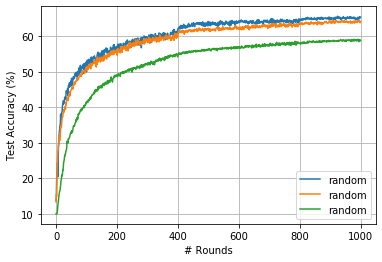

In [34]:
plt.plot(acc_test_arr[0,0,:], label='random')
plt.plot(acc_test_arr[1,0,:], label='random')
plt.plot(acc_test_arr[2,0,:], label='random')
# plt.plot(acc_test_arr_partition[:], label='partition')
# plt.plot(acc_test_arr_Proposed_N40_K8_T4[:], label='proposed, T=4')
# plt.plot(acc_test_arr_Proposed_N40_K8_T2[:], label='proposed, T=2')
# plt.plot(mean_fairness_N120_pdiff_noSelection[3,:], label='proposed, T=4')
# plt.plot(mean_fairness_N120_pdiff_noSelection[4,:], label='proposed, T=3')
# plt.plot(mean_fairness_N120_pdiff[5,:], label='proposed, T=2')
plt.ylabel('Test Accuracy (%)')
plt.xlabel('# Rounds')
# plt.ylim([-0.1,1.1])
plt.grid()
plt.legend()
plt.show()

# 3. Partition

In [5]:
N   = 120
K   = 12

Codebook_Proposed_T6 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_T4 = CodeBookDesign_Bin(N,K,4)
Codebook_Proposed_T3 = CodeBookDesign_Bin(N,K,3)

Codebook_Partition = CodeBookDesign_Partition(N,K)

# print(Codebook_Partition)

@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 4060
@CodeBookDesign_Bin, Codebook Size= 91389
@CodeBookDesign_Partition, Codebook Size= 10


In [41]:
from models.Nets import NIN,CNN_moderate, CNNCifar3

lr_array = [0.1]


args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'

args.local_ep = 1
args.local_bs = 50

acc_test_arr_Partition_N120_K12_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Partition_N120_K12_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_partition_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Partition * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Partition, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Partition, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Partition[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_partition_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Partition[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_partition_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Partition_N120_K12_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Partition_N120_K12_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.1

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[iter= 0 ] @Partition, there is no available codebook

Test set: Average loss: 2.3060 
Accuracy: 1001/10000 (10.01%)

Round   0, Train average loss 0.792 Test accuracy 10.010
[iter= 1 ] @Partition, there is no available codebook

Test set: Average loss: 2.3060 
Accuracy: 1001/10000 (10.01%)

Round   1, Train average loss 0.792 Test accuracy 10.010
[iter= 2 ] @Partition, there is no available codebook

Test set: Average loss: 2.3060 
Accuracy: 1001/10000 (10.01%)

Round   2, Train average loss 0.792 Test accuracy 10.010
[iter= 3 ]


Test set: Average loss: 2.1325 
Accuracy: 2477/10000 (24.77%)

Round  38, Train average loss 2.130 Test accuracy 24.770
[iter= 39 ] @Partition, there is no available codebook

Test set: Average loss: 2.1325 
Accuracy: 2477/10000 (24.77%)

Round  39, Train average loss 2.130 Test accuracy 24.770
[iter= 40 ] @Partition, there is no available codebook

Test set: Average loss: 2.1325 
Accuracy: 2477/10000 (24.77%)

Round  40, Train average loss 2.130 Test accuracy 24.770
[iter= 41 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 2.0602 
Accuracy: 2752/10000 (27.52%)

Round  41, Train average loss 2.092 Test accuracy 27.520
[iter= 42 ] @Partition, there is no available codebook

Test set: Average loss: 2.0602 
Accuracy: 2752/10000 (27.52%)

Round  42, Train average loss 2.092 Test

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.9443 
Accuracy: 3406/10000 (34.06%)

Round  78, Train average loss 1.957 Test accuracy 34.060
[iter= 79 ] @Partition, there is no available codebook

Test set: Average loss: 1.9443 
Accuracy: 3406/10000 (34.06%)

Round  79, Train average loss 1.957 Test accuracy 34.060
[iter= 80 ] @Partition, there is no available codebook

Test set: Average loss: 1.9443 
Accuracy: 3406/10000 (34.06%)

Round  80, Train average loss 1.957 Test accuracy 34.060
[iter= 81 ] @Partition, there is no available codebook

Test set: Average loss: 1.9443 
Accuracy: 3406/10000 (34.06%)

Round  81, Train average loss 1.957 Test accuracy 34.060
[iter= 82 ] @Partition, there is no available codebook

Test set: Average loss: 1.9443 
Accuracy: 3406/10000 (34.06%)

Round  82, Train average loss 1.957 Test accuracy 34.060
[iter


Test set: Average loss: 1.8388 
Accuracy: 3894/10000 (38.94%)

Round 118, Train average loss 1.878 Test accuracy 38.940
[iter= 119 ] @Partition, there is no available codebook

Test set: Average loss: 1.8388 
Accuracy: 3894/10000 (38.94%)

Round 119, Train average loss 1.878 Test accuracy 38.940
[iter= 120 ] @Partition, there is no available codebook

Test set: Average loss: 1.8388 
Accuracy: 3894/10000 (38.94%)

Round 120, Train average loss 1.878 Test accuracy 38.940
[iter= 121 ] @Partition, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.8233 
Accuracy: 3983/10000 (39.83%)

Round 121, Train average loss 1.832 Test accuracy 39.830
[iter= 122 ] @Partition, there is no available codebook

Test set: Average loss: 1.8233 
Accuracy: 3983/10000 (39.83%)

Round 122, Train average loss 1.832 

selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.7759 
Accuracy: 4003/10000 (40.03%)

Round 158, Train average loss 1.772 Test accuracy 40.030
[iter= 159 ] @Partition, there is no available codebook

Test set: Average loss: 1.7759 
Accuracy: 4003/10000 (40.03%)

Round 159, Train average loss 1.772 Test accuracy 40.030
[iter= 160 ] @Partition, there is no available codebook

Test set: Average loss: 1.7759 
Accuracy: 4003/10000 (40.03%)

Round 160, Train average loss 1.772 Test accuracy 40.030
[iter= 161 ] @Partition, there is no available codebook

Test set: Average loss: 1.7759 
Accuracy: 4003/10000 (40.03%)

Round 161, Train average loss 1.772 Test accuracy 40.030
[iter= 162 ] @Partition, there is no available codebook

Test set: Average loss: 1.7759 
Accuracy: 4003/10000 (40.03%)

Round 162, Train average loss 1.772 Test accuracy 40.030
[


Test set: Average loss: 1.6947 
Accuracy: 4325/10000 (43.25%)

Round 197, Train average loss 1.650 Test accuracy 43.250
[iter= 198 ] @Partition, there is no available codebook

Test set: Average loss: 1.6947 
Accuracy: 4325/10000 (43.25%)

Round 198, Train average loss 1.650 Test accuracy 43.250
[iter= 199 ] @Partition, there is no available codebook

Test set: Average loss: 1.6947 
Accuracy: 4325/10000 (43.25%)

Round 199, Train average loss 1.650 Test accuracy 43.250
[iter= 200 ] @Partition, there is no available codebook

Test set: Average loss: 1.6947 
Accuracy: 4325/10000 (43.25%)

Round 200, Train average loss 1.650 Test accuracy 43.250
[iter= 201 ] @Partition, there is no available codebook

Test set: Average loss: 1.6947 
Accuracy: 4325/10000 (43.25%)

Round 201, Train average loss 1.650 Test accuracy 43.250
[iter= 202 ] @Partition, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected


Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 236, Train average loss 1.657 Test accuracy 43.600
[iter= 237 ] @Partition, there is no available codebook

Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 237, Train average loss 1.657 Test accuracy 43.600
[iter= 238 ] @Partition, there is no available codebook

Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 238, Train average loss 1.657 Test accuracy 43.600
[iter= 239 ] @Partition, there is no available codebook

Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 239, Train average loss 1.657 Test accuracy 43.600
[iter= 240 ] @Partition, there is no available codebook

Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 240, Train average loss 1.657 Test accuracy 43.600
[iter= 241 ] @Partition, there is no available codebook

Test set: Average loss: 1.6746 
Accuracy: 4360/10000 (43.60%)

Round 241, Train average loss 1.657 Test accuracy 4


Test set: Average loss: 1.6219 
Accuracy: 4396/10000 (43.96%)

Round 272, Train average loss 1.613 Test accuracy 43.960
[iter= 273 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.5892 
Accuracy: 4643/10000 (46.43%)

Round 273, Train average loss 1.600 Test accuracy 46.430
[iter= 274 ] @Partition, there is no available codebook

Test set: Average loss: 1.5892 
Accuracy: 4643/10000 (46.43%)

Round 274, Train average loss 1.600 Test accuracy 46.430
[iter= 275 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.5889 
Accuracy: 4647/10000 (46.47%)

Round 275, Train average loss 1

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.5612 
Accuracy: 4842/10000 (48.42%)

Round 311, Train average loss 1.536 Test accuracy 48.420
[iter= 312 ] @Partition, there is no available codebook

Test set: Average loss: 1.5612 
Accuracy: 4842/10000 (48.42%)

Round 312, Train average loss 1.536 Test accuracy 48.420
[iter= 313 ] @Partition, there is no available codebook

Test set: Average loss: 1.5612 
Accuracy: 4842/10000 (48.42%)

Round 313, Train average loss 1.536 Test accuracy 48.420
[iter= 314 ] @Partition, there is no available codebook

Test set: Average loss: 1.5612 
Accuracy: 4842/10000 (48.42%)

Round 314, Train average loss 1.536 Test accuracy 48.420
[iter= 315 ] @Partition, there is no available codebook

Test set: Average loss: 1.5612 
Accuracy: 4842/10000 (48.42%)

Round 315, Train average loss 1.536 Test accuracy 48.420
[iter= 31


Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 351, Train average loss 1.509 Test accuracy 48.820
[iter= 352 ] @Partition, there is no available codebook

Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 352, Train average loss 1.509 Test accuracy 48.820
[iter= 353 ] @Partition, there is no available codebook

Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 353, Train average loss 1.509 Test accuracy 48.820
[iter= 354 ] @Partition, there is no available codebook

Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 354, Train average loss 1.509 Test accuracy 48.820
[iter= 355 ] @Partition, there is no available codebook

Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 355, Train average loss 1.509 Test accuracy 48.820
[iter= 356 ] @Partition, there is no available codebook

Test set: Average loss: 1.5128 
Accuracy: 4882/10000 (48.82%)

Round 356, Train average loss 1.509 Test accuracy 4


Test set: Average loss: 1.5336 
Accuracy: 4848/10000 (48.48%)

Round 393, Train average loss 1.500 Test accuracy 48.480
[iter= 394 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.5135 
Accuracy: 4931/10000 (49.31%)

Round 394, Train average loss 1.524 Test accuracy 49.310
[iter= 395 ] @Partition, there is no available codebook

Test set: Average loss: 1.5135 
Accuracy: 4931/10000 (49.31%)

Round 395, Train average loss 1.524 Test accuracy 49.310
[iter= 396 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.5298 
Accuracy: 4847/10000 (48.47%)

Round 396, Tr


Test set: Average loss: 1.4091 
Accuracy: 5129/10000 (51.29%)

Round 431, Train average loss 1.380 Test accuracy 51.290
[iter= 432 ] @Partition, there is no available codebook

Test set: Average loss: 1.4091 
Accuracy: 5129/10000 (51.29%)

Round 432, Train average loss 1.380 Test accuracy 51.290
[iter= 433 ] @Partition, there is no available codebook

Test set: Average loss: 1.4091 
Accuracy: 5129/10000 (51.29%)

Round 433, Train average loss 1.380 Test accuracy 51.290
[iter= 434 ] @Partition, there is no available codebook

Test set: Average loss: 1.4091 
Accuracy: 5129/10000 (51.29%)

Round 434, Train average loss 1.380 Test accuracy 51.290
[iter= 435 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.4112 
Accuracy: 5137/10000 (51.37%)

Round 435, Train average loss 1.395 Test accur

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3938 
Accuracy: 5187/10000 (51.87%)

Round 470, Train average loss 1.355 Test accuracy 51.870
[iter= 471 ] @Partition, there is no available codebook

Test set: Average loss: 1.3938 
Accuracy: 5187/10000 (51.87%)

Round 471, Train average loss 1.355 Test accuracy 51.870
[iter= 472 ] @Partition, there is no available codebook

Test set: Average loss: 1.3938 
Accuracy: 5187/10000 (51.87%)

Round 472, Train average loss 1.355 Test accuracy 51.870
[iter= 473 ] @Partition, there is no available codebook

Test set: Average loss: 1.3938 
Accuracy: 5187/10000 (51.87%)

Round 473, Train average loss 1.355 Test accuracy 51.870
[iter= 474 ] @Partition, there is no available codebook

Test set: Average loss: 1.3938 
Accuracy: 5187/10000 (51.87%)

Round 474, Train average loss 1.355 Test accuracy 51.870
[iter= 47

selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3982 
Accuracy: 5201/10000 (52.01%)

Round 510, Train average loss 1.427 Test accuracy 52.010
[iter= 511 ] @Partition, there is no available codebook

Test set: Average loss: 1.3982 
Accuracy: 5201/10000 (52.01%)

Round 511, Train average loss 1.427 Test accuracy 52.010
[iter= 512 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.3815 
Accuracy: 5245/10000 (52.45%)

Round 512, Train average loss 1.377 Test accuracy 52.450
[iter= 513 ] @Partition, there is no available codebook

Test set: Average loss: 1.3815 
Accuracy: 5245/10000 (52.45%)

Round 513, Train average loss 1.377 Test ac


Test set: Average loss: 1.3799 
Accuracy: 5301/10000 (53.01%)

Round 549, Train average loss 1.380 Test accuracy 53.010
[iter= 550 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3681 
Accuracy: 5251/10000 (52.51%)

Round 550, Train average loss 1.288 Test accuracy 52.510
[iter= 551 ] @Partition, there is no available codebook

Test set: Average loss: 1.3681 
Accuracy: 5251/10000 (52.51%)

Round 551, Train average loss 1.288 Test accuracy 52.510
[iter= 552 ] @Partition, there is no available codebook

Test set: Average loss: 1.3681 
Accuracy: 5251/10000 (52.51%)

Round 552, Train average loss 1.288 Test accuracy 52.510
[iter= 553 ] @Partition, there is no available codebook

Test set: Average loss: 1.3681 
Accuracy: 5251/10000 (52.51%)

Round 553, Train average loss 1.288 

selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.3696 
Accuracy: 5309/10000 (53.09%)

Round 590, Train average loss 1.378 Test accuracy 53.090
[iter= 591 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3724 
Accuracy: 5329/10000 (53.29%)

Round 591, Train average loss 1.370 Test accuracy 53.290
[iter= 592 ] @Partition, there is no available codebook

Test set: Average loss: 1.3724 
Accuracy: 5329/10000 (53.29%)

Round 592, Train average loss 1.370 Test accuracy 53.290
[iter= 593 ] @Partition, there is no available codebook

Test set: Average loss: 1.3724 
Accuracy: 5329/10000 (53.29%)

Round 593, Train average loss 1.370


Test set: Average loss: 1.3594 
Accuracy: 5309/10000 (53.09%)

Round 630, Train average loss 1.354 Test accuracy 53.090
[iter= 631 ] @Partition, there is no available codebook

Test set: Average loss: 1.3594 
Accuracy: 5309/10000 (53.09%)

Round 631, Train average loss 1.354 Test accuracy 53.090
[iter= 632 ] @Partition, there is no available codebook

Test set: Average loss: 1.3594 
Accuracy: 5309/10000 (53.09%)

Round 632, Train average loss 1.354 Test accuracy 53.090
[iter= 633 ] @Partition, there is no available codebook

Test set: Average loss: 1.3594 
Accuracy: 5309/10000 (53.09%)

Round 633, Train average loss 1.354 Test accuracy 53.090
[iter= 634 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3576 
Accuracy: 5294/10000 (52.94%)

Round 634, Train average loss 1.264 

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3546 
Accuracy: 5312/10000 (53.12%)

Round 670, Train average loss 1.251 Test accuracy 53.120
[iter= 671 ] @Partition, there is no available codebook

Test set: Average loss: 1.3546 
Accuracy: 5312/10000 (53.12%)

Round 671, Train average loss 1.251 Test accuracy 53.120
[iter= 672 ] @Partition, there is no available codebook

Test set: Average loss: 1.3546 
Accuracy: 5312/10000 (53.12%)

Round 672, Train average loss 1.251 Test accuracy 53.120
[iter= 673 ] @Partition, there is no available codebook

Test set: Average loss: 1.3546 
Accuracy: 5312/10000 (53.12%)

Round 673, Train average loss 1.251 Test accuracy 53.120
[iter= 674 ] @Partition, there is no available codebook

Test set: Average loss: 1.3546 
Accuracy: 5312/10000 (53.12%)

Round 674, Train average loss 1.251 Test accuracy 53.120
[


Test set: Average loss: 1.3487 
Accuracy: 5397/10000 (53.97%)

Round 708, Train average loss 1.365 Test accuracy 53.970
[iter= 709 ] @Partition, there is no available codebook

Test set: Average loss: 1.3487 
Accuracy: 5397/10000 (53.97%)

Round 709, Train average loss 1.365 Test accuracy 53.970
[iter= 710 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.3418 
Accuracy: 5421/10000 (54.21%)

Round 710, Train average loss 1.340 Test accuracy 54.210
[iter= 711 ] @Partition, there is no available codebook

Test set: Average loss: 1.3418 
Accuracy: 5421/10000 (54.21%)

Round 711, Train average loss 1.340 Test accuracy 54.210
[iter= 712 ] @Partition, there is no available codebook

Test set: Average loss: 1.3418 
Accuracy: 5421/10000 (54.21%)

Round 712, Train average loss 1.340 


Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 749, Train average loss 1.209 Test accuracy 54.290
[iter= 750 ] @Partition, there is no available codebook

Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 750, Train average loss 1.209 Test accuracy 54.290
[iter= 751 ] @Partition, there is no available codebook

Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 751, Train average loss 1.209 Test accuracy 54.290
[iter= 752 ] @Partition, there is no available codebook

Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 752, Train average loss 1.209 Test accuracy 54.290
[iter= 753 ] @Partition, there is no available codebook

Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 753, Train average loss 1.209 Test accuracy 54.290
[iter= 754 ] @Partition, there is no available codebook

Test set: Average loss: 1.3172 
Accuracy: 5429/10000 (54.29%)

Round 754, Train average loss 1.209 Test accuracy 5


Test set: Average loss: 1.3418 
Accuracy: 5458/10000 (54.58%)

Round 786, Train average loss 1.358 Test accuracy 54.580
[iter= 787 ] @Partition, there is no available codebook

Test set: Average loss: 1.3418 
Accuracy: 5458/10000 (54.58%)

Round 787, Train average loss 1.358 Test accuracy 54.580
[iter= 788 ] @Partition, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.3379 
Accuracy: 5489/10000 (54.89%)

Round 788, Train average loss 1.371 Test accuracy 54.890
[iter= 789 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.3430 
Accuracy: 5419/10000 (54.19%)

Round 789, Train aver


Test set: Average loss: 1.2954 
Accuracy: 5513/10000 (55.13%)

Round 823, Train average loss 1.205 Test accuracy 55.130
[iter= 824 ] @Partition, there is no available codebook

Test set: Average loss: 1.2954 
Accuracy: 5513/10000 (55.13%)

Round 824, Train average loss 1.205 Test accuracy 55.130
[iter= 825 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.2821 
Accuracy: 5519/10000 (55.19%)

Round 825, Train average loss 1.103 Test accuracy 55.190
[iter= 826 ] @Partition, there is no available codebook

Test set: Average loss: 1.2821 
Accuracy: 5519/10000 (55.19%)

Round 826, Train average loss 1.103 Test accuracy 55.190
[iter= 827 ] @Partition, there is no available codebook

Test set: Average loss: 1.2821 
Accuracy: 5519/10000 (55.19%)

Round 827, Train average loss 1.103 


Test set: Average loss: 1.2989 
Accuracy: 5525/10000 (55.25%)

Round 864, Train average loss 1.278 Test accuracy 55.250
[iter= 865 ] @Partition, there is no available codebook

Test set: Average loss: 1.2989 
Accuracy: 5525/10000 (55.25%)

Round 865, Train average loss 1.278 Test accuracy 55.250
[iter= 866 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.2923 
Accuracy: 5488/10000 (54.88%)

Round 866, Train average loss 1.177 Test accuracy 54.880
[iter= 867 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.2851 
Accuracy: 5489/10000 (54.89%)

Round 867, Train average loss 1.164 Test 


Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 901, Train average loss 1.243 Test accuracy 54.940
[iter= 902 ] @Partition, there is no available codebook

Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 902, Train average loss 1.243 Test accuracy 54.940
[iter= 903 ] @Partition, there is no available codebook

Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 903, Train average loss 1.243 Test accuracy 54.940
[iter= 904 ] @Partition, there is no available codebook

Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 904, Train average loss 1.243 Test accuracy 54.940
[iter= 905 ] @Partition, there is no available codebook

Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 905, Train average loss 1.243 Test accuracy 54.940
[iter= 906 ] @Partition, there is no available codebook

Test set: Average loss: 1.3008 
Accuracy: 5494/10000 (54.94%)

Round 906, Train average loss 1.243 Test accuracy 5


Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 939, Train average loss 1.269 Test accuracy 55.860
[iter= 940 ] @Partition, there is no available codebook

Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 940, Train average loss 1.269 Test accuracy 55.860
[iter= 941 ] @Partition, there is no available codebook

Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 941, Train average loss 1.269 Test accuracy 55.860
[iter= 942 ] @Partition, there is no available codebook

Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 942, Train average loss 1.269 Test accuracy 55.860
[iter= 943 ] @Partition, there is no available codebook

Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 943, Train average loss 1.269 Test accuracy 55.860
[iter= 944 ] @Partition, there is no available codebook

Test set: Average loss: 1.2862 
Accuracy: 5586/10000 (55.86%)

Round 944, Train average loss 1.269 Test accuracy 5


Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 978, Train average loss 1.088 Test accuracy 55.590
[iter= 979 ] @Partition, there is no available codebook

Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 979, Train average loss 1.088 Test accuracy 55.590
[iter= 980 ] @Partition, there is no available codebook

Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 980, Train average loss 1.088 Test accuracy 55.590
[iter= 981 ] @Partition, there is no available codebook

Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 981, Train average loss 1.088 Test accuracy 55.590
[iter= 982 ] @Partition, there is no available codebook

Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 982, Train average loss 1.088 Test accuracy 55.590
[iter= 983 ] @Partition, there is no available codebook

Test set: Average loss: 1.2842 
Accuracy: 5559/10000 (55.59%)

Round 983, Train average loss 1.088 Test accuracy 5


Test set: Average loss: 2.1462 
Accuracy: 2327/10000 (23.27%)

Round  15, Train average loss 2.174 Test accuracy 23.270
[iter= 16 ] @Partition, there is no available codebook

Test set: Average loss: 2.1462 
Accuracy: 2327/10000 (23.27%)

Round  16, Train average loss 2.174 Test accuracy 23.270
[iter= 17 ] @Partition, there is no available codebook

Test set: Average loss: 2.1462 
Accuracy: 2327/10000 (23.27%)

Round  17, Train average loss 2.174 Test accuracy 23.270
[iter= 18 ] @Partition, there is no available codebook

Test set: Average loss: 2.1462 
Accuracy: 2327/10000 (23.27%)

Round  18, Train average loss 2.174 Test accuracy 23.270
[iter= 19 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 2.1005 
Accuracy: 2570/10000 (25.70%)

Round  19, Train average loss 2.124 Test accuracy 


Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  52, Train average loss 1.958 Test accuracy 34.750
[iter= 53 ] @Partition, there is no available codebook

Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  53, Train average loss 1.958 Test accuracy 34.750
[iter= 54 ] @Partition, there is no available codebook

Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  54, Train average loss 1.958 Test accuracy 34.750
[iter= 55 ] @Partition, there is no available codebook

Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  55, Train average loss 1.958 Test accuracy 34.750
[iter= 56 ] @Partition, there is no available codebook

Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  56, Train average loss 1.958 Test accuracy 34.750
[iter= 57 ] @Partition, there is no available codebook

Test set: Average loss: 1.9790 
Accuracy: 3475/10000 (34.75%)

Round  57, Train average loss 1.958 Test accuracy 34.750


Test set: Average loss: 1.8370 
Accuracy: 3910/10000 (39.10%)

Round  94, Train average loss 1.853 Test accuracy 39.100
[iter= 95 ] @Partition, there is no available codebook

Test set: Average loss: 1.8370 
Accuracy: 3910/10000 (39.10%)

Round  95, Train average loss 1.853 Test accuracy 39.100
[iter= 96 ] @Partition, there is no available codebook

Test set: Average loss: 1.8370 
Accuracy: 3910/10000 (39.10%)

Round  96, Train average loss 1.853 Test accuracy 39.100
[iter= 97 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.8294 
Accuracy: 3942/10000 (39.42%)

Round  97, Train average loss 1.823 Test accuracy 39.420
[iter= 98 ] @Partition, there is no available codebook

Test set: Average loss: 1.8294 
Accuracy: 3942/10000 (39.42%)

Round  98, Train average loss 1.823 Test accuracy 


Test set: Average loss: 1.7208 
Accuracy: 4356/10000 (43.56%)

Round 130, Train average loss 1.737 Test accuracy 43.560
[iter= 131 ] @Partition, there is no available codebook

Test set: Average loss: 1.7208 
Accuracy: 4356/10000 (43.56%)

Round 131, Train average loss 1.737 Test accuracy 43.560
[iter= 132 ] @Partition, there is no available codebook

Test set: Average loss: 1.7208 
Accuracy: 4356/10000 (43.56%)

Round 132, Train average loss 1.737 Test accuracy 43.560
[iter= 133 ] @Partition, there is no available codebook

Test set: Average loss: 1.7208 
Accuracy: 4356/10000 (43.56%)

Round 133, Train average loss 1.737 Test accuracy 43.560
[iter= 134 ] @Partition, there is no available codebook

Test set: Average loss: 1.7208 
Accuracy: 4356/10000 (43.56%)

Round 134, Train average loss 1.737 Test accuracy 43.560
[iter= 135 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected


Test set: Average loss: 1.6751 
Accuracy: 4352/10000 (43.52%)

Round 175, Train average loss 1.694 Test accuracy 43.520
[iter= 176 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.7156 
Accuracy: 4451/10000 (44.51%)

Round 176, Train average loss 1.723 Test accuracy 44.510
[iter= 177 ] @Partition, there is no available codebook

Test set: Average loss: 1.7156 
Accuracy: 4451/10000 (44.51%)

Round 177, Train average loss 1.723 Test accuracy 44.510
[iter= 178 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.6888 
Accuracy: 4418/10000 (44.18%)

Round 178, Tr


Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 216, Train average loss 1.653 Test accuracy 44.720
[iter= 217 ] @Partition, there is no available codebook

Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 217, Train average loss 1.653 Test accuracy 44.720
[iter= 218 ] @Partition, there is no available codebook

Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 218, Train average loss 1.653 Test accuracy 44.720
[iter= 219 ] @Partition, there is no available codebook

Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 219, Train average loss 1.653 Test accuracy 44.720
[iter= 220 ] @Partition, there is no available codebook

Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 220, Train average loss 1.653 Test accuracy 44.720
[iter= 221 ] @Partition, there is no available codebook

Test set: Average loss: 1.6374 
Accuracy: 4472/10000 (44.72%)

Round 221, Train average loss 1.653 Test accuracy 4


Test set: Average loss: 1.5851 
Accuracy: 4640/10000 (46.40%)

Round 256, Train average loss 1.614 Test accuracy 46.400
[iter= 257 ] @Partition, there is no available codebook

Test set: Average loss: 1.5851 
Accuracy: 4640/10000 (46.40%)

Round 257, Train average loss 1.614 Test accuracy 46.400
[iter= 258 ] @Partition, there is no available codebook

Test set: Average loss: 1.5851 
Accuracy: 4640/10000 (46.40%)

Round 258, Train average loss 1.614 Test accuracy 46.400
[iter= 259 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.6091 
Accuracy: 4696/10000 (46.96%)

Round 259, Train average loss 1.628 Test accuracy 46.960
[iter= 260 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
se


Test set: Average loss: 1.5482 
Accuracy: 4783/10000 (47.83%)

Round 296, Train average loss 1.565 Test accuracy 47.830
[iter= 297 ] @Partition, there is no available codebook

Test set: Average loss: 1.5482 
Accuracy: 4783/10000 (47.83%)

Round 297, Train average loss 1.565 Test accuracy 47.830
[iter= 298 ] @Partition, there is no available codebook

Test set: Average loss: 1.5482 
Accuracy: 4783/10000 (47.83%)

Round 298, Train average loss 1.565 Test accuracy 47.830
[iter= 299 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.5527 
Accuracy: 4734/10000 (47.34%)

Round 299, Train average loss 1.561 Test accuracy 47.340
[iter= 300 ] @Partition, there is no available codebook

Test set: Average loss: 1.5527 
Accuracy: 4734/10000 (47.34%)

Round 300, Train average loss 1.561 


Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 336, Train average loss 1.543 Test accuracy 48.940
[iter= 337 ] @Partition, there is no available codebook

Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 337, Train average loss 1.543 Test accuracy 48.940
[iter= 338 ] @Partition, there is no available codebook

Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 338, Train average loss 1.543 Test accuracy 48.940
[iter= 339 ] @Partition, there is no available codebook

Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 339, Train average loss 1.543 Test accuracy 48.940
[iter= 340 ] @Partition, there is no available codebook

Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 340, Train average loss 1.543 Test accuracy 48.940
[iter= 341 ] @Partition, there is no available codebook

Test set: Average loss: 1.5304 
Accuracy: 4894/10000 (48.94%)

Round 341, Train average loss 1.543 Test accuracy 4


Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 372, Train average loss 1.495 Test accuracy 49.260
[iter= 373 ] @Partition, there is no available codebook

Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 373, Train average loss 1.495 Test accuracy 49.260
[iter= 374 ] @Partition, there is no available codebook

Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 374, Train average loss 1.495 Test accuracy 49.260
[iter= 375 ] @Partition, there is no available codebook

Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 375, Train average loss 1.495 Test accuracy 49.260
[iter= 376 ] @Partition, there is no available codebook

Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 376, Train average loss 1.495 Test accuracy 49.260
[iter= 377 ] @Partition, there is no available codebook

Test set: Average loss: 1.4972 
Accuracy: 4926/10000 (49.26%)

Round 377, Train average loss 1.495 Test accuracy 4

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.4070 
Accuracy: 5103/10000 (51.03%)

Round 414, Train average loss 1.326 Test accuracy 51.030
[iter= 415 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3956 
Accuracy: 5151/10000 (51.51%)

Round 415, Train average loss 1.374 Test accuracy 51.510
[iter= 416 ] @Partition, there is no available codebook

Test set: Average loss: 1.3956 
Accuracy: 5151/10000 (51.51%)

Round 416, Train average loss 1.374 Test accuracy 51.510
[iter= 417 ] @Partition, there is no available codebook

Test set: Average loss: 1.3956 
Accuracy: 5151/10000 (51.51%)

Round 417, Train average loss 1.374 Test accuracy 51.


Test set: Average loss: 1.3997 
Accuracy: 5133/10000 (51.33%)

Round 456, Train average loss 1.345 Test accuracy 51.330
[iter= 457 ] @Partition, there is no available codebook

Test set: Average loss: 1.3997 
Accuracy: 5133/10000 (51.33%)

Round 457, Train average loss 1.345 Test accuracy 51.330
[iter= 458 ] @Partition, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.4135 
Accuracy: 5197/10000 (51.97%)

Round 458, Train average loss 1.436 Test accuracy 51.970
[iter= 459 ] @Partition, there is no available codebook

Test set: Average loss: 1.4135 
Accuracy: 5197/10000 (51.97%)

Round 459, Train average loss 1.436 Test accuracy 51.970
[iter= 460 ] @Partition, there is no available codebook

Test set: Average loss: 1.4135 
Accuracy: 5197/10000 (51.97%)

Round 460, Train average loss 1.436 


Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 496, Train average loss 1.352 Test accuracy 52.390
[iter= 497 ] @Partition, there is no available codebook

Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 497, Train average loss 1.352 Test accuracy 52.390
[iter= 498 ] @Partition, there is no available codebook

Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 498, Train average loss 1.352 Test accuracy 52.390
[iter= 499 ] @Partition, there is no available codebook

Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 499, Train average loss 1.352 Test accuracy 52.390
[iter= 500 ] @Partition, there is no available codebook

Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 500, Train average loss 1.352 Test accuracy 52.390
[iter= 501 ] @Partition, there is no available codebook

Test set: Average loss: 1.3663 
Accuracy: 5239/10000 (52.39%)

Round 501, Train average loss 1.352 Test accuracy 5


Test set: Average loss: 1.3805 
Accuracy: 5272/10000 (52.72%)

Round 538, Train average loss 1.397 Test accuracy 52.720
[iter= 539 ] @Partition, there is no available codebook

Test set: Average loss: 1.3805 
Accuracy: 5272/10000 (52.72%)

Round 539, Train average loss 1.397 Test accuracy 52.720
[iter= 540 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3637 
Accuracy: 5267/10000 (52.67%)

Round 540, Train average loss 1.312 Test accuracy 52.670
[iter= 541 ] @Partition, there is no available codebook

Test set: Average loss: 1.3637 
Accuracy: 5267/10000 (52.67%)

Round 541, Train average loss 1.312 Test accuracy 52.670
[iter= 542 ] @Partition, there is no available codebook

Test set: Average loss: 1.3637 
Accuracy: 5267/10000 (52.67%)

Round 542, Train average loss 1.312 

selected idx= 94
selected idx= 95

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 578, Train average loss 1.406 Test accuracy 53.520
[iter= 579 ] @Partition, there is no available codebook

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 579, Train average loss 1.406 Test accuracy 53.520
[iter= 580 ] @Partition, there is no available codebook

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 580, Train average loss 1.406 Test accuracy 53.520
[iter= 581 ] @Partition, there is no available codebook

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 581, Train average loss 1.406 Test accuracy 53.520
[iter= 582 ] @Partition, there is no available codebook

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 582, Train average loss 1.406 Test accuracy 53.520
[iter= 583 ] @Partition, there is no available codebook

Test set: Average loss: 1.3670 
Accuracy: 5352/10000 (53.52%)

Round 583, Train 


Test set: Average loss: 1.3658 
Accuracy: 5319/10000 (53.19%)

Round 620, Train average loss 1.364 Test accuracy 53.190
[iter= 621 ] @Partition, there is no available codebook

Test set: Average loss: 1.3658 
Accuracy: 5319/10000 (53.19%)

Round 621, Train average loss 1.364 Test accuracy 53.190
[iter= 622 ] @Partition, there is no available codebook

Test set: Average loss: 1.3658 
Accuracy: 5319/10000 (53.19%)

Round 622, Train average loss 1.364 Test accuracy 53.190
[iter= 623 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3650 
Accuracy: 5306/10000 (53.06%)

Round 623, Train average loss 1.330 Test accuracy 53.060
[iter= 624 ] @Partition, there is no available codebook

Test set: Average loss: 1.3650 
Accuracy: 5306/10000 (53.06%)

Round 624, Train average loss 1.330 Test accur


Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 659, Train average loss 1.341 Test accuracy 53.180
[iter= 660 ] @Partition, there is no available codebook

Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 660, Train average loss 1.341 Test accuracy 53.180
[iter= 661 ] @Partition, there is no available codebook

Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 661, Train average loss 1.341 Test accuracy 53.180
[iter= 662 ] @Partition, there is no available codebook

Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 662, Train average loss 1.341 Test accuracy 53.180
[iter= 663 ] @Partition, there is no available codebook

Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 663, Train average loss 1.341 Test accuracy 53.180
[iter= 664 ] @Partition, there is no available codebook

Test set: Average loss: 1.3572 
Accuracy: 5318/10000 (53.18%)

Round 664, Train average loss 1.341 Test accuracy 5


Test set: Average loss: 1.3484 
Accuracy: 5474/10000 (54.74%)

Round 698, Train average loss 1.384 Test accuracy 54.740
[iter= 699 ] @Partition, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.3339 
Accuracy: 5453/10000 (54.53%)

Round 699, Train average loss 1.295 Test accuracy 54.530
[iter= 700 ] @Partition, there is no available codebook

Test set: Average loss: 1.3339 
Accuracy: 5453/10000 (54.53%)

Round 700, Train average loss 1.295 Test accuracy 54.530
[iter= 701 ] @Partition, there is no available codebook

Test set: Average loss: 1.3339 
Accuracy: 5453/10000 (54.53%)

Round 701, Train average loss 1.295 Test accuracy 54.530
[iter= 702 ] @Partition, there is no available codebook

Test set: Average loss: 1.3339 
Accuracy: 5453/10000 (54.53%)

Round 702, Train average loss 1.295 


Test set: Average loss: 1.3555 
Accuracy: 5498/10000 (54.98%)

Round 739, Train average loss 1.407 Test accuracy 54.980
[iter= 740 ] @Partition, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3536 
Accuracy: 5440/10000 (54.40%)

Round 740, Train average loss 1.394 Test accuracy 54.400
[iter= 741 ] @Partition, there is no available codebook

Test set: Average loss: 1.3536 
Accuracy: 5440/10000 (54.40%)

Round 741, Train average loss 1.394 Test accuracy 54.400
[iter= 742 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3221 
Accuracy: 5435/10000 (54.35%)

R

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3165 
Accuracy: 5485/10000 (54.85%)

Round 776, Train average loss 1.243 Test accuracy 54.850
[iter= 777 ] @Partition, there is no available codebook

Test set: Average loss: 1.3165 
Accuracy: 5485/10000 (54.85%)

Round 777, Train average loss 1.243 Test accuracy 54.850
[iter= 778 ] @Partition, there is no available codebook

Test set: Average loss: 1.3165 
Accuracy: 5485/10000 (54.85%)

Round 778, Train average loss 1.243 Test accuracy 54.850
[iter= 779 ] @Partition, there is no available codebook

Test set: Average loss: 1.3165 
Accuracy: 5485/10000 (54.85%)

Round 779, Train average loss 1.243 Test accuracy 54.850
[iter= 780 ] @Partition, there is no available codebook

Test set: Average loss: 1.3165 
Accuracy: 5485/10000 (54.85%)

Round 780, Train average loss 1.243 Test accuracy 54.850
[iter= 78


Test set: Average loss: 1.2844 
Accuracy: 5550/10000 (55.50%)

Round 819, Train average loss 1.186 Test accuracy 55.500
[iter= 820 ] @Partition, there is no available codebook

Test set: Average loss: 1.2844 
Accuracy: 5550/10000 (55.50%)

Round 820, Train average loss 1.186 Test accuracy 55.500
[iter= 821 ] @Partition, there is no available codebook

Test set: Average loss: 1.2844 
Accuracy: 5550/10000 (55.50%)

Round 821, Train average loss 1.186 Test accuracy 55.500
[iter= 822 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.2794 
Accuracy: 5552/10000 (55.52%)

Round 822, Train average loss 1.159 Test accuracy 55.520
[iter= 823 ] @Partition, there is no available codebook

Test set: Average loss: 1.2794 
Accuracy: 5552/10000 (55.52%)

Round 823, Train average loss 1.159 


Test set: Average loss: 1.2753 
Accuracy: 5607/10000 (56.07%)

Round 858, Train average loss 1.240 Test accuracy 56.070
[iter= 859 ] @Partition, there is no available codebook

Test set: Average loss: 1.2753 
Accuracy: 5607/10000 (56.07%)

Round 859, Train average loss 1.240 Test accuracy 56.070
[iter= 860 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.2704 
Accuracy: 5578/10000 (55.78%)

Round 860, Train average loss 1.167 Test accuracy 55.780
[iter= 861 ] @Partition, there is no available codebook

Test set: Average loss: 1.2704 
Accuracy: 5578/10000 (55.78%)

Round 861, Train average loss 1.167 Test accuracy 55.780
[iter= 862 ] @Partition, there is no available codebook

Test set: Average loss: 1.2704 
Accuracy: 5578/10000 (55.78%)

Round 862, Train average loss 1.167 Test accur

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.2647 
Accuracy: 5628/10000 (56.28%)

Round 900, Train average loss 1.159 Test accuracy 56.280
[iter= 901 ] @Partition, there is no available codebook

Test set: Average loss: 1.2647 
Accuracy: 5628/10000 (56.28%)

Round 901, Train average loss 1.159 Test accuracy 56.280
[iter= 902 ] @Partition, there is no available codebook

Test set: Average loss: 1.2647 
Accuracy: 5628/10000 (56.28%)

Round 902, Train average loss 1.159 Test accuracy 56.280
[iter= 903 ] @Partition, there is no available codebook

Test set: Average loss: 1.2647 
Accuracy: 5628/10000 (56.28%)

Round 903, Train average loss 1.159 Test accuracy 56.280
[iter= 904 ] @Partition, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
select


Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 939, Train average loss 1.165 Test accuracy 56.190
[iter= 940 ] @Partition, there is no available codebook

Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 940, Train average loss 1.165 Test accuracy 56.190
[iter= 941 ] @Partition, there is no available codebook

Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 941, Train average loss 1.165 Test accuracy 56.190
[iter= 942 ] @Partition, there is no available codebook

Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 942, Train average loss 1.165 Test accuracy 56.190
[iter= 943 ] @Partition, there is no available codebook

Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 943, Train average loss 1.165 Test accuracy 56.190
[iter= 944 ] @Partition, there is no available codebook

Test set: Average loss: 1.2646 
Accuracy: 5619/10000 (56.19%)

Round 944, Train average loss 1.165 Test accuracy 5


Test set: Average loss: 1.2556 
Accuracy: 5640/10000 (56.40%)

Round 979, Train average loss 1.133 Test accuracy 56.400
[iter= 980 ] @Partition, there is no available codebook

Test set: Average loss: 1.2556 
Accuracy: 5640/10000 (56.40%)

Round 980, Train average loss 1.133 Test accuracy 56.400
[iter= 981 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.2618 
Accuracy: 5609/10000 (56.09%)

Round 981, Train average loss 1.135 Test accuracy 56.090
[iter= 982 ] @Partition, there is no available codebook

Test set: Average loss: 1.2618 
Accuracy: 5609/10000 (56.09%)

Round 982, Train average loss 1.135 Test accuracy 56.090
[iter= 983 ] @Partition, there is no available codebook

Test set: Average loss: 1.2618 
Accuracy: 5609/10000 (56.09%)

Round 983, Train average loss 1.135 


Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  15, Train average loss 2.205 Test accuracy 23.670
[iter= 16 ] @Partition, there is no available codebook

Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  16, Train average loss 2.205 Test accuracy 23.670
[iter= 17 ] @Partition, there is no available codebook

Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  17, Train average loss 2.205 Test accuracy 23.670
[iter= 18 ] @Partition, there is no available codebook

Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  18, Train average loss 2.205 Test accuracy 23.670
[iter= 19 ] @Partition, there is no available codebook

Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  19, Train average loss 2.205 Test accuracy 23.670
[iter= 20 ] @Partition, there is no available codebook

Test set: Average loss: 2.1503 
Accuracy: 2367/10000 (23.67%)

Round  20, Train average loss 2.205 Test accuracy 23.670

selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 2.0641 
Accuracy: 2812/10000 (28.12%)

Round  59, Train average loss 2.083 Test accuracy 28.120
[iter= 60 ] @Partition, there is no available codebook

Test set: Average loss: 2.0641 
Accuracy: 2812/10000 (28.12%)

Round  60, Train average loss 2.083 Test accuracy 28.120
[iter= 61 ] @Partition, there is no available codebook

Test set: Average loss: 2.0641 
Accuracy: 2812/10000 (28.12%)

Round  61, Train average loss 2.083 Test accuracy 28.120
[iter= 62 ] @Partition, there is no available codebook

Test set: Average loss: 2.0641 
Accuracy: 2812/10000 (28.12%)

Round  62, Train average loss 2.083 Test accuracy 28.120
[iter= 63 ] @Partition, there is no available codebook

Test set: Average loss: 2.0641 
Accuracy: 2812/10000 (28.12%)

Round  63, Train average loss 2.083 Test accuracy 28.120
[iter= 64 ] @Partition, there is no available codebook

Test set: Average

selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.9266 
Accuracy: 3487/10000 (34.87%)

Round  94, Train average loss 1.895 Test accuracy 34.870
[iter= 95 ] @Partition, there is no available codebook

Test set: Average loss: 1.9266 
Accuracy: 3487/10000 (34.87%)

Round  95, Train average loss 1.895 Test accuracy 34.870
[iter= 96 ] @Partition, there is no available codebook

Test set: Average loss: 1.9266 
Accuracy: 3487/10000 (34.87%)

Round  96, Train average loss 1.895 Test accuracy 34.870
[iter= 97 ] @Partition, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.8815 
Accuracy: 3592/10000 (35.92%)

Round  97, Train average loss 1.885 Test accuracy 35.920
[iter= 98 ] @Partition,


Test set: Average loss: 1.8336 
Accuracy: 3734/10000 (37.34%)

Round 132, Train average loss 1.819 Test accuracy 37.340
[iter= 133 ] @Partition, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.8009 
Accuracy: 3914/10000 (39.14%)

Round 133, Train average loss 1.781 Test accuracy 39.140
[iter= 134 ] @Partition, there is no available codebook

Test set: Average loss: 1.8009 
Accuracy: 3914/10000 (39.14%)

Round 134, Train average loss 1.781 Test accuracy 39.140
[iter= 135 ] @Partition, there is no available codebook

Test set: Average loss: 1.8009 
Accuracy: 3914/10000 (39.14%)

Round 135, Train average loss 1.781 Test accuracy 39.140
[iter= 136 ] @Partition, there is no available codebook

Test set: Average loss: 1.8009 
Accuracy: 3914/10000 (39.14%)

Round 136, Train average loss 1.781 


Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 172, Train average loss 1.727 Test accuracy 39.200
[iter= 173 ] @Partition, there is no available codebook

Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 173, Train average loss 1.727 Test accuracy 39.200
[iter= 174 ] @Partition, there is no available codebook

Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 174, Train average loss 1.727 Test accuracy 39.200
[iter= 175 ] @Partition, there is no available codebook

Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 175, Train average loss 1.727 Test accuracy 39.200
[iter= 176 ] @Partition, there is no available codebook

Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 176, Train average loss 1.727 Test accuracy 39.200
[iter= 177 ] @Partition, there is no available codebook

Test set: Average loss: 1.7832 
Accuracy: 3920/10000 (39.20%)

Round 177, Train average loss 1.727 Test accuracy 3


Test set: Average loss: 1.6977 
Accuracy: 4307/10000 (43.07%)

Round 210, Train average loss 1.727 Test accuracy 43.070
[iter= 211 ] @Partition, there is no available codebook

Test set: Average loss: 1.6977 
Accuracy: 4307/10000 (43.07%)

Round 211, Train average loss 1.727 Test accuracy 43.070
[iter= 212 ] @Partition, there is no available codebook

Test set: Average loss: 1.6977 
Accuracy: 4307/10000 (43.07%)

Round 212, Train average loss 1.727 Test accuracy 43.070
[iter= 213 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.6757 
Accuracy: 4370/10000 (43.70%)

Round 213, Train average loss 1.692 Test accuracy 43.700
[iter= 214 ] @Partition, there is no available codebook

Test set: Average loss: 1.6757 
Accuracy: 4370/10000 (43.70%)

Round 214, Train average loss 1.692 

selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.6346 
Accuracy: 4590/10000 (45.90%)

Round 247, Train average loss 1.665 Test accuracy 45.900
[iter= 248 ] @Partition, there is no available codebook

Test set: Average loss: 1.6346 
Accuracy: 4590/10000 (45.90%)

Round 248, Train average loss 1.665 Test accuracy 45.900
[iter= 249 ] @Partition, there is no available codebook

Test set: Average loss: 1.6346 
Accuracy: 4590/10000 (45.90%)

Round 249, Train average loss 1.665 Test accuracy 45.900
[iter= 250 ] @Partition, there is no available codebook

Test set: Average loss: 1.6346 
Accuracy: 4590/10000 (45.90%)

Round 250, Train average loss 1.665 Test accuracy 45.900
[iter= 251 ] @Partition, there is no available codebook

Test set: Average loss: 1.6346 
Accuracy: 4590/10000 (45.90%)

Round 251, Train average loss 1.665 Test accuracy 45.900
[


Test set: Average loss: 1.5629 
Accuracy: 4641/10000 (46.41%)

Round 287, Train average loss 1.612 Test accuracy 46.410
[iter= 288 ] @Partition, there is no available codebook

Test set: Average loss: 1.5629 
Accuracy: 4641/10000 (46.41%)

Round 288, Train average loss 1.612 Test accuracy 46.410
[iter= 289 ] @Partition, there is no available codebook

Test set: Average loss: 1.5629 
Accuracy: 4641/10000 (46.41%)

Round 289, Train average loss 1.612 Test accuracy 46.410
[iter= 290 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.6278 
Accuracy: 4610/10000 (46.10%)

Round 290, Train average loss 1.621 Test accuracy 46.100
[iter= 291 ] @Partition, there is no available codebook

Test set: Average loss: 1.6278 
Accuracy: 4610/10000 (46.10%)

Round 291, Train average loss 1.621 Test accur

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.6015 
Accuracy: 4664/10000 (46.64%)

Round 328, Train average loss 1.596 Test accuracy 46.640
[iter= 329 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.6282 
Accuracy: 4462/10000 (44.62%)

Round 329, Train average loss 1.538 Test accuracy 44.620
[iter= 330 ] @Partition, there is no available codebook

Test set: Average loss: 1.6282 
Accuracy: 4462/10000 (44.62%)

Round 330, Train average loss 1.538 Test accuracy 44.620
[iter= 331 ] @Partition, there is no available codebook

Test set: Average loss: 1.6282 
Accuracy: 4462/10000 (44.62%)

Round 331, Train average loss 1.538 Test accuracy 4


Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 366, Train average loss 1.595 Test accuracy 46.800
[iter= 367 ] @Partition, there is no available codebook

Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 367, Train average loss 1.595 Test accuracy 46.800
[iter= 368 ] @Partition, there is no available codebook

Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 368, Train average loss 1.595 Test accuracy 46.800
[iter= 369 ] @Partition, there is no available codebook

Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 369, Train average loss 1.595 Test accuracy 46.800
[iter= 370 ] @Partition, there is no available codebook

Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 370, Train average loss 1.595 Test accuracy 46.800
[iter= 371 ] @Partition, there is no available codebook

Test set: Average loss: 1.5683 
Accuracy: 4680/10000 (46.80%)

Round 371, Train average loss 1.595 Test accuracy 4


Test set: Average loss: 1.5454 
Accuracy: 4760/10000 (47.60%)

Round 406, Train average loss 1.580 Test accuracy 47.600
[iter= 407 ] @Partition, there is no available codebook

Test set: Average loss: 1.5454 
Accuracy: 4760/10000 (47.60%)

Round 407, Train average loss 1.580 Test accuracy 47.600
[iter= 408 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.4614 
Accuracy: 4907/10000 (49.07%)

Round 408, Train average loss 1.443 Test accuracy 49.070
[iter= 409 ] @Partition, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4773 
Accuracy: 4893/10000 (48.93%)

Round 409

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.4141 
Accuracy: 5059/10000 (50.59%)

Round 443, Train average loss 1.320 Test accuracy 50.590
[iter= 444 ] @Partition, there is no available codebook

Test set: Average loss: 1.4141 
Accuracy: 5059/10000 (50.59%)

Round 444, Train average loss 1.320 Test accuracy 50.590
[iter= 445 ] @Partition, there is no available codebook

Test set: Average loss: 1.4141 
Accuracy: 5059/10000 (50.59%)

Round 445, Train average loss 1.320 Test accuracy 50.590
[iter= 446 ] @Partition, there is no available codebook

Test set: Average loss: 1.4141 
Accuracy: 5059/10000 (50.59%)

Round 446, Train average loss 1.320 Test accuracy 50.590
[iter= 447 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.4099 


Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 484, Train average loss 1.476 Test accuracy 50.690
[iter= 485 ] @Partition, there is no available codebook

Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 485, Train average loss 1.476 Test accuracy 50.690
[iter= 486 ] @Partition, there is no available codebook

Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 486, Train average loss 1.476 Test accuracy 50.690
[iter= 487 ] @Partition, there is no available codebook

Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 487, Train average loss 1.476 Test accuracy 50.690
[iter= 488 ] @Partition, there is no available codebook

Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 488, Train average loss 1.476 Test accuracy 50.690
[iter= 489 ] @Partition, there is no available codebook

Test set: Average loss: 1.4496 
Accuracy: 5069/10000 (50.69%)

Round 489, Train average loss 1.476 Test accuracy 5


Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 529, Train average loss 1.406 Test accuracy 51.050
[iter= 530 ] @Partition, there is no available codebook

Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 530, Train average loss 1.406 Test accuracy 51.050
[iter= 531 ] @Partition, there is no available codebook

Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 531, Train average loss 1.406 Test accuracy 51.050
[iter= 532 ] @Partition, there is no available codebook

Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 532, Train average loss 1.406 Test accuracy 51.050
[iter= 533 ] @Partition, there is no available codebook

Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 533, Train average loss 1.406 Test accuracy 51.050
[iter= 534 ] @Partition, there is no available codebook

Test set: Average loss: 1.4295 
Accuracy: 5105/10000 (51.05%)

Round 534, Train average loss 1.406 Test accuracy 5

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.4040 
Accuracy: 5127/10000 (51.27%)

Round 575, Train average loss 1.284 Test accuracy 51.270
[iter= 576 ] @Partition, there is no available codebook

Test set: Average loss: 1.4040 
Accuracy: 5127/10000 (51.27%)

Round 576, Train average loss 1.284 Test accuracy 51.270
[iter= 577 ] @Partition, there is no available codebook

Test set: Average loss: 1.4040 
Accuracy: 5127/10000 (51.27%)

Round 577, Train average loss 1.284 Test accuracy 51.270
[iter= 578 ] @Partition, there is no available codebook

Test set: Average loss: 1.4040 
Accuracy: 5127/10000 (51.27%)

Round 578, Train average loss 1.284 Test accuracy 51.270
[iter= 579 ] @Partition, there is no available codebook

Test set: Average loss: 1.4040 
Accuracy: 5127/10000 (51.27%)

Round 579, Train average loss 1.284 Test accuracy 51.270
[


Test set: Average loss: 1.4176 
Accuracy: 5074/10000 (50.74%)

Round 619, Train average loss 1.387 Test accuracy 50.740
[iter= 620 ] @Partition, there is no available codebook

Test set: Average loss: 1.4176 
Accuracy: 5074/10000 (50.74%)

Round 620, Train average loss 1.387 Test accuracy 50.740
[iter= 621 ] @Partition, there is no available codebook

Test set: Average loss: 1.4176 
Accuracy: 5074/10000 (50.74%)

Round 621, Train average loss 1.387 Test accuracy 50.740
[iter= 622 ] @Partition, there is no available codebook

Test set: Average loss: 1.4176 
Accuracy: 5074/10000 (50.74%)

Round 622, Train average loss 1.387 Test accuracy 50.740
[iter= 623 ] @Partition, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.4053 
Accuracy: 5157/10000 (51.57%)

Round 623, Train average loss 1.388 

selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.4013 
Accuracy: 5138/10000 (51.38%)

Round 659, Train average loss 1.366 Test accuracy 51.380
[iter= 660 ] @Partition, there is no available codebook

Test set: Average loss: 1.4013 
Accuracy: 5138/10000 (51.38%)

Round 660, Train average loss 1.366 Test accuracy 51.380
[iter= 661 ] @Partition, there is no available codebook

Test set: Average loss: 1.4013 
Accuracy: 5138/10000 (51.38%)

Round 661, Train average loss 1.366 Test accuracy 51.380
[iter= 662 ] @Partition, there is no available codebook

Test set: Average loss: 1.4013 
Accuracy: 5138/10000 (51.38%)

Round 662, Train average loss 1.366 Test accuracy 51.380
[iter= 663 ] @Partition, there is no available codebook

Test set: Average loss: 1.4013 
Accuracy: 5138/10000 (51.38%)

Round 663, Train average loss 1.366 Test accuracy 51.380
[


Test set: Average loss: 1.3691 
Accuracy: 5205/10000 (52.05%)

Round 698, Train average loss 1.245 Test accuracy 52.050
[iter= 699 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3879 
Accuracy: 5236/10000 (52.36%)

Round 699, Train average loss 1.350 Test accuracy 52.360
[iter= 700 ] @Partition, there is no available codebook

Test set: Average loss: 1.3879 
Accuracy: 5236/10000 (52.36%)

Round 700, Train average loss 1.350 Test accuracy 52.360
[iter= 701 ] @Partition, there is no available codebook

Test set: Average loss: 1.3879 
Accuracy: 5236/10000 (52.36%)

Round 701, Train average loss 1.350 Test accuracy 52.360
[iter= 702 ] @Partition, there is no available codebook

Test set: Average loss: 1.3879 
Accuracy: 5236/10000 (52.36%)

Round 702, Train average loss 1.350 Test accur


Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 737, Train average loss 1.409 Test accuracy 52.280
[iter= 738 ] @Partition, there is no available codebook

Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 738, Train average loss 1.409 Test accuracy 52.280
[iter= 739 ] @Partition, there is no available codebook

Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 739, Train average loss 1.409 Test accuracy 52.280
[iter= 740 ] @Partition, there is no available codebook

Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 740, Train average loss 1.409 Test accuracy 52.280
[iter= 741 ] @Partition, there is no available codebook

Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 741, Train average loss 1.409 Test accuracy 52.280
[iter= 742 ] @Partition, there is no available codebook

Test set: Average loss: 1.3975 
Accuracy: 5228/10000 (52.28%)

Round 742, Train average loss 1.409 Test accuracy 5


Test set: Average loss: 1.3609 
Accuracy: 5359/10000 (53.59%)

Round 775, Train average loss 1.323 Test accuracy 53.590
[iter= 776 ] @Partition, there is no available codebook

Test set: Average loss: 1.3609 
Accuracy: 5359/10000 (53.59%)

Round 776, Train average loss 1.323 Test accuracy 53.590
[iter= 777 ] @Partition, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3870 
Accuracy: 5340/10000 (53.40%)

Round 777, Train average loss 1.420 Test accuracy 53.400
[iter= 778 ] @Partition, there is no available codebook

Test set: Average loss: 1.3870 
Accuracy: 5340/10000 (53.40%)

Round 778, Train average loss 1.420 Test accuracy 53.400
[iter= 779 ] @Partition, there is no available codebook

Test set: Average loss: 1.3870 
Accuracy: 5340/10000 (53.40%)

Round 779, Train average los


Test set: Average loss: 1.3296 
Accuracy: 5392/10000 (53.92%)

Round 814, Train average loss 1.134 Test accuracy 53.920
[iter= 815 ] @Partition, there is no available codebook

Test set: Average loss: 1.3296 
Accuracy: 5392/10000 (53.92%)

Round 815, Train average loss 1.134 Test accuracy 53.920
[iter= 816 ] @Partition, there is no available codebook

Test set: Average loss: 1.3296 
Accuracy: 5392/10000 (53.92%)

Round 816, Train average loss 1.134 Test accuracy 53.920
[iter= 817 ] @Partition, there is no available codebook

Test set: Average loss: 1.3296 
Accuracy: 5392/10000 (53.92%)

Round 817, Train average loss 1.134 Test accuracy 53.920
[iter= 818 ] @Partition, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3469 
Accuracy: 5384/10000 (53.84%)

Round 818, Train average loss 1.382 

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3219 
Accuracy: 5415/10000 (54.15%)

Round 857, Train average loss 1.137 Test accuracy 54.150
[iter= 858 ] @Partition, there is no available codebook

Test set: Average loss: 1.3219 
Accuracy: 5415/10000 (54.15%)

Round 858, Train average loss 1.137 Test accuracy 54.150
[iter= 859 ] @Partition, there is no available codebook

Test set: Average loss: 1.3219 
Accuracy: 5415/10000 (54.15%)

Round 859, Train average loss 1.137 Test accuracy 54.150
[iter= 860 ] @Partition, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3279 
Accuracy: 5424/10000 (54.24%)

Round 860, Train average loss 1.262 Test accuracy 54.

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11

Test set: Average loss: 1.3246 
Accuracy: 5440/10000 (54.40%)

Round 898, Train average loss 1.240 Test accuracy 54.400
[iter= 899 ] @Partition, there is no available codebook

Test set: Average loss: 1.3246 
Accuracy: 5440/10000 (54.40%)

Round 899, Train average loss 1.240 Test accuracy 54.400
[iter= 900 ] @Partition, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3085 
Accuracy: 5460/10000 (54.60%)

Round 900, Train average loss 1.123 Test accuracy 54.600
[iter= 901 ] @Partition, there is no available codebook

Test set: Average loss: 1.3085 
Accuracy: 5460/10000 (54.60%)

Round 901, Train average loss 1.123 Test accuracy 5

selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.3314 
Accuracy: 5397/10000 (53.97%)

Round 936, Train average loss 1.328 Test accuracy 53.970
[iter= 937 ] @Partition, there is no available codebook

Test set: Average loss: 1.3314 
Accuracy: 5397/10000 (53.97%)

Round 937, Train average loss 1.328 Test accuracy 53.970
[iter= 938 ] @Partition, there is no available codebook

Test set: Average loss: 1.3314 
Accuracy: 5397/10000 (53.97%)

Round 938, Train average loss 1.328 Test accuracy 53.970
[iter= 939 ] @Partition, there is no available codebook

Test set: Average loss: 1.3314 
Accuracy: 5397/10000 (53.97%)

Round 939, Train average loss 1.328 Test accuracy 53.970
[iter= 940 ] @Partition, there is no available codebook

Test set: Average loss: 1.3314 
Accuracy: 5397/10000 (53.97%)

Round 940, Train average loss 1.328 Test accuracy 53.970
[


Test set: Average loss: 1.3241 
Accuracy: 5440/10000 (54.40%)

Round 973, Train average loss 1.291 Test accuracy 54.400
[iter= 974 ] @Partition, there is no available codebook

Test set: Average loss: 1.3241 
Accuracy: 5440/10000 (54.40%)

Round 974, Train average loss 1.291 Test accuracy 54.400
[iter= 975 ] @Partition, there is no available codebook

Test set: Average loss: 1.3241 
Accuracy: 5440/10000 (54.40%)

Round 975, Train average loss 1.291 Test accuracy 54.400
[iter= 976 ] @Partition, there is no available codebook

Test set: Average loss: 1.3241 
Accuracy: 5440/10000 (54.40%)

Round 976, Train average loss 1.291 Test accuracy 54.400
[iter= 977 ] @Partition, there is no available codebook

Test set: Average loss: 1.3241 
Accuracy: 5440/10000 (54.40%)

Round 977, Train average loss 1.291 Test accuracy 54.400
[iter= 978 ] @Partition, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected

In [43]:
import pickle
pickle.dump(acc_test_arr_Partition_N120_K12_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_Partition_N120_K12_asymDrop', 'wb'), -1)

# 4. Proposed, T=6

In [46]:
from models.Nets import NIN,CNN_moderate, CNNCifar3

lr_array = [0.1]


args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'

args.local_ep = 1
args.local_bs = 50

acc_test_arr_Proposed_N120_K12_T6_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T6_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T6_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T6 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=6, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T6[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T6_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T6[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T6_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T6_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.1

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[iter= 0 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 2.2904 
Accuracy: 1216/10000 (12.16%)

Round   0, Train average loss 2.300 Test accuracy 12.160
[iter= 1 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 

selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.7958 
Accuracy: 3993/10000 (39.93%)

Round  21, Train average loss 1.815 Test accuracy 39.930
[iter= 22 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.8604 
Accuracy: 3952/10000 (39.52%)

Round  22, Train average loss 1.830 Test accuracy 39.520
[iter= 23 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31

Test set: Average loss: 1.7804 
Accuracy: 4116/10000 (41.16%)

Round  23, Train avera

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.6326 
Accuracy: 4572/10000 (45.72%)

Round  43, Train average loss 1.649 Test accuracy 45.720
[iter= 44 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.6194 
Accuracy: 4641/10000 (46.41%)

Round  44, Train average loss 1.624 Test accuracy 46.410
[iter= 45 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.5876 
Accuracy: 4641/10000 (46.41%)

Round  45, Train average loss 1.596 Test accuracy 46.410

selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.5343 
Accuracy: 4867/10000 (48.67%)

Round  65, Train average loss 1.536 Test accuracy 48.670
[iter= 66 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4928 
Accuracy: 4931/10000 (49.31%)

Round  66, Train average loss 1.533 Test accuracy 49.310
[iter= 67 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.5407 
Accuracy: 4864/10000 (48.64%)

Round  67, Train average loss 1.520 Test accuracy 48.640
[iter= 68 ] @Proposed T

selected idx= 42
selected idx= 43
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.4551 
Accuracy: 5100/10000 (51.00%)

Round  88, Train average loss 1.454 Test accuracy 51.000
[iter= 89 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.4317 
Accuracy: 5187/10000 (51.87%)

Round  89, Train average loss 1.433 Test accuracy 51.870
[iter= 90 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.4681 
Accuracy: 5061/10000 (50.61%)

Round  90, Train average

selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4051 
Accuracy: 5171/10000 (51.71%)

Round 110, Train average loss 1.396 Test accuracy 51.710
[iter= 111 ] @Proposed T=6, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4027 
Accuracy: 5252/10000 (52.52%)

Round 111, Train average loss 1.408 Test accuracy 52.520
[iter= 112 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3948 
Accuracy: 5286/10000 (52.86%)

Ro


Test set: Average loss: 1.3930 
Accuracy: 5352/10000 (53.52%)

Round 132, Train average loss 1.395 Test accuracy 53.520
[iter= 133 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3673 
Accuracy: 5428/10000 (54.28%)

Round 133, Train average loss 1.407 Test accuracy 54.280
[iter= 134 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.3310 
Accuracy: 5537/10000 (55.37%)

Round 134, Train average loss 1.363 Test accuracy 55.370
[iter= 135 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 56
selec


Test set: Average loss: 1.3159 
Accuracy: 5643/10000 (56.43%)

Round 154, Train average loss 1.341 Test accuracy 56.430
[iter= 155 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.3478 
Accuracy: 5582/10000 (55.82%)

Round 155, Train average loss 1.368 Test accuracy 55.820
[iter= 156 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.3656 
Accuracy: 5282/10000 (52.82%)

Round 156, Train average loss 1.320 Test accuracy 52.820
[iter= 157 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selecte


Test set: Average loss: 1.2985 
Accuracy: 5616/10000 (56.16%)

Round 177, Train average loss 1.303 Test accuracy 56.160
[iter= 178 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.3148 
Accuracy: 5683/10000 (56.83%)

Round 178, Train average loss 1.284 Test accuracy 56.830
[iter= 179 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.3244 
Accuracy: 5594/10000 (55.94%)

Round 179, Train average loss 1.312 Test accuracy 55.940
[iter= 180 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selecte


Test set: Average loss: 1.2732 
Accuracy: 5739/10000 (57.39%)

Round 199, Train average loss 1.295 Test accuracy 57.390
[iter= 200 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2776 
Accuracy: 5659/10000 (56.59%)

Round 200, Train average loss 1.256 Test accuracy 56.590
[iter= 201 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2979 
Accuracy: 5575/10000 (55.75%)

Round 201, Train average loss 1.274 Test accuracy 55.750
[iter= 202 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 76
s


Test set: Average loss: 1.2740 
Accuracy: 5665/10000 (56.65%)

Round 221, Train average loss 1.223 Test accuracy 56.650
[iter= 222 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2270 
Accuracy: 5796/10000 (57.96%)

Round 222, Train average loss 1.200 Test accuracy 57.960
[iter= 223 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2506 
Accuracy: 5842/10000 (58.42%)

Round 223, Train average loss 1.243 Test accuracy 58.420
[iter= 224 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx


Test set: Average loss: 1.2319 
Accuracy: 5813/10000 (58.13%)

Round 243, Train average loss 1.242 Test accuracy 58.130
[iter= 244 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2549 
Accuracy: 5752/10000 (57.52%)

Round 244, Train average loss 1.241 Test accuracy 57.520
[iter= 245 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.2144 
Accuracy: 5864/10000 (58.64%)

Round 245, Train average loss 1.220 Test accuracy 58.640
[iter= 246 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 


Test set: Average loss: 1.2345 
Accuracy: 5840/10000 (58.40%)

Round 265, Train average loss 1.216 Test accuracy 58.400
[iter= 266 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.1809 
Accuracy: 5953/10000 (59.53%)

Round 266, Train average loss 1.210 Test accuracy 59.530
[iter= 267 ] @Proposed T=6, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.2029 
Accuracy: 5914/10000 (59.14%)

Round 267, Train average loss 1.203 Test accuracy 59.140
[iter= 268 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
sel

selected idx= 54
selected idx= 55
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2165 
Accuracy: 5851/10000 (58.51%)

Round 288, Train average loss 1.182 Test accuracy 58.510
[iter= 289 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.2146 
Accuracy: 5859/10000 (58.59%)

Round 289, Train average loss 1.169 Test accuracy 58.590
[iter= 290 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2068 
Accuracy: 5932/10000 (59.32%)

Round 290, Train a

selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1704 
Accuracy: 6026/10000 (60.26%)

Round 310, Train average loss 1.155 Test accuracy 60.260
[iter= 311 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.1939 
Accuracy: 5923/10000 (59.23%)

Round 311, Train average loss 1.195 Test accuracy 59.230
[iter= 312 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1680 
Accuracy: 5979/10000 (59.79%)

Round 312, Train average

selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31

Test set: Average loss: 1.2011 
Accuracy: 5899/10000 (58.99%)

Round 332, Train average loss 1.155 Test accuracy 58.990
[iter= 333 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27

Test set: Average loss: 1.1512 
Accuracy: 6033/10000 (60.33%)

Round 333, Train average loss 1.142 Test accuracy 60.330
[iter= 334 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1550 
Accuracy: 6050/10000 (60.50%)

Round 334, Train average loss 

selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1688 
Accuracy: 6109/10000 (61.09%)

Round 354, Train average loss 1.175 Test accuracy 61.090
[iter= 355 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1586 
Accuracy: 6022/10000 (60.22%)

Round 355, Train average loss 1.113 Test accuracy 60.220
[iter= 356 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2129 
Accuracy: 5919/10000 (59.19%)

Round 356,

selected idx= 30
selected idx= 31
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1791 
Accuracy: 6030/10000 (60.30%)

Round 376, Train average loss 1.143 Test accuracy 60.300
[iter= 377 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1734 
Accuracy: 5986/10000 (59.86%)

Round 377, Train average loss 1.126 Test accuracy 59.860
[iter= 378 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1672 
Accuracy: 6033/10000 (60.33%)

Round 378, Train ave

selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1368 
Accuracy: 6153/10000 (61.53%)

Round 398, Train average loss 1.147 Test accuracy 61.530
[iter= 399 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1599 
Accuracy: 6088/10000 (60.88%)

Round 399, Train average loss 1.163 Test accuracy 60.880
[iter= 400 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1095 
Accuracy: 6238/10000 (62.38%)

Round 400, Tra

selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0736 
Accuracy: 6308/10000 (63.08%)

Round 420, Train average loss 0.962 Test accuracy 63.080
[iter= 421 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.0732 
Accuracy: 6306/10000 (63.06%)

Round 421, Train average loss 0.940 Test accuracy 63.060
[iter= 422 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0768 
Accuracy: 6292/10000 (62.92%)

Round 422, Train avera

selected idx= 58
selected idx= 59
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0771 
Accuracy: 6288/10000 (62.88%)

Round 442, Train average loss 0.960 Test accuracy 62.880
[iter= 443 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0681 
Accuracy: 6336/10000 (63.36%)

Round 443, Train average loss 0.957 Test accuracy 63.360
[iter= 444 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0686 
Accuracy: 6320/10000 (63.20%)

Round 444,

selected idx= 14
selected idx= 15
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0624 
Accuracy: 6359/10000 (63.59%)

Round 464, Train average loss 0.926 Test accuracy 63.590
[iter= 465 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0632 
Accuracy: 6339/10000 (63.39%)

Round 465, Train average loss 0.975 Test accuracy 63.390
[iter= 466 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0609 
Accuracy: 6331/10000 (63.31%)

Round 466, Tra

selected idx= 6
selected idx= 7
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0642 
Accuracy: 6331/10000 (63.31%)

Round 486, Train average loss 0.911 Test accuracy 63.310
[iter= 487 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0632 
Accuracy: 6286/10000 (62.86%)

Round 487, Train average loss 0.901 Test accuracy 62.860
[iter= 488 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0553 
Accuracy: 6343/10000 (63.43%)

Round 488, Train average loss 

selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0709 
Accuracy: 6361/10000 (63.61%)

Round 508, Train average loss 0.968 Test accuracy 63.610
[iter= 509 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0584 
Accuracy: 6385/10000 (63.85%)

Round 509, Train average loss 0.903 Test accuracy 63.850
[iter= 510 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0518 
Accuracy: 6377/10000 (63.77%)

Round 510, Tra

selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0436 
Accuracy: 6429/10000 (64.29%)

Round 530, Train average loss 0.912 Test accuracy 64.290
[iter= 531 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0495 
Accuracy: 6403/10000 (64.03%)

Round 531, Train average loss 0.954 Test accuracy 64.030
[iter= 532 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.0663 
Accuracy: 6342/10000 (63.42%)

Round 532, Train

selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0532 
Accuracy: 6417/10000 (64.17%)

Round 552, Train average loss 0.899 Test accuracy 64.170
[iter= 553 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0566 
Accuracy: 6378/10000 (63.78%)

Round 553, Train average loss 0.917 Test accuracy 63.780
[iter= 554 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0556 
Accuracy: 6373/10000 (63.73%)

Round 554, Train average l

selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0560 
Accuracy: 6380/10000 (63.80%)

Round 574, Train average loss 0.941 Test accuracy 63.800
[iter= 575 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0443 
Accuracy: 6392/10000 (63.92%)

Round 575, Train average loss 0.912 Test accuracy 63.920
[iter= 576 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0548 
Accuracy: 6387/10000 (63.87%)

Round 576, Train avera

selected idx= 26
selected idx= 27
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0549 
Accuracy: 6419/10000 (64.19%)

Round 596, Train average loss 0.962 Test accuracy 64.190
[iter= 597 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0624 
Accuracy: 6323/10000 (63.23%)

Round 597, Train average loss 0.945 Test accuracy 63.230
[iter= 598 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0468 
Accuracy: 6394/10000 (63.94%)

Round 598, Train a

selected idx= 6
selected idx= 7
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0359 
Accuracy: 6429/10000 (64.29%)

Round 618, Train average loss 0.911 Test accuracy 64.290
[iter= 619 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0433 
Accuracy: 6431/10000 (64.31%)

Round 619, Train average loss 0.889 Test accuracy 64.310
[iter= 620 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0512 
Accuracy: 6412/10000 (64.12%)

Round 620, Train

selected idx= 10
selected idx= 11
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0538 
Accuracy: 6448/10000 (64.48%)

Round 640, Train average loss 0.901 Test accuracy 64.480
[iter= 641 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0435 
Accuracy: 6465/10000 (64.65%)

Round 641, Train average loss 0.890 Test accuracy 64.650
[iter= 642 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0608 
Accuracy: 6406/10000 (64.06%)

Round 

selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0471 
Accuracy: 6423/10000 (64.23%)

Round 662, Train average loss 0.927 Test accuracy 64.230
[iter= 663 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0469 
Accuracy: 6401/10000 (64.01%)

Round 663, Train average loss 0.933 Test accuracy 64.010
[iter= 664 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0414 
Accuracy: 6401/10000 (64.01%)

Round 664, Train avera

selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0602 
Accuracy: 6330/10000 (63.30%)

Round 684, Train average loss 0.918 Test accuracy 63.300
[iter= 685 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0524 
Accuracy: 6385/10000 (63.85%)

Round 685, Train average loss 0.899 Test accuracy 63.850
[iter= 686 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0577 
Accuracy: 6392/10000 (63.92%)

Round 686, Tra

selected idx= 18
selected idx= 19
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0299 
Accuracy: 6436/10000 (64.36%)

Round 707, Train average loss 0.892 Test accuracy 64.360
[iter= 708 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0475 
Accuracy: 6366/10000 (63.66%)

Round 708, Train average loss 0.904 Test accuracy 63.660
[iter= 709 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0308 
Accuracy: 6443/10000 (64.43%)

Round 709, Train avera

selected idx= 14
selected idx= 15
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0457 
Accuracy: 6397/10000 (63.97%)

Round 729, Train average loss 0.875 Test accuracy 63.970
[iter= 730 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0325 
Accuracy: 6451/10000 (64.51%)

Round 730, Train average loss 0.891 Test accuracy 64.510
[iter= 731 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0393 
Accuracy: 6423/10000 (64.23%)

Round 731, Train average los

selected idx= 10
selected idx= 11
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0341 
Accuracy: 6464/10000 (64.64%)

Round 751, Train average loss 0.900 Test accuracy 64.640
[iter= 752 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0383 
Accuracy: 6442/10000 (64.42%)

Round 752, Train average loss 0.892 Test accuracy 64.420
[iter= 753 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0482 
Accuracy: 6377/10000 (63.77%)

Round 753, Train avera

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0315 
Accuracy: 6461/10000 (64.61%)

Round 773, Train average loss 0.875 Test accuracy 64.610
[iter= 774 ] @Proposed T=6, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0452 
Accuracy: 6432/10000 (64.32%)

Round 774, Train average loss 0.885 Test accuracy 64.320
[iter= 775 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0359 
Accuracy: 6456/10000 (64.56%)

Round 775, Train average loss 0.882 Test accuracy 64.560

selected idx= 42
selected idx= 43
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0506 
Accuracy: 6458/10000 (64.58%)

Round 796, Train average loss 0.914 Test accuracy 64.580
[iter= 797 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0308 
Accuracy: 6474/10000 (64.74%)

Round 797, Train average loss 0.891 Test accuracy 64.740
[iter= 798 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0342 
Accuracy: 6478/10000 (64.78%)

Round 798, Train avera

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0185 
Accuracy: 6511/10000 (65.11%)

Round 818, Train average loss 0.819 Test accuracy 65.110
[iter= 819 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0192 
Accuracy: 6519/10000 (65.19%)

Round 819, Train average loss 0.825 Test accuracy 65.190
[iter= 820 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0179 
Accuracy: 6497/10000 (64.97%)

Round 820, Train average loss 0.828 Test accur

selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0174 
Accuracy: 6554/10000 (65.54%)

Round 840, Train average loss 0.803 Test accuracy 65.540
[iter= 841 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0222 
Accuracy: 6512/10000 (65.12%)

Round 841, Train average loss 0.808 Test accuracy 65.120
[iter= 842 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0150 
Accuracy: 6534/10000 (65.34%)

Round 842, Train average loss 0.799 Test accuracy 65.340

selected idx= 66
selected idx= 67
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0163 
Accuracy: 6551/10000 (65.51%)

Round 862, Train average loss 0.820 Test accuracy 65.510
[iter= 863 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0165 
Accuracy: 6531/10000 (65.31%)

Round 863, Train average loss 0.831 Test accuracy 65.310
[iter= 864 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0184 
Accuracy: 6528/10000 (65.28%)

Round 864, Train average loss 0.815 Test accuracy 65.280
[iter= 865 ] @Proposed T=

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0201 
Accuracy: 6517/10000 (65.17%)

Round 884, Train average loss 0.810 Test accuracy 65.170
[iter= 885 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0162 
Accuracy: 6538/10000 (65.38%)

Round 885, Train average loss 0.782 Test accuracy 65.380
[iter= 886 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0154 
Accuracy: 6524/10000 (65.24%)

Round 886, Train average loss 0.837 Test accuracy 65.240
[iter= 887 ] @Proposed T=6, Codebook selection
selected idx= 80

selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0154 
Accuracy: 6522/10000 (65.22%)

Round 906, Train average loss 0.792 Test accuracy 65.220
[iter= 907 ] @Proposed T=6, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0118 
Accuracy: 6527/10000 (65.27%)

Round 907, Train average loss 0.811 Test accuracy 65.270
[iter= 908 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0196 
Accuracy: 6506/10000 (65.06%)

Round 908, Train average loss 0.859 Test accuracy 65.060
[iter= 909 ] @Proposed T=6, Codebook selection
selected idx

selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0229 
Accuracy: 6514/10000 (65.14%)

Round 928, Train average loss 0.807 Test accuracy 65.140
[iter= 929 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0139 
Accuracy: 6533/10000 (65.33%)

Round 929, Train average loss 0.805 Test accuracy 65.330
[iter= 930 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0174 
Accuracy: 6498/10000 (64.98%)

Round 930, Train average loss 0.775 Test accuracy 64.980
[iter= 931 ] @Proposed T=6, Codebook selection
selected idx

selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0208 
Accuracy: 6513/10000 (65.13%)

Round 950, Train average loss 0.787 Test accuracy 65.130
[iter= 951 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0166 
Accuracy: 6492/10000 (64.92%)

Round 951, Train average loss 0.770 Test accuracy 64.920
[iter= 952 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0165 
Accuracy: 6496/10000 (64.96%)

Round 952, Train average loss 0.808 Test accuracy 64.960
[iter= 953 ] @Proposed T=6, Codebook selection
selected idx= 24

selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0128 
Accuracy: 6480/10000 (64.80%)

Round 972, Train average loss 0.815 Test accuracy 64.800
[iter= 973 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0141 
Accuracy: 6502/10000 (65.02%)

Round 973, Train average loss 0.830 Test accuracy 65.020
[iter= 974 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0124 
Accuracy: 6506/10000 (65.06%)

Round 974, Train average loss 0.803 Test accuracy 65.060
[iter= 975 ] @Proposed T=6, Codebook selection
selected idx= 20
sel

selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0159 
Accuracy: 6508/10000 (65.08%)

Round 994, Train average loss 0.798 Test accuracy 65.080
[iter= 995 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0121 
Accuracy: 6510/10000 (65.10%)

Round 995, Train average loss 0.766 Test accuracy 65.100
[iter= 996 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0075 
Accuracy: 6543/10000 (65.43%)

Round 996, Train average loss 0.792 Test accuracy 65.430
[iter= 997 ] @Proposed T=6, Codebook selection
selected idx= 52
s

selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.8199 
Accuracy: 3869/10000 (38.69%)

Round  15, Train average loss 1.853 Test accuracy 38.690
[iter= 16 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.8432 
Accuracy: 3750/10000 (37.50%)

Round  16, Train average loss 1.854 Test accuracy 37.500
[iter= 17 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.8432 
Accuracy: 3750/10000 (37.50%)

Round  17, Train average loss 1.854 Test accuracy 37.500
[iter= 18 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selec

selected idx= 6
selected idx= 7
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.6322 
Accuracy: 4641/10000 (46.41%)

Round  38, Train average loss 1.673 Test accuracy 46.410
[iter= 39 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.6736 
Accuracy: 4331/10000 (43.31%)

Round  39, Train average loss 1.701 Test accuracy 43.310
[iter= 40 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.6778 
Accuracy: 4444/10000 (44.44%)

Round  40, Train a

selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.5397 
Accuracy: 4682/10000 (46.82%)

Round  61, Train average loss 1.552 Test accuracy 46.820
[iter= 62 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.4875 
Accuracy: 4916/10000 (49.16%)

Round  62, Train average loss 1.539 Test accuracy 49.160
[iter= 63 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.5276 
Accuracy: 4839/10000 (48.39%)

Round  63, Train ave

selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.4567 
Accuracy: 4971/10000 (49.71%)

Round  83, Train average loss 1.457 Test accuracy 49.710
[iter= 84 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.5065 
Accuracy: 5038/10000 (50.38%)

Round  84, Train average loss 1.520 Test accuracy 50.380
[iter= 85 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.4554 
Accuracy: 5069/10000 (50.69%)

Round  85, Train average loss 1.490 Test accuracy 

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3892 
Accuracy: 5236/10000 (52.36%)

Round 105, Train average loss 1.420 Test accuracy 52.360
[iter= 106 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.4028 
Accuracy: 5153/10000 (51.53%)

Round 106, Train average loss 1.422 Test accuracy 51.530
[iter= 107 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.4173 
Accuracy: 5241/10000 (52.41%)

Round 107, Train average loss 1.432 Test accuracy 52.410

selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3674 
Accuracy: 5381/10000 (53.81%)

Round 127, Train average loss 1.386 Test accuracy 53.810
[iter= 128 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3482 
Accuracy: 5403/10000 (54.03%)

Round 128, Train average loss 1.370 Test accuracy 54.030
[iter= 129 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.3516 
Accuracy: 5368/10000 (53.68%)

Round 129, Train average loss 1.380 Test accurac

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.3200 
Accuracy: 5466/10000 (54.66%)

Round 149, Train average loss 1.331 Test accuracy 54.660
[iter= 150 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3171 
Accuracy: 5451/10000 (54.51%)

Round 150, Train average loss 1.351 Test accuracy 54.510
[iter= 151 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3490 
Accuracy: 5391/10000 (53.91%)

Round 151, Train average loss 1.339 Test accurac

selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.3183 
Accuracy: 5480/10000 (54.80%)

Round 171, Train average loss 1.302 Test accuracy 54.800
[iter= 172 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.3223 
Accuracy: 5510/10000 (55.10%)

Round 172, Train average loss 1.290 Test accuracy 55.100
[iter= 173 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2729 
Accuracy: 5609/10000 (56.09%)

Round 173, Train average loss 1.292 Test accuracy 56.090
[it

selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.2946 
Accuracy: 5676/10000 (56.76%)

Round 193, Train average loss 1.309 Test accuracy 56.760
[iter= 194 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.2946 
Accuracy: 5676/10000 (56.76%)

Round 194, Train average loss 1.309 Test accuracy 56.760
[iter= 195 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.2693 
Accuracy: 5791/10000 (57.91%)

Round 195, Train average loss 1.296 Test accuracy 57.910
[iter= 196 ] @Proposed T=6, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
sele

selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2495 
Accuracy: 5746/10000 (57.46%)

Round 216, Train average loss 1.248 Test accuracy 57.460
[iter= 217 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.2445 
Accuracy: 5710/10000 (57.10%)

Round 217, Train average loss 1.229 Test accuracy 57.100
[iter= 218 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.2689 
Accuracy: 5694/10000 (56.94%)

Round 218, Train a

selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2308 
Accuracy: 5750/10000 (57.50%)

Round 238, Train average loss 1.207 Test accuracy 57.500
[iter= 239 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.2510 
Accuracy: 5818/10000 (58.18%)

Round 239, Train average loss 1.283 Test accuracy 58.180
[iter= 240 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.2260 
Accuracy: 5791/10000 (57.91%)

Round 240, Train average los

selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2104 
Accuracy: 5823/10000 (58.23%)

Round 261, Train average loss 1.229 Test accuracy 58.230
[iter= 262 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.2084 
Accuracy: 5890/10000 (58.90%)

Round 262, Train average loss 1.201 Test accuracy 58.900
[iter= 263 ] @Proposed T=6, Codebook selection
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2070 
Accuracy: 5876/10000 (58.76%)

Round 263, Train average loss 1.207 

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1886 
Accuracy: 5932/10000 (59.32%)

Round 283, Train average loss 1.206 Test accuracy 59.320
[iter= 284 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1952 
Accuracy: 5878/10000 (58.78%)

Round 284, Train average loss 1.183 Test accuracy 58.780
[iter= 285 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.2189 
Accuracy: 5838/10000 (58.38%)

Round 285, Train average loss 1.216 Test accuracy 58

selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 1.2116 
Accuracy: 5856/10000 (58.56%)

Round 305, Train average loss 1.163 Test accuracy 58.560
[iter= 306 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1943 
Accuracy: 5854/10000 (58.54%)

Round 306, Train average loss 1.145 Test accuracy 58.540
[iter= 307 ] @Proposed T=6, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1983 
Accuracy: 5918/10000 (59.18%)

Round 307, Train average loss 1.213 Test accuracy 59

selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.1915 
Accuracy: 5867/10000 (58.67%)

Round 327, Train average loss 1.131 Test accuracy 58.670
[iter= 328 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1659 
Accuracy: 6016/10000 (60.16%)

Round 328, Train average loss 1.136 Test accuracy 60.160
[iter= 329 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1631 
Accuracy: 5957/10000 (59.57%)

Round 329, Train average loss 1.138 Test accuracy 59.570

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1619 
Accuracy: 5987/10000 (59.87%)

Round 349, Train average loss 1.115 Test accuracy 59.870
[iter= 350 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1640 
Accuracy: 5977/10000 (59.77%)

Round 350, Train average loss 1.127 Test accuracy 59.770
[iter= 351 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1662 
Accuracy: 5963/10000 (59.63%)

Round 351, Train average loss 1.185 Test accuracy 59.6

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.1824 
Accuracy: 5836/10000 (58.36%)

Round 371, Train average loss 1.116 Test accuracy 58.360
[iter= 372 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1650 
Accuracy: 6007/10000 (60.07%)

Round 372, Train average loss 1.151 Test accuracy 60.070
[iter= 373 ] @Proposed T=6, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1589 
Accuracy: 5896/10000 (58.96%)

Round 373, Train average loss 1.137 Test accurac

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 1.1492 
Accuracy: 5995/10000 (59.95%)

Round 393, Train average loss 1.128 Test accuracy 59.950
[iter= 394 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1530 
Accuracy: 6059/10000 (60.59%)

Round 394, Train average loss 1.141 Test accuracy 60.590
[iter= 395 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1551 
Accuracy: 5933/10000 (59.33%)

Round 395, Train average loss 1.108 Test accuracy 59

selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0925 
Accuracy: 6166/10000 (61.66%)

Round 415, Train average loss 0.982 Test accuracy 61.660
[iter= 416 ] @Proposed T=6, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0780 
Accuracy: 6251/10000 (62.51%)

Round 416, Train average loss 0.986 Test accuracy 62.510
[iter= 417 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0749 
Accuracy: 6229/10000 (62.29%)

Round 417, Train average loss 0.940 Test acc

selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0754 
Accuracy: 6238/10000 (62.38%)

Round 437, Train average loss 0.992 Test accuracy 62.380
[iter= 438 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0762 
Accuracy: 6273/10000 (62.73%)

Round 438, Train average loss 0.975 Test accuracy 62.730
[iter= 439 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0841 
Accuracy: 6224/10000 (62.24%)

Round 439, Train average loss 0.964 Test accuracy 62.2

selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0744 
Accuracy: 6223/10000 (62.23%)

Round 459, Train average loss 0.947 Test accuracy 62.230
[iter= 460 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0758 
Accuracy: 6201/10000 (62.01%)

Round 460, Train average loss 0.948 Test accuracy 62.010
[iter= 461 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0718 
Accuracy: 6256/10000 (62.56%)

Round 461, Train average loss 0.980 Test accurac

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0800 
Accuracy: 6254/10000 (62.54%)

Round 481, Train average loss 0.948 Test accuracy 62.540
[iter= 482 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0741 
Accuracy: 6251/10000 (62.51%)

Round 482, Train average loss 0.933 Test accuracy 62.510
[iter= 483 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0847 
Accuracy: 6223/10000 (62.23%)

Round 483, Train average loss 0.965 Test accuracy 62

selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0688 
Accuracy: 6303/10000 (63.03%)

Round 503, Train average loss 0.955 Test accuracy 63.030
[iter= 504 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0807 
Accuracy: 6291/10000 (62.91%)

Round 504, Train average loss 0.942 Test accuracy 62.910
[iter= 505 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0737 
Accuracy: 6250/10000 (62.50%)

Round 505, Train average loss 0.954 Test accuracy 62.500
[iter= 506 ] @Proposed T=6, Codebook sele

selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0622 
Accuracy: 6306/10000 (63.06%)

Round 525, Train average loss 0.948 Test accuracy 63.060
[iter= 526 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0786 
Accuracy: 6256/10000 (62.56%)

Round 526, Train average loss 0.938 Test accuracy 62.560
[iter= 527 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0621 
Accuracy: 6323/10000 (63.23%)

Round 527, Train average loss 0.949 Test accuracy 63.230
[iter= 528 ] @Propose

selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0634 
Accuracy: 6262/10000 (62.62%)

Round 548, Train average loss 0.938 Test accuracy 62.620
[iter= 549 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0640 
Accuracy: 6302/10000 (63.02%)

Round 549, Train average loss 0.938 Test accuracy 63.020
[iter= 550 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0622 
Accuracy: 6334/10000 (63.34%)

Round 550, Tra

selected idx= 6
selected idx= 7
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0648 
Accuracy: 6308/10000 (63.08%)

Round 570, Train average loss 0.927 Test accuracy 63.080
[iter= 571 ] @Proposed T=6, Codebook selection
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0733 
Accuracy: 6282/10000 (62.82%)

Round 571, Train average loss 0.934 Test accuracy 62.820
[iter= 572 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0661 
Accuracy: 6329/10000 (63.29%)

Round 572, Train ave

selected idx= 38
selected idx= 39
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0499 
Accuracy: 6339/10000 (63.39%)

Round 592, Train average loss 0.889 Test accuracy 63.390
[iter= 593 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0604 
Accuracy: 6324/10000 (63.24%)

Round 593, Train average loss 0.931 Test accuracy 63.240
[iter= 594 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0649 
Accuracy: 6268/10000 (62.68%)

Round 594, Train ave

selected idx= 6
selected idx= 7
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0545 
Accuracy: 6338/10000 (63.38%)

Round 614, Train average loss 0.922 Test accuracy 63.380
[iter= 615 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0478 
Accuracy: 6371/10000 (63.71%)

Round 615, Train average loss 0.909 Test accuracy 63.710
[iter= 616 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0568 
Accuracy: 6319/10000 (63.19%)

Round 616, Train average

selected idx= 42
selected idx= 43
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0592 
Accuracy: 6307/10000 (63.07%)

Round 636, Train average loss 0.933 Test accuracy 63.070
[iter= 637 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0510 
Accuracy: 6321/10000 (63.21%)

Round 637, Train average loss 0.905 Test accuracy 63.210
[iter= 638 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0517 
Accuracy: 6350/10000 (63.50%)

Round 638, Train a

selected idx= 22
selected idx= 23
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0610 
Accuracy: 6279/10000 (62.79%)

Round 658, Train average loss 0.921 Test accuracy 62.790
[iter= 659 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0559 
Accuracy: 6282/10000 (62.82%)

Round 659, Train average loss 0.948 Test accuracy 62.820
[iter= 660 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0525 
Accuracy: 6327/10000 (63.27%)

Ro

selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0498 
Accuracy: 6306/10000 (63.06%)

Round 680, Train average loss 0.894 Test accuracy 63.060
[iter= 681 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0595 
Accuracy: 6319/10000 (63.19%)

Round 681, Train average loss 0.921 Test accuracy 63.190
[iter= 682 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0534 
Accuracy: 6335/10000 (63.35%)

Round 682, Train avera

selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0443 
Accuracy: 6357/10000 (63.57%)

Round 702, Train average loss 0.917 Test accuracy 63.570
[iter= 703 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0488 
Accuracy: 6329/10000 (63.29%)

Round 703, Train average loss 0.891 Test accuracy 63.290
[iter= 704 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0573 
Accuracy: 6304/10000 (63.04%)

Round 704, Train average loss 0.944 Test accurac

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0491 
Accuracy: 6307/10000 (63.07%)

Round 724, Train average loss 0.953 Test accuracy 63.070
[iter= 725 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0534 
Accuracy: 6328/10000 (63.28%)

Round 725, Train average loss 0.904 Test accuracy 63.280
[iter= 726 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0588 
Accuracy: 6272/10000 (62.72%)

Round 726, Train average loss 0.941 Test accurac

selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0655 
Accuracy: 6307/10000 (63.07%)

Round 746, Train average loss 0.940 Test accuracy 63.070
[iter= 747 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0500 
Accuracy: 6350/10000 (63.50%)

Round 747, Train average loss 0.883 Test accuracy 63.500
[iter= 748 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0520 
Accuracy: 6352/10000 (63.52%)

Round 748, Train average loss 0.891 Test accuracy 63.520

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0528 
Accuracy: 6354/10000 (63.54%)

Round 768, Train average loss 0.881 Test accuracy 63.540
[iter= 769 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0511 
Accuracy: 6355/10000 (63.55%)

Round 769, Train average loss 0.897 Test accuracy 63.550
[iter= 770 ] @Proposed T=6, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0383 
Accuracy: 6353/10000 (63.53%)

Round 770, Train average loss 0.899 Test accuracy 63

selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0414 
Accuracy: 6332/10000 (63.32%)

Round 790, Train average loss 0.887 Test accuracy 63.320
[iter= 791 ] @Proposed T=6, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0613 
Accuracy: 6304/10000 (63.04%)

Round 791, Train average loss 0.930 Test accuracy 63.040
[iter= 792 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0443 
Accuracy: 6367/10000 (63.67%)

Round 792, Train average loss 0.859 Test accur

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0278 
Accuracy: 6410/10000 (64.10%)

Round 812, Train average loss 0.827 Test accuracy 64.100
[iter= 813 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0360 
Accuracy: 6406/10000 (64.06%)

Round 813, Train average loss 0.835 Test accuracy 64.060
[iter= 814 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0335 
Accuracy: 6403/10000 (64.03%)

Round 814, Train average loss 0.848 Test accuracy 64.0

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0308 
Accuracy: 6447/10000 (64.47%)

Round 834, Train average loss 0.830 Test accuracy 64.470
[iter= 835 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0312 
Accuracy: 6427/10000 (64.27%)

Round 835, Train average loss 0.832 Test accuracy 64.270
[iter= 836 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0367 
Accuracy: 6387/10000 (63.87%)

Round 836, Train average loss 0.820 Test accuracy 63

selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0290 
Accuracy: 6417/10000 (64.17%)

Round 856, Train average loss 0.826 Test accuracy 64.170
[iter= 857 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0348 
Accuracy: 6391/10000 (63.91%)

Round 857, Train average loss 0.810 Test accuracy 63.910
[iter= 858 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0299 
Accuracy: 6402/10000 (64.02%)

Round 858, Train average loss 0.834 Test accuracy 64.020

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0277 
Accuracy: 6412/10000 (64.12%)

Round 878, Train average loss 0.790 Test accuracy 64.120
[iter= 879 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0292 
Accuracy: 6405/10000 (64.05%)

Round 879, Train average loss 0.813 Test accuracy 64.050
[iter= 880 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0351 
Accuracy: 6405/10000 (64.05%)

Round 880, Train average loss 0.813 Test accuracy 64.050

selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0239 
Accuracy: 6425/10000 (64.25%)

Round 900, Train average loss 0.806 Test accuracy 64.250
[iter= 901 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0336 
Accuracy: 6403/10000 (64.03%)

Round 901, Train average loss 0.811 Test accuracy 64.030
[iter= 902 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0288 
Accuracy: 6409/10000 (64.09%)

Round 902, Train average loss 0.805 Test accuracy 64

selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0291 
Accuracy: 6428/10000 (64.28%)

Round 922, Train average loss 0.836 Test accuracy 64.280
[iter= 923 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0400 
Accuracy: 6394/10000 (63.94%)

Round 923, Train average loss 0.801 Test accuracy 63.940
[iter= 924 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0331 
Accuracy: 6399/10000 (63.99%)

Round 924, Train average loss 0.800 Test accuracy 63.990

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0275 
Accuracy: 6421/10000 (64.21%)

Round 944, Train average loss 0.786 Test accuracy 64.210
[iter= 945 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0225 
Accuracy: 6441/10000 (64.41%)

Round 945, Train average loss 0.829 Test accuracy 64.410
[iter= 946 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0293 
Accuracy: 6410/10000 (64.10%)

Round 946, Train average loss 0.797 Test accurac

selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0306 
Accuracy: 6399/10000 (63.99%)

Round 966, Train average loss 0.829 Test accuracy 63.990
[iter= 967 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0301 
Accuracy: 6376/10000 (63.76%)

Round 967, Train average loss 0.818 Test accuracy 63.760
[iter= 968 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0262 
Accuracy: 6427/10000 (64.27%)

Round 968, Train average loss 0.815 Test accuracy 64

selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0295 
Accuracy: 6426/10000 (64.26%)

Round 988, Train average loss 0.824 Test accuracy 64.260
[iter= 989 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0242 
Accuracy: 6421/10000 (64.21%)

Round 989, Train average loss 0.809 Test accuracy 64.210
[iter= 990 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.0296 
Accuracy: 6415/10000 (64.15%)

Round 990, Train average loss 0.799 Test accuracy 64

selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 2.0028 
Accuracy: 3105/10000 (31.05%)

Round   9, Train average loss 2.045 Test accuracy 31.050
[iter= 10 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 2.0124 
Accuracy: 2989/10000 (29.89%)

Round  10, Train average loss 2.021 Test accuracy 29.890
[iter= 11 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.9383 
Accuracy: 3370/10000 (33.70%)

Round  11, Train average los

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.6809 
Accuracy: 4420/10000 (44.20%)

Round  31, Train average loss 1.687 Test accuracy 44.200
[iter= 32 ] @Proposed T=6, there is no available codebook

Test set: Average loss: 1.6809 
Accuracy: 4420/10000 (44.20%)

Round  32, Train average loss 1.687 Test accuracy 44.200
[iter= 33 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.7151 
Accuracy: 4392/10000 (43.92%)

Round  33, Train average loss 1.711 Test accuracy 43.920
[iter= 34 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
sel

selected idx= 14
selected idx= 15
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.6122 
Accuracy: 4701/10000 (47.01%)

Round  54, Train average loss 1.597 Test accuracy 47.010
[iter= 55 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.5848 
Accuracy: 4739/10000 (47.39%)

Round  55, Train average loss 1.576 Test accuracy 47.390
[iter= 56 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.5514 
Accuracy: 4814/10000 (48.14%)

Round  56, Train average

selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.4967 
Accuracy: 4982/10000 (49.82%)

Round  76, Train average loss 1.513 Test accuracy 49.820
[iter= 77 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.4506 
Accuracy: 5097/10000 (50.97%)

Round  77, Train average loss 1.479 Test accuracy 50.970
[iter= 78 ] @Proposed T=6, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.4675 
Accuracy: 5101/10000 (51.01%)

Round  78, Train average loss 1.488 Test accuracy 51.010
[iter= 

selected idx= 42
selected idx= 43
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.4406 
Accuracy: 5244/10000 (52.44%)

Round  98, Train average loss 1.456 Test accuracy 52.440
[iter= 99 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4536 
Accuracy: 5146/10000 (51.46%)

Round  99, Train average loss 1.457 Test accuracy 51.460
[iter= 100 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.4397 
Accuracy: 5281/10000 (52.81%)

Round 100, Train average loss 1.457 Test accuracy 52.810
[iter= 101 ] @Proposed T=6, Code

selected idx= 86
selected idx= 87
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.3740 
Accuracy: 5307/10000 (53.07%)

Round 120, Train average loss 1.390 Test accuracy 53.070
[iter= 121 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4145 
Accuracy: 5376/10000 (53.76%)

Round 121, Train average loss 1.433 Test accuracy 53.760
[iter= 122 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.3638 
Accuracy: 5374/10000 (53.74%)

Round 122, Train average loss 1.366 Test accuracy 53.740
[iter= 123 ] @Propose

selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.3340 
Accuracy: 5519/10000 (55.19%)

Round 142, Train average loss 1.358 Test accuracy 55.190
[iter= 143 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.3569 
Accuracy: 5439/10000 (54.39%)

Round 143, Train average loss 1.340 Test accuracy 54.390
[iter= 144 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31

Test set: Average loss: 1.3168 
Accuracy: 5571/10000 (55.71%)

Round 144, Train average loss 1.341 Test accuracy 55.710
[iter= 145 ] @Proposed T=6, Codeboo

selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.3102 
Accuracy: 5585/10000 (55.85%)

Round 164, Train average loss 1.310 Test accuracy 55.850
[iter= 165 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.3163 
Accuracy: 5552/10000 (55.52%)

Round 165, Train average loss 1.335 Test accuracy 55.520
[iter= 166 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3371 
Accuracy: 5513/10000 (55.13%)

Round 166, Train average loss 1.295 Test accuracy 55.130
[iter= 167 ] @Proposed T=6, Codeb

selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 1.2862 
Accuracy: 5714/10000 (57.14%)

Round 186, Train average loss 1.307 Test accuracy 57.140
[iter= 187 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.2763 
Accuracy: 5734/10000 (57.34%)

Round 187, Train average loss 1.298 Test accuracy 57.340
[iter= 188 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.2928 
Accuracy: 5627/10000 (56.27%)

Round 188, Train average loss 1.261 Test accuracy 56.270
[iter= 189 ] @Proposed T=6, C

selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.2786 
Accuracy: 5675/10000 (56.75%)

Round 208, Train average loss 1.301 Test accuracy 56.750
[iter= 209 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.2855 
Accuracy: 5625/10000 (56.25%)

Round 209, Train average loss 1.271 Test accuracy 56.250
[iter= 210 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2518 
Accuracy: 5770/10000 (57.70%)

Round 210, Train average loss 1.263 Test accuracy 57.700
[iter= 211 ] @Propose

selected idx= 90
selected idx= 91
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2453 
Accuracy: 5846/10000 (58.46%)

Round 230, Train average loss 1.256 Test accuracy 58.460
[iter= 231 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2183 
Accuracy: 5842/10000 (58.42%)

Round 231, Train average loss 1.220 Test accuracy 58.420
[iter= 232 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.2429 
Accuracy: 5755/10000 (57.55%)

Round 232, Train average loss 1.261 Test accuracy 57.550
[iter= 233 ] @Proposed T=

selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.2235 
Accuracy: 5846/10000 (58.46%)

Round 253, Train average loss 1.258 Test accuracy 58.460
[iter= 254 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2139 
Accuracy: 5853/10000 (58.53%)

Round 254, Train average loss 1.218 Test accuracy 58.530
[iter= 255 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1959 
Accuracy: 5966/10000 (59.66%)

Round 255, Train avera

selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.1965 
Accuracy: 5900/10000 (59.00%)

Round 275, Train average loss 1.208 Test accuracy 59.000
[iter= 276 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1882 
Accuracy: 5928/10000 (59.28%)

Round 276, Train average loss 1.165 Test accuracy 59.280
[iter= 277 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2394 
Accuracy: 5836/10000 (58.36%)

Round 277, Train average

selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.1871 
Accuracy: 5938/10000 (59.38%)

Round 297, Train average loss 1.169 Test accuracy 59.380
[iter= 298 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1962 
Accuracy: 5925/10000 (59.25%)

Round 298, Train average loss 1.168 Test accuracy 59.250
[iter= 299 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1946 
Accuracy: 5960/10000 (59.60%)

Round 299, Train average l

selected idx= 42
selected idx= 43
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1642 
Accuracy: 6094/10000 (60.94%)

Round 319, Train average loss 1.185 Test accuracy 60.940
[iter= 320 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1739 
Accuracy: 5979/10000 (59.79%)

Round 320, Train average loss 1.171 Test accuracy 59.790
[iter= 321 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1906 
Accuracy: 5932/10000 (59.32%)

Round 321, Train

selected idx= 2
selected idx= 3
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1526 
Accuracy: 6100/10000 (61.00%)

Round 341, Train average loss 1.173 Test accuracy 61.000
[iter= 342 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1662 
Accuracy: 6040/10000 (60.40%)

Round 342, Train average loss 1.160 Test accuracy 60.400
[iter= 343 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1744 
Accuracy: 5988/10000 (59.88%)

Round 343, Train average

selected idx= 42
selected idx= 43
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.1656 
Accuracy: 6045/10000 (60.45%)

Round 363, Train average loss 1.131 Test accuracy 60.450
[iter= 364 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1583 
Accuracy: 6068/10000 (60.68%)

Round 364, Train average loss 1.126 Test accuracy 60.680
[iter= 365 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.1663 
Accuracy: 6055/10000 (60.55%)

Round 365, Train avera

selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1292 
Accuracy: 6179/10000 (61.79%)

Round 385, Train average loss 1.122 Test accuracy 61.790
[iter= 386 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.1493 
Accuracy: 6055/10000 (60.55%)

Round 386, Train average loss 1.135 Test accuracy 60.550
[iter= 387 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1356 
Accuracy: 6099/10000 (60.99%)

Round 387, Train avera

selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0772 
Accuracy: 6259/10000 (62.59%)

Round 408, Train average loss 0.971 Test accuracy 62.590
[iter= 409 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0770 
Accuracy: 6265/10000 (62.65%)

Round 409, Train average loss 0.951 Test accuracy 62.650
[iter= 410 ] @Proposed T=6, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0719 
Accuracy: 6291/10000 (62.91%)

Round 410,

selected idx= 2
selected idx= 3
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27

Test set: Average loss: 1.0627 
Accuracy: 6291/10000 (62.91%)

Round 431, Train average loss 0.928 Test accuracy 62.910
[iter= 432 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0736 
Accuracy: 6261/10000 (62.61%)

Round 432, Train average loss 0.959 Test accuracy 62.610
[iter= 433 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0792 
Accuracy: 6275/10000 (62.75%)

Round 433, Train ave

selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0544 
Accuracy: 6365/10000 (63.65%)

Round 453, Train average loss 0.971 Test accuracy 63.650
[iter= 454 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0699 
Accuracy: 6324/10000 (63.24%)

Round 454, Train average loss 0.972 Test accuracy 63.240
[iter= 455 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0635 
Accuracy: 6347/10000 (63.47%)

Round 455, Tra

selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0555 
Accuracy: 6351/10000 (63.51%)

Round 475, Train average loss 0.939 Test accuracy 63.510
[iter= 476 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0486 
Accuracy: 6357/10000 (63.57%)

Round 476, Train average loss 0.936 Test accuracy 63.570
[iter= 477 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0577 
Accuracy: 6349/10000 (63.49%)

Round 477, Train a

selected idx= 14
selected idx= 15
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0545 
Accuracy: 6365/10000 (63.65%)

Round 498, Train average loss 0.916 Test accuracy 63.650
[iter= 499 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0542 
Accuracy: 6363/10000 (63.63%)

Round 499, Train average loss 0.916 Test accuracy 63.630
[iter= 500 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0556 
Accuracy: 6368/10000 (63.68%)

Round 500,

selected idx= 6
selected idx= 7
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31

Test set: Average loss: 1.0431 
Accuracy: 6369/10000 (63.69%)

Round 520, Train average loss 0.930 Test accuracy 63.690
[iter= 521 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0563 
Accuracy: 6340/10000 (63.40%)

Round 521, Train average loss 0.893 Test accuracy 63.400
[iter= 522 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0616 
Accuracy: 6320/10000 (63.20%)

Round 522, Train

selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0421 
Accuracy: 6369/10000 (63.69%)

Round 542, Train average loss 0.906 Test accuracy 63.690
[iter= 543 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0446 
Accuracy: 6353/10000 (63.53%)

Round 543, Train average loss 0.951 Test accuracy 63.530
[iter= 544 ] @Proposed T=6, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0564 
Accuracy: 6336/10000 (63.36%)

Round 544, Train a

selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0432 
Accuracy: 6356/10000 (63.56%)

Round 564, Train average loss 0.901 Test accuracy 63.560
[iter= 565 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0534 
Accuracy: 6349/10000 (63.49%)

Round 565, Train average loss 0.931 Test accuracy 63.490
[iter= 566 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0435 
Accuracy: 6370/10000 (63.70%)

Round 566, Tra

selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0393 
Accuracy: 6399/10000 (63.99%)

Round 586, Train average loss 0.894 Test accuracy 63.990
[iter= 587 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0483 
Accuracy: 6385/10000 (63.85%)

Round 587, Train average loss 0.939 Test accuracy 63.850
[iter= 588 ] @Proposed T=6, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0563 
Accuracy: 6352/10000 (63.52%)

Round 588, Train average loss 0.906 Test accurac

selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0355 
Accuracy: 6399/10000 (63.99%)

Round 608, Train average loss 0.874 Test accuracy 63.990
[iter= 609 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0376 
Accuracy: 6421/10000 (64.21%)

Round 609, Train average loss 0.931 Test accuracy 64.210
[iter= 610 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0473 
Accuracy: 6381/10000 (63.81%)

Round 610, Train average loss 0.912 Test accuracy 63.810

selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0366 
Accuracy: 6402/10000 (64.02%)

Round 630, Train average loss 0.918 Test accuracy 64.020
[iter= 631 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0409 
Accuracy: 6390/10000 (63.90%)

Round 631, Train average loss 0.908 Test accuracy 63.900
[iter= 632 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0444 
Accuracy: 6397/10000 (63.97%)

Round 632, Train average loss 0.883 Test accuracy 63

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0322 
Accuracy: 6389/10000 (63.89%)

Round 652, Train average loss 0.925 Test accuracy 63.890
[iter= 653 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0381 
Accuracy: 6381/10000 (63.81%)

Round 653, Train average loss 0.900 Test accuracy 63.810
[iter= 654 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0263 
Accuracy: 6411/10000 (64.11%)

Round 654, Train average loss 0.880 Test accuracy 64

selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0305 
Accuracy: 6436/10000 (64.36%)

Round 674, Train average loss 0.905 Test accuracy 64.360
[iter= 675 ] @Proposed T=6, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0278 
Accuracy: 6450/10000 (64.50%)

Round 675, Train average loss 0.898 Test accuracy 64.500
[iter= 676 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0319 
Accuracy: 6427/10000 (64.27%)

Round 676, Train average loss 0.890 Test accuracy 64.270
[it

selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0386 
Accuracy: 6424/10000 (64.24%)

Round 696, Train average loss 0.886 Test accuracy 64.240
[iter= 697 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0338 
Accuracy: 6443/10000 (64.43%)

Round 697, Train average loss 0.917 Test accuracy 64.430
[iter= 698 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0376 
Accuracy: 6395/10000 (63.95%)

Round 698, Train average loss 0.895 Test accuracy 63.950
[iter= 699 ] @Proposed T=6,

selected idx= 50
selected idx= 51
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0491 
Accuracy: 6401/10000 (64.01%)

Round 718, Train average loss 0.928 Test accuracy 64.010
[iter= 719 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0201 
Accuracy: 6476/10000 (64.76%)

Round 719, Train average loss 0.880 Test accuracy 64.760
[iter= 720 ] @Proposed T=6, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0237 
Accuracy: 6457/10000 (64.57%)

Round 720, Train average loss 0.880 Test accuracy 64.570
[iter= 721 ] @Propose

selected idx= 54
selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0281 
Accuracy: 6399/10000 (63.99%)

Round 741, Train average loss 0.892 Test accuracy 63.990
[iter= 742 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0326 
Accuracy: 6425/10000 (64.25%)

Round 742, Train average loss 0.890 Test accuracy 64.250
[iter= 743 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0289 
Accuracy: 6436/10000 (64.36%)

Round 743, Train a

selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0305 
Accuracy: 6401/10000 (64.01%)

Round 763, Train average loss 0.886 Test accuracy 64.010
[iter= 764 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0462 
Accuracy: 6383/10000 (63.83%)

Round 764, Train average loss 0.890 Test accuracy 63.830
[iter= 765 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0333 
Accuracy: 6439/10000 (64.39%)

Round 76

selected idx= 50
selected idx= 51
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0269 
Accuracy: 6395/10000 (63.95%)

Round 785, Train average loss 0.890 Test accuracy 63.950
[iter= 786 ] @Proposed T=6, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0222 
Accuracy: 6473/10000 (64.73%)

Round 786, Train average loss 0.876 Test accuracy 64.730
[iter= 787 ] @Proposed T=6, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0426 
Accuracy: 6398/10000 (63.98%)

Round 787, Train a

selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0183 
Accuracy: 6470/10000 (64.70%)

Round 808, Train average loss 0.817 Test accuracy 64.700
[iter= 809 ] @Proposed T=6, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0152 
Accuracy: 6469/10000 (64.69%)

Round 809, Train average loss 0.838 Test accuracy 64.690
[iter= 810 ] @Proposed T=6, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0144 
Accuracy: 6484/10000 (64.84%)

Round 810, Train average

selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0166 
Accuracy: 6463/10000 (64.63%)

Round 830, Train average loss 0.829 Test accuracy 64.630
[iter= 831 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0123 
Accuracy: 6491/10000 (64.91%)

Round 831, Train average loss 0.805 Test accuracy 64.910
[iter= 832 ] @Proposed T=6, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0119 
Accuracy: 6517/10000 (65.17%)

Round 832, Tra

selected idx= 38
selected idx= 39
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0147 
Accuracy: 6468/10000 (64.68%)

Round 852, Train average loss 0.783 Test accuracy 64.680
[iter= 853 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0053 
Accuracy: 6501/10000 (65.01%)

Round 853, Train average loss 0.787 Test accuracy 65.010
[iter= 854 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0035 
Accuracy: 6515/10000 (65.15%)

Round 854, Train a

selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0043 
Accuracy: 6499/10000 (64.99%)

Round 874, Train average loss 0.802 Test accuracy 64.990
[iter= 875 ] @Proposed T=6, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0091 
Accuracy: 6488/10000 (64.88%)

Round 875, Train average loss 0.801 Test accuracy 64.880
[iter= 876 ] @Proposed T=6, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0133 
Accuracy: 6473/10000 (64.73%)

Round 876, Tra

selected idx= 18
selected idx= 19
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0023 
Accuracy: 6499/10000 (64.99%)

Round 897, Train average loss 0.795 Test accuracy 64.990
[iter= 898 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0099 
Accuracy: 6510/10000 (65.10%)

Round 898, Train average loss 0.808 Test accuracy 65.100
[iter= 899 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0128 
Accuracy: 6496/10000 (64.96%)

Round 899, Tra

selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0113 
Accuracy: 6490/10000 (64.90%)

Round 919, Train average loss 0.803 Test accuracy 64.900
[iter= 920 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0174 
Accuracy: 6458/10000 (64.58%)

Round 920, Train average loss 0.795 Test accuracy 64.580
[iter= 921 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0040 
Accuracy: 6512/10000 (65.12%)

Round 921, Train a

selected idx= 2
selected idx= 3
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0062 
Accuracy: 6482/10000 (64.82%)

Round 941, Train average loss 0.776 Test accuracy 64.820
[iter= 942 ] @Proposed T=6, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0092 
Accuracy: 6511/10000 (65.11%)

Round 942, Train average loss 0.810 Test accuracy 65.110
[iter= 943 ] @Proposed T=6, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0088 
Accuracy: 6480/10000 (64.80%)

Round 943, Train ave

selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0001 
Accuracy: 6514/10000 (65.14%)

Round 963, Train average loss 0.765 Test accuracy 65.140
[iter= 964 ] @Proposed T=6, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0136 
Accuracy: 6506/10000 (65.06%)

Round 964, Train average loss 0.775 Test accuracy 65.060
[iter= 965 ] @Proposed T=6, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0009 
Accuracy: 6525/10000 (65.25%)

Round 965, Train average

selected idx= 34
selected idx= 35
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 0.9987 
Accuracy: 6534/10000 (65.34%)

Round 985, Train average loss 0.811 Test accuracy 65.340
[iter= 986 ] @Proposed T=6, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0011 
Accuracy: 6506/10000 (65.06%)

Round 986, Train average loss 0.770 Test accuracy 65.060
[iter= 987 ] @Proposed T=6, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0037 
Accuracy: 6495/10000 (64.95%)

Round 987, Tra

In [48]:
import pickle
pickle.dump(acc_test_arr_Proposed_N120_K12_T6_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_Proposed_N120_K12_T6_asymDrop', 'wb'), -1)

# 5. Proposed, T=4

In [6]:
from models.Nets import NIN,CNN_moderate, CNNCifar3

lr_array = [0.1]


args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'

args.local_ep = 1
args.local_bs = 50

acc_test_arr_Proposed_N120_K12_T4_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T4_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T4_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T4 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=4, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T4[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T4_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T4[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T4_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T4_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.1

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[iter= 0 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 2.2956 
Accuracy: 1442/10000 (14.42%)

Round   0, Train average loss 2.302 Test accuracy 14.420
[iter= 1 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 

selected idx= 42
selected idx= 43
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.7617 
Accuracy: 4099/10000 (40.99%)

Round  21, Train average loss 1.790 Test accuracy 40.990
[iter= 22 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.8092 
Accuracy: 3998/10000 (39.98%)

Round  22, Train average loss 1.819 Test accuracy 39.980
[iter= 23 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.7658 
Accuracy: 4177/10000 (41.77%)

Round  23, Train a

selected idx= 26
selected idx= 27
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.6718 
Accuracy: 4575/10000 (45.75%)

Round  43, Train average loss 1.645 Test accuracy 45.750
[iter= 44 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.6321 
Accuracy: 4562/10000 (45.62%)

Round  44, Train average loss 1.642 Test accuracy 45.620
[iter= 45 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.6303 
Accuracy: 4612/10000 (46.12%)

Round  45, Train average

selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.5425 
Accuracy: 4810/10000 (48.10%)

Round  65, Train average loss 1.567 Test accuracy 48.100
[iter= 66 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.5632 
Accuracy: 4819/10000 (48.19%)

Round  66, Train average loss 1.562 Test accuracy 48.190
[iter= 67 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.5585 
Accuracy: 4664/10000 (46.64%)

Round  67, Train average loss 1.521 Test accuracy 46.6

selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4807 
Accuracy: 5022/10000 (50.22%)

Round  87, Train average loss 1.526 Test accuracy 50.220
[iter= 88 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.4845 
Accuracy: 5100/10000 (51.00%)

Round  88, Train average loss 1.488 Test accuracy 51.000
[iter= 89 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.5320 
Accuracy: 4930/10000 (49.30%)

Round  89, Train average loss 1.526 Test accuracy 49.300
[iter= 90 ] @Proposed T=4, Codebook selection
selected idx= 2

selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.4151 
Accuracy: 5155/10000 (51.55%)

Round 109, Train average loss 1.420 Test accuracy 51.550
[iter= 110 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.3964 
Accuracy: 5323/10000 (53.23%)

Round 110, Train average loss 1.434 Test accuracy 53.230
[iter= 111 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39

Test set: Average loss: 1.4416 
Accuracy: 5220/10000 (52.20%)

Round 111, Train average loss 1.480 Test accuracy 52.200
[iter= 112 ] @Proposed T=4, Codebook selection
selected idx= 

selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.3823 
Accuracy: 5312/10000 (53.12%)

Round 131, Train average loss 1.391 Test accuracy 53.120
[iter= 132 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.3995 
Accuracy: 5257/10000 (52.57%)

Round 132, Train average loss 1.417 Test accuracy 52.570
[iter= 133 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.3736 
Accuracy: 5428/10000 (54.28%)

Round 133, Train average loss 1.393 Test accuracy 54.280
[iter= 134 ] @Proposed T=4, Codebook selection
selected idx= 16
sel

selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3579 
Accuracy: 5358/10000 (53.58%)

Round 153, Train average loss 1.361 Test accuracy 53.580
[iter= 154 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.3533 
Accuracy: 5469/10000 (54.69%)

Round 154, Train average loss 1.357 Test accuracy 54.690
[iter= 155 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3379 
Accuracy: 5494/10000 (54.94%)

Round 155, Train average loss 1.307 Test accuracy 54.940
[iter= 156 ] @Proposed T=4, Codebook selection
selected

selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.3056 
Accuracy: 5559/10000 (55.59%)

Round 176, Train average loss 1.341 Test accuracy 55.590
[iter= 177 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.3323 
Accuracy: 5472/10000 (54.72%)

Round 177, Train average loss 1.343 Test accuracy 54.720
[iter= 178 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2902 
Accuracy: 5662/10000 (56.62%)

Round 178, Train a

selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2941 
Accuracy: 5556/10000 (55.56%)

Round 198, Train average loss 1.270 Test accuracy 55.560
[iter= 199 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2834 
Accuracy: 5692/10000 (56.92%)

Round 199, Train average loss 1.330 Test accuracy 56.920
[iter= 200 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.2847 
Accuracy: 5635/10000 (56.35%)

Round 200, Train ave

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2396 
Accuracy: 5822/10000 (58.22%)

Round 220, Train average loss 1.275 Test accuracy 58.220
[iter= 221 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.2555 
Accuracy: 5752/10000 (57.52%)

Round 221, Train average loss 1.281 Test accuracy 57.520
[iter= 222 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2546 
Accuracy: 5778/10000 (57.78%)

Round 222, Train average loss 1.248 Test accuracy 

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2158 
Accuracy: 5794/10000 (57.94%)

Round 242, Train average loss 1.200 Test accuracy 57.940
[iter= 243 ] @Proposed T=4, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2735 
Accuracy: 5526/10000 (55.26%)

Round 243, Train average loss 1.269 Test accuracy 55.260
[iter= 244 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.2058 
Accuracy: 5870/10000 (58.70%)

Round 244, Train average loss 1.202 Test accurac

selected idx= 22
selected idx= 23
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.2324 
Accuracy: 5811/10000 (58.11%)

Round 264, Train average loss 1.180 Test accuracy 58.110
[iter= 265 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2251 
Accuracy: 5826/10000 (58.26%)

Round 265, Train average loss 1.193 Test accuracy 58.260
[iter= 266 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.2516 
Accuracy: 5750/10000 (57.50%)

Round 266, Tra

selected idx= 10
selected idx= 11
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.2006 
Accuracy: 5860/10000 (58.60%)

Round 286, Train average loss 1.223 Test accuracy 58.600
[iter= 287 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2154 
Accuracy: 5913/10000 (59.13%)

Round 287, Train average loss 1.208 Test accuracy 59.130
[iter= 288 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1840 
Accuracy: 5943/10000 (59.43%)

Round 288,

selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1880 
Accuracy: 5944/10000 (59.44%)

Round 308, Train average loss 1.183 Test accuracy 59.440
[iter= 309 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.1842 
Accuracy: 5998/10000 (59.98%)

Round 309, Train average loss 1.188 Test accuracy 59.980
[iter= 310 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1935 
Accuracy: 5871/10000 (58.71%)

Round 310, Tra

selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1941 
Accuracy: 5895/10000 (58.95%)

Round 330, Train average loss 1.150 Test accuracy 58.950
[iter= 331 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.1989 
Accuracy: 5968/10000 (59.68%)

Round 331, Train average loss 1.222 Test accuracy 59.680
[iter= 332 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1658 
Accuracy: 6010/10000 (60.10%)

Round 

selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1499 
Accuracy: 6061/10000 (60.61%)

Round 352, Train average loss 1.177 Test accuracy 60.610
[iter= 353 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1538 
Accuracy: 6068/10000 (60.68%)

Round 353, Train average loss 1.164 Test accuracy 60.680
[iter= 354 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1575 
Accuracy: 5969/10000 (59.69%)

Round 354, Train avera

selected idx= 14
selected idx= 15
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1669 
Accuracy: 5958/10000 (59.58%)

Round 374, Train average loss 1.169 Test accuracy 59.580
[iter= 375 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1620 
Accuracy: 5967/10000 (59.67%)

Round 375, Train average loss 1.140 Test accuracy 59.670
[iter= 376 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1371 
Accuracy: 6040/10000 (60.40%)

Round 376, Train ave

selected idx= 54
selected idx= 55
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1632 
Accuracy: 6058/10000 (60.58%)

Round 396, Train average loss 1.135 Test accuracy 60.580
[iter= 397 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1458 
Accuracy: 6126/10000 (61.26%)

Round 397, Train average loss 1.142 Test accuracy 61.260
[iter= 398 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1672 
Accuracy: 6112/10000 (61.12%)

Round 398, Train a

selected idx= 30
selected idx= 31
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0749 
Accuracy: 6231/10000 (62.31%)

Round 418, Train average loss 0.962 Test accuracy 62.310
[iter= 419 ] @Proposed T=4, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0832 
Accuracy: 6248/10000 (62.48%)

Round 419, Train average loss 1.004 Test accuracy 62.480
[iter= 420 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23

Test set: Average loss: 1.0782 
Accuracy: 6293/10000 (62.93%)

Round 420, Train

selected idx= 6
selected idx= 7
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0769 
Accuracy: 6275/10000 (62.75%)

Round 440, Train average loss 0.954 Test accuracy 62.750
[iter= 441 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0744 
Accuracy: 6292/10000 (62.92%)

Round 441, Train average loss 0.999 Test accuracy 62.920
[iter= 442 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0748 
Accuracy: 6299/10000 (62.99%)

Round 442, Train average

selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0617 
Accuracy: 6302/10000 (63.02%)

Round 462, Train average loss 0.967 Test accuracy 63.020
[iter= 463 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0694 
Accuracy: 6296/10000 (62.96%)

Round 463, Train average loss 0.954 Test accuracy 62.960
[iter= 464 ] @Proposed T=4, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0753 
Accuracy: 6274/10000 (62.74%)

Round 464, Train a

selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0629 
Accuracy: 6340/10000 (63.40%)

Round 484, Train average loss 0.990 Test accuracy 63.400
[iter= 485 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0811 
Accuracy: 6246/10000 (62.46%)

Round 485, Train average loss 0.983 Test accuracy 62.460
[iter= 486 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0678 
Accuracy: 6298/10000 (62.98%)

Round 486, Train a

selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0639 
Accuracy: 6345/10000 (63.45%)

Round 506, Train average loss 0.967 Test accuracy 63.450
[iter= 507 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0565 
Accuracy: 6318/10000 (63.18%)

Round 507, Train average loss 0.934 Test accuracy 63.180
[iter= 508 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0670 
Accuracy: 6338/10000 (63.38%)

Round 508, Tra

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0671 
Accuracy: 6292/10000 (62.92%)

Round 528, Train average loss 0.996 Test accuracy 62.920
[iter= 529 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0660 
Accuracy: 6286/10000 (62.86%)

Round 529, Train average loss 0.967 Test accuracy 62.860
[iter= 530 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0730 
Accuracy: 6304/10000 (63.04%)

Round 530, Train average loss 0.932 Test accuracy 63

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0473 
Accuracy: 6357/10000 (63.57%)

Round 550, Train average loss 0.934 Test accuracy 63.570
[iter= 551 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0718 
Accuracy: 6291/10000 (62.91%)

Round 551, Train average loss 0.953 Test accuracy 62.910
[iter= 552 ] @Proposed T=4, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0779 
Accuracy: 6239/10000 (62.39%)

Round 552, Train average loss 0.965 Test accuracy 62

selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0581 
Accuracy: 6307/10000 (63.07%)

Round 572, Train average loss 0.917 Test accuracy 63.070
[iter= 573 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0500 
Accuracy: 6334/10000 (63.34%)

Round 573, Train average loss 0.932 Test accuracy 63.340
[iter= 574 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0576 
Accuracy: 6324/10000 (63.24%)

Round 574, Train average loss 0.944 Test accuracy 63.2

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0512 
Accuracy: 6333/10000 (63.33%)

Round 594, Train average loss 0.929 Test accuracy 63.330
[iter= 595 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0488 
Accuracy: 6340/10000 (63.40%)

Round 595, Train average loss 0.919 Test accuracy 63.400
[iter= 596 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0468 
Accuracy: 6366/10000 (63.66%)

Round 596, Train average loss 0.957 Test accuracy 63.6

selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0445 
Accuracy: 6375/10000 (63.75%)

Round 616, Train average loss 0.940 Test accuracy 63.750
[iter= 617 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0448 
Accuracy: 6368/10000 (63.68%)

Round 617, Train average loss 0.910 Test accuracy 63.680
[iter= 618 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0500 
Accuracy: 6333/10000 (63.33%)

Round 618, Train average loss 0.905 Test accurac

selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0773 
Accuracy: 6203/10000 (62.03%)

Round 638, Train average loss 0.923 Test accuracy 62.030
[iter= 639 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0602 
Accuracy: 6280/10000 (62.80%)

Round 639, Train average loss 0.953 Test accuracy 62.800
[iter= 640 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0469 
Accuracy: 6335/10000 (63.35%)

Round 640, Train average loss 0.921 Test accuracy 63.350

selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0542 
Accuracy: 6330/10000 (63.30%)

Round 660, Train average loss 0.874 Test accuracy 63.300
[iter= 661 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0410 
Accuracy: 6390/10000 (63.90%)

Round 661, Train average loss 0.940 Test accuracy 63.900
[iter= 662 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0545 
Accuracy: 6339/10000 (63.39%)

Round 662, Train average loss 0.920 Test accuracy 63.390
[iter= 663 ] @Proposed T=4, Codeb

selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0591 
Accuracy: 6325/10000 (63.25%)

Round 682, Train average loss 0.901 Test accuracy 63.250
[iter= 683 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0429 
Accuracy: 6386/10000 (63.86%)

Round 683, Train average loss 0.914 Test accuracy 63.860
[iter= 684 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0396 
Accuracy: 6458/10000 (64.58%)

Round 684, Train average loss 0.919 Test accuracy 64.580
[iter= 685 ] @Proposed T=4, Cod

selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0422 
Accuracy: 6378/10000 (63.78%)

Round 705, Train average loss 0.905 Test accuracy 63.780
[iter= 706 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0468 
Accuracy: 6329/10000 (63.29%)

Round 706, Train average loss 0.917 Test accuracy 63.290
[iter= 707 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0379 
Accuracy: 6386/10000 (63.86%)

Round 707,

selected idx= 6
selected idx= 7
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0426 
Accuracy: 6367/10000 (63.67%)

Round 727, Train average loss 0.921 Test accuracy 63.670
[iter= 728 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0451 
Accuracy: 6348/10000 (63.48%)

Round 728, Train average loss 0.939 Test accuracy 63.480
[iter= 729 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0500 
Accuracy: 6376/10000 (63.76%)

Round 729,

selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0445 
Accuracy: 6329/10000 (63.29%)

Round 749, Train average loss 0.902 Test accuracy 63.290
[iter= 750 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.0408 
Accuracy: 6366/10000 (63.66%)

Round 750, Train average loss 0.934 Test accuracy 63.660
[iter= 751 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0570 
Accuracy: 6313/10000 (63.13%)

Round 751, Train avera


Test set: Average loss: 1.0381 
Accuracy: 6387/10000 (63.87%)

Round 771, Train average loss 0.896 Test accuracy 63.870
[iter= 772 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0456 
Accuracy: 6363/10000 (63.63%)

Round 772, Train average loss 0.883 Test accuracy 63.630
[iter= 773 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0463 
Accuracy: 6377/10000 (63.77%)

Round 773, Train average loss 0.889 Test accuracy 63.770
[iter= 774 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 72
selected 


Test set: Average loss: 1.0467 
Accuracy: 6371/10000 (63.71%)

Round 794, Train average loss 0.905 Test accuracy 63.710
[iter= 795 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0495 
Accuracy: 6371/10000 (63.71%)

Round 795, Train average loss 0.893 Test accuracy 63.710
[iter= 796 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0491 
Accuracy: 6365/10000 (63.65%)

Round 796, Train average loss 0.892 Test accuracy 63.650
[iter= 797 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 32
selected idx=


Test set: Average loss: 1.0194 
Accuracy: 6452/10000 (64.52%)

Round 816, Train average loss 0.843 Test accuracy 64.520
[iter= 817 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0234 
Accuracy: 6425/10000 (64.25%)

Round 817, Train average loss 0.836 Test accuracy 64.250
[iter= 818 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0240 
Accuracy: 6455/10000 (64.55%)

Round 818, Train average loss 0.854 Test accuracy 64.550
[iter= 819 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx


Test set: Average loss: 1.0157 
Accuracy: 6455/10000 (64.55%)

Round 838, Train average loss 0.821 Test accuracy 64.550
[iter= 839 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0153 
Accuracy: 6466/10000 (64.66%)

Round 839, Train average loss 0.832 Test accuracy 64.660
[iter= 840 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0162 
Accuracy: 6459/10000 (64.59%)

Round 840, Train average loss 0.807 Test accuracy 64.590
[iter= 841 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24


Test set: Average loss: 1.0141 
Accuracy: 6456/10000 (64.56%)

Round 860, Train average loss 0.819 Test accuracy 64.560
[iter= 861 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0149 
Accuracy: 6469/10000 (64.69%)

Round 861, Train average loss 0.808 Test accuracy 64.690
[iter= 862 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0117 
Accuracy: 6487/10000 (64.87%)

Round 862, Train average loss 0.845 Test accuracy 64.870
[iter= 863 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selec


Test set: Average loss: 1.0127 
Accuracy: 6482/10000 (64.82%)

Round 882, Train average loss 0.805 Test accuracy 64.820
[iter= 883 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0146 
Accuracy: 6485/10000 (64.85%)

Round 883, Train average loss 0.800 Test accuracy 64.850
[iter= 884 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0173 
Accuracy: 6452/10000 (64.52%)

Round 884, Train average loss 0.859 Test accuracy 64.520
[iter= 885 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
sel

selected idx= 6
selected idx= 7
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0202 
Accuracy: 6487/10000 (64.87%)

Round 905, Train average loss 0.797 Test accuracy 64.870
[iter= 906 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0137 
Accuracy: 6445/10000 (64.45%)

Round 906, Train average loss 0.831 Test accuracy 64.450
[iter= 907 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0176 
Accuracy: 6466/10000 (64.66%)

Round 907, Train

selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0176 
Accuracy: 6439/10000 (64.39%)

Round 927, Train average loss 0.821 Test accuracy 64.390
[iter= 928 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0162 
Accuracy: 6439/10000 (64.39%)

Round 928, Train average loss 0.773 Test accuracy 64.390
[iter= 929 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0184 
Accuracy: 6450/10000 (64.50%)

Round 929, Train average l

selected idx= 14
selected idx= 15
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0136 
Accuracy: 6471/10000 (64.71%)

Round 949, Train average loss 0.805 Test accuracy 64.710
[iter= 950 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0128 
Accuracy: 6452/10000 (64.52%)

Round 950, Train average loss 0.763 Test accuracy 64.520
[iter= 951 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0192 
Accuracy: 6454/10000 (64.54%)

Round 951, Tra

selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0148 
Accuracy: 6460/10000 (64.60%)

Round 971, Train average loss 0.791 Test accuracy 64.600
[iter= 972 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0181 
Accuracy: 6442/10000 (64.42%)

Round 972, Train average loss 0.806 Test accuracy 64.420
[iter= 973 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0227 
Accuracy: 6421/10000 (64.21%)

Round 973, Train ave

selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0178 
Accuracy: 6453/10000 (64.53%)

Round 993, Train average loss 0.774 Test accuracy 64.530
[iter= 994 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0160 
Accuracy: 6452/10000 (64.52%)

Round 994, Train average loss 0.813 Test accuracy 64.520
[iter= 995 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0141 
Accuracy: 6448/10000 (64.48%)

Round 995, Train average

selected idx= 14
selected idx= 15
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.9854 
Accuracy: 3424/10000 (34.24%)

Round  14, Train average loss 1.947 Test accuracy 34.240
[iter= 15 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.9072 
Accuracy: 3591/10000 (35.91%)

Round  15, Train average loss 1.907 Test accuracy 35.910
[iter= 16 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.9154 
Accuracy: 3633/10000 (36.33%)

Round  16, Train

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.6702 
Accuracy: 4440/10000 (44.40%)

Round  36, Train average loss 1.663 Test accuracy 44.400
[iter= 37 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.6589 
Accuracy: 4512/10000 (45.12%)

Round  37, Train average loss 1.665 Test accuracy 45.120
[iter= 38 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27

Test set: Average loss: 1.6489 
Accuracy: 4518/10000 (45.18%)

Round  38, Train average loss 1.649 Test accuracy 45.1

selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.5312 
Accuracy: 4867/10000 (48.67%)

Round  58, Train average loss 1.559 Test accuracy 48.670
[iter= 59 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.5626 
Accuracy: 4704/10000 (47.04%)

Round  59, Train average loss 1.567 Test accuracy 47.040
[iter= 60 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.5228 
Accuracy: 4846/10000 (48.46%)

Round  60, Train average loss 1.538 Test accuracy 48.460
[

selected idx= 102
selected idx= 103
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.4843 
Accuracy: 4946/10000 (49.46%)

Round  80, Train average loss 1.486 Test accuracy 49.460
[iter= 81 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.4752 
Accuracy: 5099/10000 (50.99%)

Round  81, Train average loss 1.496 Test accuracy 50.990
[iter= 82 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.4875 
Accuracy: 4982/10000 (49.82%)

Round  82, Train average loss 1.458 Test accuracy 49.820
[iter= 83 ] @Proposed T=4, Co

selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.4123 
Accuracy: 5233/10000 (52.33%)

Round 102, Train average loss 1.412 Test accuracy 52.330
[iter= 103 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4356 
Accuracy: 5085/10000 (50.85%)

Round 103, Train average loss 1.435 Test accuracy 50.850
[iter= 104 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.4037 
Accuracy: 5157/10000 (51.57%)

Round 104, Train average loss 1.424 Test accuracy 51.570
[iter= 105 ] @Proposed T=4, Codebook selection
selected idx

selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3626 
Accuracy: 5362/10000 (53.62%)

Round 124, Train average loss 1.378 Test accuracy 53.620
[iter= 125 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.3776 
Accuracy: 5367/10000 (53.67%)

Round 125, Train average loss 1.407 Test accuracy 53.670
[iter= 126 ] @Proposed T=4, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3658 
Accuracy: 5425/10000 (54.25%)

Round 126, Train average loss 1.375 Test accuracy 54.250
[iter= 127 ] @Proposed T=4, Codebook selection
selected idx

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.3137 
Accuracy: 5538/10000 (55.38%)

Round 146, Train average loss 1.342 Test accuracy 55.380
[iter= 147 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.3450 
Accuracy: 5418/10000 (54.18%)

Round 147, Train average loss 1.356 Test accuracy 54.180
[iter= 148 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3436 
Accuracy: 5460/10000 (54.60%)

Round 148, Train average loss 1.384 Test accuracy 54.600
[iter= 149 ] @Proposed T=4, Codebook selection
selected idx= 8
sele

selected idx= 114
selected idx= 115

Test set: Average loss: 1.3086 
Accuracy: 5569/10000 (55.69%)

Round 168, Train average loss 1.325 Test accuracy 55.690
[iter= 169 ] @Proposed T=4, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3356 
Accuracy: 5474/10000 (54.74%)

Round 169, Train average loss 1.348 Test accuracy 54.740
[iter= 170 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2995 
Accuracy: 5606/10000 (56.06%)

Round 170, Train average loss 1.299 Test accuracy 56.060
[iter= 171 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected i

selected idx= 98
selected idx= 99

Test set: Average loss: 1.2721 
Accuracy: 5641/10000 (56.41%)

Round 190, Train average loss 1.326 Test accuracy 56.410
[iter= 191 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.2969 
Accuracy: 5595/10000 (55.95%)

Round 191, Train average loss 1.326 Test accuracy 55.950
[iter= 192 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.3128 
Accuracy: 5504/10000 (55.04%)

Round 192, Train average loss 1.300 Test accuracy 55.040
[iter= 193 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selec


Test set: Average loss: 1.2650 
Accuracy: 5671/10000 (56.71%)

Round 212, Train average loss 1.254 Test accuracy 56.710
[iter= 213 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2801 
Accuracy: 5713/10000 (57.13%)

Round 213, Train average loss 1.306 Test accuracy 57.130
[iter= 214 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2438 
Accuracy: 5768/10000 (57.68%)

Round 214, Train average loss 1.289 Test accuracy 57.680
[iter= 215 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64


Test set: Average loss: 1.2922 
Accuracy: 5644/10000 (56.44%)

Round 234, Train average loss 1.265 Test accuracy 56.440
[iter= 235 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2367 
Accuracy: 5754/10000 (57.54%)

Round 235, Train average loss 1.213 Test accuracy 57.540
[iter= 236 ] @Proposed T=4, Codebook selection
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.2349 
Accuracy: 5845/10000 (58.45%)

Round 236, Train average loss 1.265 Test accuracy 58.450
[iter= 237 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48


Test set: Average loss: 1.2329 
Accuracy: 5766/10000 (57.66%)

Round 256, Train average loss 1.184 Test accuracy 57.660
[iter= 257 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2253 
Accuracy: 5873/10000 (58.73%)

Round 257, Train average loss 1.235 Test accuracy 58.730
[iter= 258 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.2083 
Accuracy: 5849/10000 (58.49%)

Round 258, Train average loss 1.220 Test accuracy 58.490
[iter= 259 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
sel

selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.1984 
Accuracy: 5913/10000 (59.13%)

Round 279, Train average loss 1.219 Test accuracy 59.130
[iter= 280 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2172 
Accuracy: 5809/10000 (58.09%)

Round 280, Train average loss 1.205 Test accuracy 58.090
[iter= 281 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.2198 
Accuracy: 5805/10000 (58.05%)

Round 281, Train avera

selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.2057 
Accuracy: 5902/10000 (59.02%)

Round 301, Train average loss 1.226 Test accuracy 59.020
[iter= 302 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.2129 
Accuracy: 5846/10000 (58.46%)

Round 302, Train average loss 1.209 Test accuracy 58.460
[iter= 303 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1899 
Accuracy: 5926/10000 (59.26%)

Round 303, Tra

selected idx= 62
selected idx= 63
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1832 
Accuracy: 5978/10000 (59.78%)

Round 323, Train average loss 1.200 Test accuracy 59.780
[iter= 324 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.1758 
Accuracy: 5932/10000 (59.32%)

Round 324, Train average loss 1.163 Test accuracy 59.320
[iter= 325 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.2239 
Accuracy: 5818/10000 (58.18%)

Round 325, Train average los

selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.1899 
Accuracy: 5946/10000 (59.46%)

Round 345, Train average loss 1.174 Test accuracy 59.460
[iter= 346 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1930 
Accuracy: 5916/10000 (59.16%)

Round 346, Train average loss 1.178 Test accuracy 59.160
[iter= 347 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.1845 
Accuracy: 5886/10000 (58.86%)

Round 347, Train a

selected idx= 2
selected idx= 3
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1718 
Accuracy: 6021/10000 (60.21%)

Round 367, Train average loss 1.138 Test accuracy 60.210
[iter= 368 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.1744 
Accuracy: 5955/10000 (59.55%)

Round 368, Train average loss 1.132 Test accuracy 59.550
[iter= 369 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1804 
Accuracy: 5914/10000 (59.14%)

Round 369, Train ave

selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1801 
Accuracy: 5923/10000 (59.23%)

Round 389, Train average loss 1.136 Test accuracy 59.230
[iter= 390 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.1748 
Accuracy: 5958/10000 (59.58%)

Round 390, Train average loss 1.122 Test accuracy 59.580
[iter= 391 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1899 
Accuracy: 5856/10000 (58.56%)

Round 391, Train avera

selected idx= 86
selected idx= 87
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0977 
Accuracy: 6193/10000 (61.93%)

Round 411, Train average loss 1.007 Test accuracy 61.930
[iter= 412 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0984 
Accuracy: 6198/10000 (61.98%)

Round 412, Train average loss 0.968 Test accuracy 61.980
[iter= 413 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.1045 
Accuracy: 6166/10000 (61.66%)

Round 413, Tra

selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0917 
Accuracy: 6220/10000 (62.20%)

Round 433, Train average loss 0.955 Test accuracy 62.200
[iter= 434 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0899 
Accuracy: 6202/10000 (62.02%)

Round 434, Train average loss 0.986 Test accuracy 62.020
[iter= 435 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0854 
Accuracy: 6265/10000 (62.65%)

Round 435, Tra

selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0755 
Accuracy: 6241/10000 (62.41%)

Round 455, Train average loss 0.970 Test accuracy 62.410
[iter= 456 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0778 
Accuracy: 6262/10000 (62.62%)

Round 456, Train average loss 0.958 Test accuracy 62.620
[iter= 457 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.0818 
Accuracy: 6242/10000 (62.42%)

Round 457, Train avera

selected idx= 30
selected idx= 31
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0829 
Accuracy: 6253/10000 (62.53%)

Round 478, Train average loss 0.955 Test accuracy 62.530
[iter= 479 ] @Proposed T=4, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0801 
Accuracy: 6281/10000 (62.81%)

Round 479, Train average loss 0.972 Test accuracy 62.810
[iter= 480 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0774 
Accuracy: 6247/10000 (62.47%)

Round 480, Train average l

selected idx= 2
selected idx= 3
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0742 
Accuracy: 6291/10000 (62.91%)

Round 500, Train average loss 0.987 Test accuracy 62.910
[iter= 501 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0893 
Accuracy: 6234/10000 (62.34%)

Round 501, Train average loss 0.979 Test accuracy 62.340
[iter= 502 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0700 
Accuracy: 6267/10000 (62.67%)

Round 502, Train

selected idx= 6
selected idx= 7
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0767 
Accuracy: 6282/10000 (62.82%)

Round 522, Train average loss 0.955 Test accuracy 62.820
[iter= 523 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0693 
Accuracy: 6322/10000 (63.22%)

Round 523, Train average loss 0.945 Test accuracy 63.220
[iter= 524 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0729 
Accuracy: 6308/10000 (63.08%)

Round 524, Train avera

selected idx= 46
selected idx= 47
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0761 
Accuracy: 6271/10000 (62.71%)

Round 544, Train average loss 0.956 Test accuracy 62.710
[iter= 545 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0685 
Accuracy: 6321/10000 (63.21%)

Round 545, Train average loss 0.963 Test accuracy 63.210
[iter= 546 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0692 
Accuracy: 6312/10000 (63.12%)

Round 546, Train average l

selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0752 
Accuracy: 6266/10000 (62.66%)

Round 566, Train average loss 0.937 Test accuracy 62.660
[iter= 567 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0627 
Accuracy: 6332/10000 (63.32%)

Round 567, Train average loss 0.931 Test accuracy 63.320
[iter= 568 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0700 
Accuracy: 6319/10000 (63.19%)

Round 568, Train

selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0554 
Accuracy: 6339/10000 (63.39%)

Round 588, Train average loss 0.969 Test accuracy 63.390
[iter= 589 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0595 
Accuracy: 6344/10000 (63.44%)

Round 589, Train average loss 0.936 Test accuracy 63.440
[iter= 590 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0648 
Accuracy: 6299/10000 (62.99%)

Round 590, Train average loss 0.946 Test accurac

selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0628 
Accuracy: 6314/10000 (63.14%)

Round 610, Train average loss 0.902 Test accuracy 63.140
[iter= 611 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0766 
Accuracy: 6299/10000 (62.99%)

Round 611, Train average loss 0.967 Test accuracy 62.990
[iter= 612 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0682 
Accuracy: 6333/10000 (63.33%)

Round 612, Train average loss 0.945 Test accurac

selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0574 
Accuracy: 6329/10000 (63.29%)

Round 632, Train average loss 0.924 Test accuracy 63.290
[iter= 633 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0562 
Accuracy: 6341/10000 (63.41%)

Round 633, Train average loss 0.888 Test accuracy 63.410
[iter= 634 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0689 
Accuracy: 6313/10000 (63.13%)

Round 634, Train average loss 0.928 Test accuracy 63.130

selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0649 
Accuracy: 6333/10000 (63.33%)

Round 654, Train average loss 0.915 Test accuracy 63.330
[iter= 655 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0616 
Accuracy: 6323/10000 (63.23%)

Round 655, Train average loss 0.952 Test accuracy 63.230
[iter= 656 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0514 
Accuracy: 6343/10000 (63.43%)

Round 656, Train average loss 0.934 Test accuracy 63.430

selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0516 
Accuracy: 6360/10000 (63.60%)

Round 676, Train average loss 0.916 Test accuracy 63.600
[iter= 677 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0588 
Accuracy: 6311/10000 (63.11%)

Round 677, Train average loss 0.912 Test accuracy 63.110
[iter= 678 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0662 
Accuracy: 6305/10000 (63.05%)

Round 678, Train average loss 0.940 Test acc

selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0483 
Accuracy: 6358/10000 (63.58%)

Round 698, Train average loss 0.896 Test accuracy 63.580
[iter= 699 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0547 
Accuracy: 6341/10000 (63.41%)

Round 699, Train average loss 0.871 Test accuracy 63.410
[iter= 700 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0560 
Accuracy: 6317/10000 (63.17%)

Round 700, Train average loss 0.952 Test accuracy 63.170

selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0602 
Accuracy: 6356/10000 (63.56%)

Round 720, Train average loss 0.901 Test accuracy 63.560
[iter= 721 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0619 
Accuracy: 6324/10000 (63.24%)

Round 721, Train average loss 0.880 Test accuracy 63.240
[iter= 722 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0679 
Accuracy: 6303/10000 (63.03%)

Round 722, Train average loss 0.880 Test accuracy 63.030

selected idx= 6
selected idx= 7
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0597 
Accuracy: 6368/10000 (63.68%)

Round 743, Train average loss 0.897 Test accuracy 63.680
[iter= 744 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0701 
Accuracy: 6326/10000 (63.26%)

Round 744, Train average loss 0.883 Test accuracy 63.260
[iter= 745 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0658 
Accuracy: 6363/10000 (63.63%)

Round 745, Train

selected idx= 18
selected idx= 19
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0593 
Accuracy: 6360/10000 (63.60%)

Round 765, Train average loss 0.925 Test accuracy 63.600
[iter= 766 ] @Proposed T=4, Codebook selection
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0605 
Accuracy: 6344/10000 (63.44%)

Round 766, Train average loss 0.904 Test accuracy 63.440
[iter= 767 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0617 
Accuracy: 6349/10000 (63.49%)

Round 767, Tra

selected idx= 18
selected idx= 19
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0747 
Accuracy: 6292/10000 (62.92%)

Round 788, Train average loss 0.877 Test accuracy 62.920
[iter= 789 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0643 
Accuracy: 6325/10000 (63.25%)

Round 789, Train average loss 0.905 Test accuracy 63.250
[iter= 790 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0582 
Accuracy: 6365/10000 (63.65%)

Round 790, Train ave

selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0384 
Accuracy: 6405/10000 (64.05%)

Round 810, Train average loss 0.837 Test accuracy 64.050
[iter= 811 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0349 
Accuracy: 6413/10000 (64.13%)

Round 811, Train average loss 0.834 Test accuracy 64.130
[iter= 812 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0401 
Accuracy: 6378/10000 (63.78%)

Round 812, Train ave

selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0364 
Accuracy: 6418/10000 (64.18%)

Round 833, Train average loss 0.828 Test accuracy 64.180
[iter= 834 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0400 
Accuracy: 6404/10000 (64.04%)

Round 834, Train average loss 0.848 Test accuracy 64.040
[iter= 835 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0340 
Accuracy: 6421/10000 (64.21%)

Round 835, Train avera

selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0403 
Accuracy: 6387/10000 (63.87%)

Round 855, Train average loss 0.850 Test accuracy 63.870
[iter= 856 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0412 
Accuracy: 6375/10000 (63.75%)

Round 856, Train average loss 0.842 Test accuracy 63.750
[iter= 857 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0416 
Accuracy: 6423/10000 (64.23%)

Round 857, Train average l

selected idx= 34
selected idx= 35
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0356 
Accuracy: 6438/10000 (64.38%)

Round 877, Train average loss 0.818 Test accuracy 64.380
[iter= 878 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0383 
Accuracy: 6420/10000 (64.20%)

Round 878, Train average loss 0.812 Test accuracy 64.200
[iter= 879 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0343 
Accuracy: 6413/10000 (64.13%)

Round 879, Tra

selected idx= 54
selected idx= 55
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0398 
Accuracy: 6377/10000 (63.77%)

Round 899, Train average loss 0.819 Test accuracy 63.770
[iter= 900 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0433 
Accuracy: 6358/10000 (63.58%)

Round 900, Train average loss 0.848 Test accuracy 63.580
[iter= 901 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0431 
Accuracy: 6386/10000 (63.86%)

Round 901, Train average l

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0429 
Accuracy: 6380/10000 (63.80%)

Round 921, Train average loss 0.825 Test accuracy 63.800
[iter= 922 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0333 
Accuracy: 6411/10000 (64.11%)

Round 922, Train average loss 0.845 Test accuracy 64.110
[iter= 923 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0354 
Accuracy: 6406/10000 (64.06%)

Round 923, Train average loss 0.832 Test accuracy 64.060

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0395 
Accuracy: 6395/10000 (63.95%)

Round 943, Train average loss 0.842 Test accuracy 63.950
[iter= 944 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0421 
Accuracy: 6397/10000 (63.97%)

Round 944, Train average loss 0.826 Test accuracy 63.970
[iter= 945 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0348 
Accuracy: 6428/10000 (64.28%)

Round 945, Train average loss 0.813 Test accurac

selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0393 
Accuracy: 6428/10000 (64.28%)

Round 965, Train average loss 0.828 Test accuracy 64.280
[iter= 966 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0363 
Accuracy: 6417/10000 (64.17%)

Round 966, Train average loss 0.845 Test accuracy 64.170
[iter= 967 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0311 
Accuracy: 6456/10000 (64.56%)

Round 967, Train average loss 0.844 Test accuracy 64.560
[

selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0356 
Accuracy: 6444/10000 (64.44%)

Round 988, Train average loss 0.835 Test accuracy 64.440
[iter= 989 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0325 
Accuracy: 6437/10000 (64.37%)

Round 989, Train average loss 0.829 Test accuracy 64.370
[iter= 990 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0364 
Accuracy: 6442/10000 (64.42%)

Round 990, Train average l

selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 2.0278 
Accuracy: 3460/10000 (34.60%)

Round   9, Train average loss 2.026 Test accuracy 34.600
[iter= 10 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.9926 
Accuracy: 3265/10000 (32.65%)

Round  10, Train average loss 2.020 Test accuracy 32.650
[iter= 11 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.9584 
Accuracy: 3557/10000 (35.57%)

Round  11, Train

selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.7594 
Accuracy: 4306/10000 (43.06%)

Round  31, Train average loss 1.734 Test accuracy 43.060
[iter= 32 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.6764 
Accuracy: 4360/10000 (43.60%)

Round  32, Train average loss 1.697 Test accuracy 43.600
[iter= 33 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.6845 
Accuracy: 4404/10000 (44.04%)

Round  33, Train average loss 1.735 Test accuracy 44.0

selected idx= 70
selected idx= 71
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.5785 
Accuracy: 4795/10000 (47.95%)

Round  53, Train average loss 1.593 Test accuracy 47.950
[iter= 54 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.5994 
Accuracy: 4784/10000 (47.84%)

Round  54, Train average loss 1.607 Test accuracy 47.840
[iter= 55 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.5566 
Accuracy: 4774/10000 (47.74%)

Round  55, Train average loss 1.555 Test accuracy 47.740
[iter= 56 ] @Proposed T=4, Co

selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.5106 
Accuracy: 4944/10000 (49.44%)

Round  75, Train average loss 1.522 Test accuracy 49.440
[iter= 76 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4635 
Accuracy: 5026/10000 (50.26%)

Round  76, Train average loss 1.502 Test accuracy 50.260
[iter= 77 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.4881 
Accuracy: 4968/10000 (49.68%)

Round  77, Train average loss 1.533 Test accuracy 49.680
[iter= 78 ] @Proposed T=4, 

selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.4154 
Accuracy: 5198/10000 (51.98%)

Round  97, Train average loss 1.438 Test accuracy 51.980
[iter= 98 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.4151 
Accuracy: 5113/10000 (51.13%)

Round  98, Train average loss 1.414 Test accuracy 51.130
[iter= 99 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.4616 
Accuracy: 5101/10000 (51.01%)

Round  99, Train average loss 1.476 Test accuracy 51.010
[iter= 100 ] @Proposed T=4, Codebook selection
selected idx= 12
selec

selected idx= 110
selected idx= 111

Test set: Average loss: 1.3758 
Accuracy: 5280/10000 (52.80%)

Round 119, Train average loss 1.380 Test accuracy 52.800
[iter= 120 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3920 
Accuracy: 5317/10000 (53.17%)

Round 120, Train average loss 1.404 Test accuracy 53.170
[iter= 121 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.4175 
Accuracy: 5219/10000 (52.19%)

Round 121, Train average loss 1.414 Test accuracy 52.190
[iter= 122 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 

selected idx= 74
selected idx= 75

Test set: Average loss: 1.3265 
Accuracy: 5589/10000 (55.89%)

Round 141, Train average loss 1.346 Test accuracy 55.890
[iter= 142 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.3677 
Accuracy: 5417/10000 (54.17%)

Round 142, Train average loss 1.366 Test accuracy 54.170
[iter= 143 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3074 
Accuracy: 5591/10000 (55.91%)

Round 143, Train average loss 1.326 Test accuracy 55.910
[iter= 144 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected 

selected idx= 114
selected idx= 115

Test set: Average loss: 1.2961 
Accuracy: 5591/10000 (55.91%)

Round 163, Train average loss 1.295 Test accuracy 55.910
[iter= 164 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.3045 
Accuracy: 5551/10000 (55.51%)

Round 164, Train average loss 1.325 Test accuracy 55.510
[iter= 165 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3053 
Accuracy: 5520/10000 (55.20%)

Round 165, Train average loss 1.301 Test accuracy 55.200
[iter= 166 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected

selected idx= 106
selected idx= 107

Test set: Average loss: 1.3265 
Accuracy: 5570/10000 (55.70%)

Round 185, Train average loss 1.342 Test accuracy 55.700
[iter= 186 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.2792 
Accuracy: 5591/10000 (55.91%)

Round 186, Train average loss 1.294 Test accuracy 55.910
[iter= 187 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.2842 
Accuracy: 5690/10000 (56.90%)

Round 187, Train average loss 1.260 Test accuracy 56.900
[iter= 188 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selecte

selected idx= 98
selected idx= 99

Test set: Average loss: 1.2557 
Accuracy: 5645/10000 (56.45%)

Round 207, Train average loss 1.259 Test accuracy 56.450
[iter= 208 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.2712 
Accuracy: 5753/10000 (57.53%)

Round 208, Train average loss 1.293 Test accuracy 57.530
[iter= 209 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.2562 
Accuracy: 5804/10000 (58.04%)

Round 209, Train average loss 1.310 Test accuracy 58.040
[iter= 210 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
s

selected idx= 118
selected idx= 119

Test set: Average loss: 1.2535 
Accuracy: 5671/10000 (56.71%)

Round 229, Train average loss 1.259 Test accuracy 56.710
[iter= 230 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2200 
Accuracy: 5863/10000 (58.63%)

Round 230, Train average loss 1.247 Test accuracy 58.630
[iter= 231 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.2372 
Accuracy: 5835/10000 (58.35%)

Round 231, Train average loss 1.265 Test accuracy 58.350
[iter= 232 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
s


Test set: Average loss: 1.2206 
Accuracy: 5797/10000 (57.97%)

Round 251, Train average loss 1.195 Test accuracy 57.970
[iter= 252 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.2211 
Accuracy: 5808/10000 (58.08%)

Round 252, Train average loss 1.246 Test accuracy 58.080
[iter= 253 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.2226 
Accuracy: 5869/10000 (58.69%)

Round 253, Train average loss 1.236 Test accuracy 58.690
[iter= 254 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 40
selec


Test set: Average loss: 1.2137 
Accuracy: 5875/10000 (58.75%)

Round 273, Train average loss 1.202 Test accuracy 58.750
[iter= 274 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.2116 
Accuracy: 5894/10000 (58.94%)

Round 274, Train average loss 1.238 Test accuracy 58.940
[iter= 275 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.2274 
Accuracy: 5743/10000 (57.43%)

Round 275, Train average loss 1.168 Test accuracy 57.430
[iter= 276 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selecte


Test set: Average loss: 1.1786 
Accuracy: 6010/10000 (60.10%)

Round 295, Train average loss 1.168 Test accuracy 60.100
[iter= 296 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.1781 
Accuracy: 5992/10000 (59.92%)

Round 296, Train average loss 1.150 Test accuracy 59.920
[iter= 297 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1807 
Accuracy: 6029/10000 (60.29%)

Round 297, Train average loss 1.187 Test accuracy 60.290
[iter= 298 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 64
sel


Test set: Average loss: 1.1562 
Accuracy: 6047/10000 (60.47%)

Round 317, Train average loss 1.157 Test accuracy 60.470
[iter= 318 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.1617 
Accuracy: 6059/10000 (60.59%)

Round 318, Train average loss 1.160 Test accuracy 60.590
[iter= 319 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.1697 
Accuracy: 5959/10000 (59.59%)

Round 319, Train average loss 1.120 Test accuracy 59.590
[iter= 320 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 20


Test set: Average loss: 1.1689 
Accuracy: 5927/10000 (59.27%)

Round 339, Train average loss 1.149 Test accuracy 59.270
[iter= 340 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1815 
Accuracy: 6028/10000 (60.28%)

Round 340, Train average loss 1.195 Test accuracy 60.280
[iter= 341 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.1548 
Accuracy: 6064/10000 (60.64%)

Round 341, Train average loss 1.105 Test accuracy 60.640
[iter= 342 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 16
sel

selected idx= 50
selected idx= 51
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.1696 
Accuracy: 5972/10000 (59.72%)

Round 362, Train average loss 1.124 Test accuracy 59.720
[iter= 363 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.1600 
Accuracy: 6021/10000 (60.21%)

Round 363, Train average loss 1.187 Test accuracy 60.210
[iter= 364 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.1460 
Accuracy: 6030/10000 (60.30%)

Round 364, Train a

selected idx= 30
selected idx= 31
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.1577 
Accuracy: 5989/10000 (59.89%)

Round 384, Train average loss 1.106 Test accuracy 59.890
[iter= 385 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1668 
Accuracy: 5997/10000 (59.97%)

Round 385, Train average loss 1.133 Test accuracy 59.970
[iter= 386 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.1494 
Accuracy: 5967/10000 (59.67%)

Round 386, Train avera

selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0825 
Accuracy: 6264/10000 (62.64%)

Round 406, Train average loss 0.965 Test accuracy 62.640
[iter= 407 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0858 
Accuracy: 6256/10000 (62.56%)

Round 407, Train average loss 0.999 Test accuracy 62.560
[iter= 408 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0803 
Accuracy: 6287/10000 (62.87%)

Round 408, Train a

selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0738 
Accuracy: 6290/10000 (62.90%)

Round 428, Train average loss 0.938 Test accuracy 62.900
[iter= 429 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0668 
Accuracy: 6318/10000 (63.18%)

Round 429, Train average loss 0.974 Test accuracy 63.180
[iter= 430 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0638 
Accuracy: 6336/10000 (63.36%)

Round 430, Train average loss 0.957 Test accuracy 63

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0574 
Accuracy: 6345/10000 (63.45%)

Round 450, Train average loss 0.922 Test accuracy 63.450
[iter= 451 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0776 
Accuracy: 6291/10000 (62.91%)

Round 451, Train average loss 0.966 Test accuracy 62.910
[iter= 452 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0656 
Accuracy: 6330/10000 (63.30%)

Round 452, Train average loss 0.918 Test accuracy 63

selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0583 
Accuracy: 6328/10000 (63.28%)

Round 472, Train average loss 0.929 Test accuracy 63.280
[iter= 473 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0630 
Accuracy: 6353/10000 (63.53%)

Round 473, Train average loss 0.974 Test accuracy 63.530
[iter= 474 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0594 
Accuracy: 6353/10000 (63.53%)

Round 474, Train average loss 0.960 Test acc

selected idx= 26
selected idx= 27
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0518 
Accuracy: 6369/10000 (63.69%)

Round 494, Train average loss 0.910 Test accuracy 63.690
[iter= 495 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0507 
Accuracy: 6365/10000 (63.65%)

Round 495, Train average loss 0.948 Test accuracy 63.650
[iter= 496 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0541 
Accuracy: 6361/10000 (63.61%)

Round 496, Train a

selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0581 
Accuracy: 6337/10000 (63.37%)

Round 516, Train average loss 0.950 Test accuracy 63.370
[iter= 517 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0500 
Accuracy: 6389/10000 (63.89%)

Round 517, Train average loss 0.899 Test accuracy 63.890
[iter= 518 ] @Proposed T=4, Codebook selection
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0589 
Accuracy: 6309/10000 (63.09%)

Round 518, Train average loss 0.919 Test acc

selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0539 
Accuracy: 6355/10000 (63.55%)

Round 538, Train average loss 0.936 Test accuracy 63.550
[iter= 539 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0506 
Accuracy: 6398/10000 (63.98%)

Round 539, Train average loss 0.912 Test accuracy 63.980
[iter= 540 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0543 
Accuracy: 6394/10000 (63.94%)

Round 540, Train average loss 0.946 Test accuracy 63.940

selected idx= 18
selected idx= 19
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0375 
Accuracy: 6418/10000 (64.18%)

Round 560, Train average loss 0.914 Test accuracy 64.180
[iter= 561 ] @Proposed T=4, Codebook selection
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0398 
Accuracy: 6393/10000 (63.93%)

Round 561, Train average loss 0.926 Test accuracy 63.930
[iter= 562 ] @Proposed T=4, Codebook selection
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0476 
Accuracy: 6403/10000 (64.03%)

Round 562, Train average loss 0.922 Test accuracy 64.030
[iter= 563 ] @Proposed T=4, C

selected idx= 38
selected idx= 39
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0549 
Accuracy: 6420/10000 (64.20%)

Round 582, Train average loss 0.929 Test accuracy 64.200
[iter= 583 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0428 
Accuracy: 6416/10000 (64.16%)

Round 583, Train average loss 0.890 Test accuracy 64.160
[iter= 584 ] @Proposed T=4, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0418 
Accuracy: 6396/10000 (63.96%)

Round 584, Train average loss 0.891 Test accuracy 63.960
[iter= 585 ] @Proposed T=4, Codeb

selected idx= 94
selected idx= 95
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0479 
Accuracy: 6408/10000 (64.08%)

Round 604, Train average loss 0.905 Test accuracy 64.080
[iter= 605 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0411 
Accuracy: 6398/10000 (63.98%)

Round 605, Train average loss 0.934 Test accuracy 63.980
[iter= 606 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0470 
Accuracy: 6393/10000 (63.93%)

Round 606, Train average loss 0.910 Test accuracy 63.930
[iter= 607 ] @Proposed T=4, Cod

selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63

Test set: Average loss: 1.0443 
Accuracy: 6418/10000 (64.18%)

Round 626, Train average loss 0.952 Test accuracy 64.180
[iter= 627 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 1.0443 
Accuracy: 6418/10000 (64.18%)

Round 627, Train average loss 0.952 Test accuracy 64.180
[iter= 628 ] @Proposed T=4, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0395 
Accuracy: 6423/10000 (64.23%)

Round 628, Train average loss 0.858 Test accuracy 64.230
[iter= 629 ] @Proposed T=4, Codebook selection
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected

selected idx= 10
selected idx= 11
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0456 
Accuracy: 6420/10000 (64.20%)

Round 649, Train average loss 0.931 Test accuracy 64.200
[iter= 650 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0369 
Accuracy: 6421/10000 (64.21%)

Round 650, Train average loss 0.920 Test accuracy 64.210
[iter= 651 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0369 
Accuracy: 6462/10000 (64.62%)

Round 651, Train a

selected idx= 2
selected idx= 3
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0367 
Accuracy: 6450/10000 (64.50%)

Round 671, Train average loss 0.897 Test accuracy 64.500
[iter= 672 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0364 
Accuracy: 6460/10000 (64.60%)

Round 672, Train average loss 0.917 Test accuracy 64.600
[iter= 673 ] @Proposed T=4, Codebook selection
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0350 
Accuracy: 6454/10000 (64.54%)

Round 673, Tra

selected idx= 30
selected idx= 31
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0473 
Accuracy: 6415/10000 (64.15%)

Round 693, Train average loss 0.893 Test accuracy 64.150
[iter= 694 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0295 
Accuracy: 6483/10000 (64.83%)

Round 694, Train average loss 0.892 Test accuracy 64.830
[iter= 695 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0260 
Accuracy: 6479/10000 (64.79%)

Round 695, Train avera

selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0445 
Accuracy: 6423/10000 (64.23%)

Round 715, Train average loss 0.923 Test accuracy 64.230
[iter= 716 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0293 
Accuracy: 6478/10000 (64.78%)

Round 716, Train average loss 0.923 Test accuracy 64.780
[iter= 717 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0361 
Accuracy: 6464/10000 (64.64%)

Round 717, Train a

selected idx= 10
selected idx= 11
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0398 
Accuracy: 6394/10000 (63.94%)

Round 738, Train average loss 0.897 Test accuracy 63.940
[iter= 739 ] @Proposed T=4, Codebook selection
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0392 
Accuracy: 6420/10000 (64.20%)

Round 739, Train average loss 0.890 Test accuracy 64.200
[iter= 740 ] @Proposed T=4, there is no available codebook

Test set: Average loss: 1.0392 
Accuracy: 6420/10000 (64.20%)

Round 740, Train average loss 0.890 Test accuracy 64.200
[iter= 741 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 68
selected idx=

selected idx= 10
selected idx= 11
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0167 
Accuracy: 6520/10000 (65.20%)

Round 761, Train average loss 0.862 Test accuracy 65.200
[iter= 762 ] @Proposed T=4, Codebook selection
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0337 
Accuracy: 6462/10000 (64.62%)

Round 762, Train average loss 0.911 Test accuracy 64.620
[iter= 763 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0300 
Accuracy: 6439/10000 (64.39%)

Round 763, Train average

selected idx= 26
selected idx= 27
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79

Test set: Average loss: 1.0330 
Accuracy: 6445/10000 (64.45%)

Round 783, Train average loss 0.870 Test accuracy 64.450
[iter= 784 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51

Test set: Average loss: 1.0239 
Accuracy: 6470/10000 (64.70%)

Round 784, Train average loss 0.859 Test accuracy 64.700
[iter= 785 ] @Proposed T=4, Codebook selection
selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 16
selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0318 
Accuracy: 6445/10000 (64.45%)

Round 785, Train ave

selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0172 
Accuracy: 6473/10000 (64.73%)

Round 805, Train average loss 0.824 Test accuracy 64.730
[iter= 806 ] @Proposed T=4, Codebook selection
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0166 
Accuracy: 6486/10000 (64.86%)

Round 806, Train average loss 0.819 Test accuracy 64.860
[iter= 807 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0204 
Accuracy: 6478/10000 (64.78%)

Round 807,

selected idx= 14
selected idx= 15
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0146 
Accuracy: 6507/10000 (65.07%)

Round 827, Train average loss 0.839 Test accuracy 65.070
[iter= 828 ] @Proposed T=4, Codebook selection
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0210 
Accuracy: 6474/10000 (64.74%)

Round 828, Train average loss 0.816 Test accuracy 64.740
[iter= 829 ] @Proposed T=4, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111

Test set: Average loss: 1.0137 
Accuracy: 6506/10000 (65.06%)

Round 

selected idx= 30
selected idx= 31
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0101 
Accuracy: 6531/10000 (65.31%)

Round 849, Train average loss 0.832 Test accuracy 65.310
[iter= 850 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0160 
Accuracy: 6521/10000 (65.21%)

Round 850, Train average loss 0.809 Test accuracy 65.210
[iter= 851 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87

Test set: Average loss: 1.0081 
Accuracy: 6533/10000 (65.33%)

Round 851, Train avera

selected idx= 6
selected idx= 7
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0159 
Accuracy: 6497/10000 (64.97%)

Round 872, Train average loss 0.800 Test accuracy 64.970
[iter= 873 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0111 
Accuracy: 6538/10000 (65.38%)

Round 873, Train average loss 0.804 Test accuracy 65.380
[iter= 874 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99

Test set: Average loss: 1.0134 
Accuracy: 6538/10000 (65.38%)

Round 874, Train

selected idx= 22
selected idx= 23
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0124 
Accuracy: 6543/10000 (65.43%)

Round 895, Train average loss 0.826 Test accuracy 65.430
[iter= 896 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0150 
Accuracy: 6508/10000 (65.08%)

Round 896, Train average loss 0.799 Test accuracy 65.080
[iter= 897 ] @Proposed T=4, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0173 
Accuracy: 6505/10000 (65.05%)

Round 897, Train a

selected idx= 14
selected idx= 15
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43

Test set: Average loss: 1.0048 
Accuracy: 6538/10000 (65.38%)

Round 917, Train average loss 0.790 Test accuracy 65.380
[iter= 918 ] @Proposed T=4, Codebook selection
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91

Test set: Average loss: 1.0120 
Accuracy: 6524/10000 (65.24%)

Round 918, Train average loss 0.806 Test accuracy 65.240
[iter= 919 ] @Proposed T=4, Codebook selection
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103

Test set: Average loss: 1.0212 
Accuracy: 6491/10000 (64.91%)

Round 919, Train a

selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75

Test set: Average loss: 1.0095 
Accuracy: 6525/10000 (65.25%)

Round 939, Train average loss 0.785 Test accuracy 65.250
[iter= 940 ] @Proposed T=4, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0098 
Accuracy: 6527/10000 (65.27%)

Round 940, Train average loss 0.819 Test accuracy 65.270
[iter= 941 ] @Proposed T=4, Codebook selection
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0122 
Accuracy: 6517/10000 (65.17%)

Round 941, Train average loss 0.818 Test accurac

selected idx= 54
selected idx= 55
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115

Test set: Average loss: 1.0134 
Accuracy: 6539/10000 (65.39%)

Round 961, Train average loss 0.763 Test accuracy 65.390
[iter= 962 ] @Proposed T=4, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 15
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0126 
Accuracy: 6511/10000 (65.11%)

Round 962, Train average loss 0.818 Test accuracy 65.110
[iter= 963 ] @Proposed T=4, Codebook selection
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 104
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0094 
Accuracy: 6539/10000 (65.39%)

Round 

selected idx= 6
selected idx= 7
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0164 
Accuracy: 6537/10000 (65.37%)

Round 983, Train average loss 0.796 Test accuracy 65.370
[iter= 984 ] @Proposed T=4, Codebook selection
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55

Test set: Average loss: 1.0080 
Accuracy: 6544/10000 (65.44%)

Round 984, Train average loss 0.789 Test accuracy 65.440
[iter= 985 ] @Proposed T=4, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67

Test set: Average loss: 1.0116 
Accuracy: 6505/10000 (65.05%)

Round 985, Train average

# 6. Proposed, T=3

In [7]:
from models.Nets import NIN,CNN_moderate, CNNCifar3

lr_array = [0.1]


args.local_ep = 1
args.local_bs = 50
args.weight_decay = 5e-4

N = 120
K = 12

N_trials = 3
Max_iter = 1000

args.opt = 'SGD'

args.local_ep = 1
args.local_bs = 50
# lr_array = [0.03, 0.01, 0.003]

acc_test_arr_Proposed_N120_K12_T3_asymDrop  = np.zeros((len(lr_array), N_trials, Max_iter))
loss_test_arr_Proposed_N120_K12_T3_asymDrop = np.zeros((len(lr_array), N_trials, Max_iter))


is_selection_applied = True
is_print = True



for trial_idx in range(N_trials):
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        P_proposed_T3_asymDrop = []
        
        print()
        print('Learning Rate =',args.lr)
        print()
        net_glob = CNNCifar3(args)
        net_glob = net_glob.cuda()
        print(net_glob)

        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()
        
        for iter in range(Max_iter): #args.epochs
            w_locals, loss_locals = [], []
            
            if iter == 400 or iter == 800:
                args.lr = args.lr * 0.4

        #     u = np.random.binomial(1, 1-p, size=(N))
            u = np.ones((N,))
            for u_idx in range(N):
                p_sel = p_per_user[u_idx]
                u[u_idx] = np.random.binomial(1, 1-p_sel, size=1)[0]

            tmp = Codebook_Proposed_T3 * u

            codebook_en = 1*(np.sum(tmp,axis=1) == K)

            if np.sum(codebook_en) == 0:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, there is no available codebook')
                p_tmp = np.zeros(N)
            else:
                if is_print:
                    print('[iter=',iter,'] @Proposed T=3, Codebook selection')
                idx_en = np.where(codebook_en == 1)

                if is_selection_applied:
                    codebook_en_num = np.sum(codebook_en)
                    Codebook_En = np.reshape(Codebook_Proposed_T3[idx_en,:],(codebook_en_num,N))

                    p_tmp = UserSelection_Codebook(P_proposed_T3_asymDrop, Codebook_En)
                else:
                    idx_sel = np.random.choice(idx_en[0], 1, replace=False)
                    p_tmp = Codebook_Proposed_T3[idx_sel[0],:]

        #                 idx_sel = np.random.choice(idx_en[0], 1, replace=False)

        #                 p_tmp = Codebook_Partition[idx_sel[0],:]

            idxs_users = np.where(p_tmp == 1)

            P_proposed_T3_asymDrop.append(p_tmp)

        #     idxs_users = np.random.choice(range(args.num_users), K, replace=False)

            if np.sum(p_tmp) == K:
                for idx in idxs_users[0]:
                    print('selected idx=',idx)
                    local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
                # update global weights
                w_glob = FedAvg(w_locals)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
                loss_avg = sum(loss_locals) / len(loss_locals)

        #         loss_train.append(loss_avg)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter]  = acc_test
            loss_test_arr_Proposed_N120_K12_T3_asymDrop[lr_idx][trial_idx][iter] =loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Train average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
            #print(loss_train)


Learning Rate = 0.1

CNNCifar3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[iter= 0 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 2.2868 
Accuracy: 1803/10000 (18.03%)

Round   0, Train average loss 2.299 Test accuracy 18.030
[iter= 1 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 33
s

selected idx= 22
selected idx= 23
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.7969 
Accuracy: 4080/10000 (40.80%)

Round  21, Train average loss 1.793 Test accuracy 40.800
[iter= 22 ] @Proposed T=3, Codebook selection
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.7928 
Accuracy: 4135/10000 (41.35%)

Round  22, Train average loss 1.775 Test accuracy 41.350
[iter= 23 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.7436 
Accuracy: 4164/10000 (41.64%)

selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.5087 
Accuracy: 4977/10000 (49.77%)

Round  65, Train average loss 1.515 Test accuracy 49.770
[iter= 66 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.5169 
Accuracy: 4767/10000 (47.67%)

Round  66, Train average loss 1.498 Test accuracy 47.670
[iter= 67 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.4927 
Accuracy: 4945/10000 (49.45%)

Round  67, Train average loss 1.488 Tes

selected idx= 29
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.4811 
Accuracy: 5111/10000 (51.11%)

Round  87, Train average loss 1.486 Test accuracy 51.110
[iter= 88 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.4756 
Accuracy: 5109/10000 (51.09%)

Round  88, Train average loss 1.448 Test accuracy 51.090
[iter= 89 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.4481 
Accuracy: 5216/10000 (52.16%)

Round  89, Train average loss 1.456 Test accuracy 52.160
[iter= 90 ] @Pr

selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3976 
Accuracy: 5306/10000 (53.06%)

Round 109, Train average loss 1.369 Test accuracy 53.060
[iter= 110 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.4314 
Accuracy: 5231/10000 (52.31%)

Round 110, Train average loss 1.427 Test accuracy 52.310
[iter= 111 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.4076 
Accuracy: 5275/10000 (52.75%)

Round 111, Train average loss 1.411 Test accuracy 52.750
[iter= 112 ] @Proposed T=3, Codebook

selected idx= 70
selected idx= 71
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.3327 
Accuracy: 5469/10000 (54.69%)

Round 131, Train average loss 1.307 Test accuracy 54.690
[iter= 132 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.3804 
Accuracy: 5359/10000 (53.59%)

Round 132, Train average loss 1.383 Test accuracy 53.590
[iter= 133 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.4033 
Accuracy: 5356/10000 (53.56%)

Round 133, Train average loss 1.425 Test accuracy 53.560
[iter= 134 ] @Proposed T=3, Codebook sele

selected idx= 95
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.3183 
Accuracy: 5481/10000 (54.81%)

Round 153, Train average loss 1.333 Test accuracy 54.810
[iter= 154 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.3483 
Accuracy: 5363/10000 (53.63%)

Round 154, Train average loss 1.364 Test accuracy 53.630
[iter= 155 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.3228 
Accuracy: 5553/10000 (55.53%)

Round 155, Train average loss 1.309 Test accuracy 55.530
[iter= 156 ] @Proposed T=3, Codebook selection
selected idx= 33


selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.3520 
Accuracy: 5390/10000 (53.90%)

Round 175, Train average loss 1.293 Test accuracy 53.900
[iter= 176 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.2977 
Accuracy: 5598/10000 (55.98%)

Round 176, Train average loss 1.313 Test accuracy 55.980
[iter= 177 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.2957 
Accuracy: 5562/10000 (55.62%)

Round 177, Train average loss 1.292 Test accuracy 55.620
[iter= 178 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx=

selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.2622 
Accuracy: 5694/10000 (56.94%)

Round 197, Train average loss 1.291 Test accuracy 56.940
[iter= 198 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.2649 
Accuracy: 5711/10000 (57.11%)

Round 198, Train average loss 1.263 Test accuracy 57.110
[iter= 199 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.3032 
Accuracy: 5594/10000 (55.94%)

Round 199, Train average loss 1.302 Test accuracy 55.940
[iter= 200 ] @Proposed T=3, Codebook selection
selected idx= 3

selected idx= 110
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.2576 
Accuracy: 5643/10000 (56.43%)

Round 219, Train average loss 1.219 Test accuracy 56.430
[iter= 220 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2303 
Accuracy: 5817/10000 (58.17%)

Round 220, Train average loss 1.248 Test accuracy 58.170
[iter= 221 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.2719 
Accuracy: 5645/10000 (56.45%)

Round 221, Train average loss 1.264 Test accuracy 56.450
[iter= 222 ] @Proposed T=3, Codebook selection
selected idx= 6


selected idx= 91
selected idx= 92
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2424 
Accuracy: 5753/10000 (57.53%)

Round 241, Train average loss 1.233 Test accuracy 57.530
[iter= 242 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.2337 
Accuracy: 5840/10000 (58.40%)

Round 242, Train average loss 1.215 Test accuracy 58.400
[iter= 243 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2196 
Accuracy: 5897/10000 (58.97%)

Round 243, Train average loss 1.217 Test accuracy 58.970
[iter= 244 ] @Proposed T=3, Codebook selection


selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.2267 
Accuracy: 5765/10000 (57.65%)

Round 263, Train average loss 1.171 Test accuracy 57.650
[iter= 264 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.2376 
Accuracy: 5788/10000 (57.88%)

Round 264, Train average loss 1.153 Test accuracy 57.880
[iter= 265 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2054 
Accuracy: 5885/10000 (58.85%)

Round 265, Train average loss 1.192 Test accuracy 58.850
[iter= 266 ] @Proposed T=3, Cod

selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2124 
Accuracy: 5805/10000 (58.05%)

Round 285, Train average loss 1.214 Test accuracy 58.050
[iter= 286 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2065 
Accuracy: 5879/10000 (58.79%)

Round 286, Train average loss 1.188 Test accuracy 58.790
[iter= 287 ] @Proposed T=3, Codebook selection
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2145 
Accuracy: 5844/10000 (58.44%)

Round 287, Train average loss 1.195 Test accuracy 58.440
[iter= 288 ] @Proposed T=3, Co

selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44

Test set: Average loss: 1.1953 
Accuracy: 5890/10000 (58.90%)

Round 307, Train average loss 1.185 Test accuracy 58.900
[iter= 308 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1939 
Accuracy: 5881/10000 (58.81%)

Round 308, Train average loss 1.167 Test accuracy 58.810
[iter= 309 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.1914 
Accuracy: 5948/10000 (59.48%)

Round 309, Train average loss 1.196 Test accuracy 59.480
[iter= 310 ] @Proposed T=3, Codebook selectio

selected idx= 101
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2058 
Accuracy: 5956/10000 (59.56%)

Round 329, Train average loss 1.203 Test accuracy 59.560
[iter= 330 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.2055 
Accuracy: 5894/10000 (58.94%)

Round 330, Train average loss 1.183 Test accuracy 58.940
[iter= 331 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.1805 
Accuracy: 5910/10000 (59.10%)

Round 331, Train average loss 1.159 Test accuracy 59.100
[iter= 332 ] @Proposed T=3, Codebook selection
selected idx= 39

selected idx= 41
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1615 
Accuracy: 6070/10000 (60.70%)

Round 351, Train average loss 1.146 Test accuracy 60.700
[iter= 352 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.1544 
Accuracy: 6063/10000 (60.63%)

Round 352, Train average loss 1.127 Test accuracy 60.630
[iter= 353 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1766 
Accuracy: 6011/10000 (60.11%)

Round 353, Train average loss 1.159 Test accuracy 60.110
[iter= 354 ] @Proposed T=3, Codebook selection
selected

selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.1572 
Accuracy: 6082/10000 (60.82%)

Round 373, Train average loss 1.129 Test accuracy 60.820
[iter= 374 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.1747 
Accuracy: 6041/10000 (60.41%)

Round 374, Train average loss 1.151 Test accuracy 60.410
[iter= 375 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1401 
Accuracy: 6098/10000 (60.98%)

Round 375, Train average loss 1.139 Test accuracy 60.980
[iter= 376 ] @Proposed T=3, Codebook selection
selected idx= 15
sele

selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.1547 
Accuracy: 6032/10000 (60.32%)

Round 395, Train average loss 1.135 Test accuracy 60.320
[iter= 396 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.1665 
Accuracy: 6023/10000 (60.23%)

Round 396, Train average loss 1.113 Test accuracy 60.230
[iter= 397 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.1387 
Accuracy: 6107/10000 (61.07%)

Round 397, Train average loss 1.132 Test accuracy 61.070
[iter= 398 ] @Proposed T=3, Codebook selection
selected idx= 9
se

selected idx= 71
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0763 
Accuracy: 6281/10000 (62.81%)

Round 417, Train average loss 0.992 Test accuracy 62.810
[iter= 418 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0847 
Accuracy: 6261/10000 (62.61%)

Round 418, Train average loss 0.973 Test accuracy 62.610
[iter= 419 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0937 
Accuracy: 6200/10000 (62.00%)

Round 419, Train average loss 0.997 Test accuracy 62.000
[iter= 420 ] @Proposed T=3, Codebook selection
selected idx= 24


selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0773 
Accuracy: 6286/10000 (62.86%)

Round 439, Train average loss 0.972 Test accuracy 62.860
[iter= 440 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.0703 
Accuracy: 6328/10000 (63.28%)

Round 440, Train average loss 0.983 Test accuracy 63.280
[iter= 441 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0728 
Accuracy: 6298/10000 (62.98%)

Round 441, Train average loss 0.968 Test accuracy 62.980
[iter= 442 ] @Proposed T=3, Codebook selection
selected idx= 60


selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0688 
Accuracy: 6289/10000 (62.89%)

Round 461, Train average loss 0.941 Test accuracy 62.890
[iter= 462 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0747 
Accuracy: 6230/10000 (62.30%)

Round 462, Train average loss 0.974 Test accuracy 62.300
[iter= 463 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 45
selected idx= 46
selected idx= 47

Test set: Average loss: 1.0720 
Accuracy: 6276/10000 (62.76%)

Round 463, Train average loss 0.980 Test accuracy 62.760
[iter= 464 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
sel

selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0609 
Accuracy: 6304/10000 (63.04%)

Round 483, Train average loss 0.957 Test accuracy 63.040
[iter= 484 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0582 
Accuracy: 6343/10000 (63.43%)

Round 484, Train average loss 0.960 Test accuracy 63.430
[iter= 485 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0577 
Accuracy: 6336/10000 (63.36%)

Round 485, Train average loss 0.944 Test accuracy 63.360
[iter= 486 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 

selected idx= 106
selected idx= 107

Test set: Average loss: 1.0558 
Accuracy: 6387/10000 (63.87%)

Round 505, Train average loss 0.944 Test accuracy 63.870
[iter= 506 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0734 
Accuracy: 6289/10000 (62.89%)

Round 506, Train average loss 0.973 Test accuracy 62.890
[iter= 507 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0642 
Accuracy: 6314/10000 (63.14%)

Round 507, Train average loss 0.930 Test accuracy 63.140
[iter= 508 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
s

selected idx= 107

Test set: Average loss: 1.0638 
Accuracy: 6311/10000 (63.11%)

Round 527, Train average loss 0.929 Test accuracy 63.110
[iter= 528 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0612 
Accuracy: 6295/10000 (62.95%)

Round 528, Train average loss 0.963 Test accuracy 62.950
[iter= 529 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0662 
Accuracy: 6304/10000 (63.04%)

Round 529, Train average loss 0.940 Test accuracy 63.040
[iter= 530 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36

selected idx= 83

Test set: Average loss: 1.0729 
Accuracy: 6342/10000 (63.42%)

Round 549, Train average loss 0.896 Test accuracy 63.420
[iter= 550 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 51
selected idx= 52
selected idx= 53

Test set: Average loss: 1.0535 
Accuracy: 6353/10000 (63.53%)

Round 550, Train average loss 0.928 Test accuracy 63.530
[iter= 551 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0559 
Accuracy: 6340/10000 (63.40%)

Round 551, Train average loss 0.941 Test accuracy 63.400
[iter= 552 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 6
selec

selected idx= 113

Test set: Average loss: 1.0572 
Accuracy: 6328/10000 (63.28%)

Round 571, Train average loss 0.935 Test accuracy 63.280
[iter= 572 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0581 
Accuracy: 6350/10000 (63.50%)

Round 572, Train average loss 0.921 Test accuracy 63.500
[iter= 573 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0396 
Accuracy: 6389/10000 (63.89%)

Round 573, Train average loss 0.913 Test accuracy 63.890
[iter= 574 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9


selected idx= 101

Test set: Average loss: 1.0577 
Accuracy: 6327/10000 (63.27%)

Round 593, Train average loss 0.937 Test accuracy 63.270
[iter= 594 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0514 
Accuracy: 6354/10000 (63.54%)

Round 594, Train average loss 0.939 Test accuracy 63.540
[iter= 595 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0633 
Accuracy: 6348/10000 (63.48%)

Round 595, Train average loss 0.946 Test accuracy 63.480
[iter= 596 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 45


selected idx= 116

Test set: Average loss: 1.0505 
Accuracy: 6363/10000 (63.63%)

Round 615, Train average loss 0.916 Test accuracy 63.630
[iter= 616 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0484 
Accuracy: 6370/10000 (63.70%)

Round 616, Train average loss 0.919 Test accuracy 63.700
[iter= 617 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0437 
Accuracy: 6371/10000 (63.71%)

Round 617, Train average loss 0.931 Test accuracy 63.710
[iter= 618 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 75



Test set: Average loss: 1.0390 
Accuracy: 6369/10000 (63.69%)

Round 637, Train average loss 0.928 Test accuracy 63.690
[iter= 638 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0677 
Accuracy: 6313/10000 (63.13%)

Round 638, Train average loss 0.939 Test accuracy 63.130
[iter= 639 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0553 
Accuracy: 6327/10000 (63.27%)

Round 639, Train average loss 0.898 Test accuracy 63.270
[iter= 640 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 27
selected id

selected idx= 104

Test set: Average loss: 1.0497 
Accuracy: 6381/10000 (63.81%)

Round 659, Train average loss 0.919 Test accuracy 63.810
[iter= 660 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0527 
Accuracy: 6332/10000 (63.32%)

Round 660, Train average loss 0.931 Test accuracy 63.320
[iter= 661 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0448 
Accuracy: 6402/10000 (64.02%)

Round 661, Train average loss 0.900 Test accuracy 64.020
[iter= 662 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 78
sel


Test set: Average loss: 1.0414 
Accuracy: 6393/10000 (63.93%)

Round 681, Train average loss 0.916 Test accuracy 63.930
[iter= 682 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0476 
Accuracy: 6365/10000 (63.65%)

Round 682, Train average loss 0.902 Test accuracy 63.650
[iter= 683 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0465 
Accuracy: 6377/10000 (63.77%)

Round 683, Train average loss 0.915 Test accuracy 63.770
[iter= 684 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 108
selected idx=


Test set: Average loss: 1.0507 
Accuracy: 6312/10000 (63.12%)

Round 703, Train average loss 0.920 Test accuracy 63.120
[iter= 704 ] @Proposed T=3, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0467 
Accuracy: 6329/10000 (63.29%)

Round 704, Train average loss 0.905 Test accuracy 63.290
[iter= 705 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0489 
Accuracy: 6344/10000 (63.44%)

Round 705, Train average loss 0.939 Test accuracy 63.440
[iter= 706 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9
selected idx= 10
sele


Test set: Average loss: 1.0366 
Accuracy: 6388/10000 (63.88%)

Round 725, Train average loss 0.920 Test accuracy 63.880
[iter= 726 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0526 
Accuracy: 6358/10000 (63.58%)

Round 726, Train average loss 0.871 Test accuracy 63.580
[iter= 727 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0495 
Accuracy: 6404/10000 (64.04%)

Round 727, Train average loss 0.900 Test accuracy 64.040
[iter= 728 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 66
selected idx= 67
sel

selected idx= 119

Test set: Average loss: 1.0288 
Accuracy: 6464/10000 (64.64%)

Round 747, Train average loss 0.898 Test accuracy 64.640
[iter= 748 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0558 
Accuracy: 6352/10000 (63.52%)

Round 748, Train average loss 0.911 Test accuracy 63.520
[iter= 749 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.0526 
Accuracy: 6325/10000 (63.25%)

Round 749, Train average loss 0.919 Test accuracy 63.250
[iter= 750 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39


Test set: Average loss: 1.0561 
Accuracy: 6390/10000 (63.90%)

Round 769, Train average loss 0.909 Test accuracy 63.900
[iter= 770 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0479 
Accuracy: 6406/10000 (64.06%)

Round 770, Train average loss 0.896 Test accuracy 64.060
[iter= 771 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0557 
Accuracy: 6379/10000 (63.79%)

Round 771, Train average loss 0.867 Test accuracy 63.790
[iter= 772 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
s


Test set: Average loss: 1.0348 
Accuracy: 6416/10000 (64.16%)

Round 791, Train average loss 0.908 Test accuracy 64.160
[iter= 792 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0494 
Accuracy: 6408/10000 (64.08%)

Round 792, Train average loss 0.907 Test accuracy 64.080
[iter= 793 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0563 
Accuracy: 6352/10000 (63.52%)

Round 793, Train average loss 0.888 Test accuracy 63.520
[iter= 794 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 63
selected idx= 6

selected idx= 113

Test set: Average loss: 1.0297 
Accuracy: 6434/10000 (64.34%)

Round 813, Train average loss 0.871 Test accuracy 64.340
[iter= 814 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0260 
Accuracy: 6440/10000 (64.40%)

Round 814, Train average loss 0.828 Test accuracy 64.400
[iter= 815 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0321 
Accuracy: 6427/10000 (64.27%)

Round 815, Train average loss 0.818 Test accuracy 64.270
[iter= 816 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected i

selected idx= 116

Test set: Average loss: 1.0226 
Accuracy: 6471/10000 (64.71%)

Round 835, Train average loss 0.800 Test accuracy 64.710
[iter= 836 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38

Test set: Average loss: 1.0210 
Accuracy: 6492/10000 (64.92%)

Round 836, Train average loss 0.825 Test accuracy 64.920
[iter= 837 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0176 
Accuracy: 6445/10000 (64.45%)

Round 837, Train average loss 0.796 Test accuracy 64.450
[iter= 838 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 39
selec

selected idx= 110

Test set: Average loss: 1.0240 
Accuracy: 6465/10000 (64.65%)

Round 857, Train average loss 0.816 Test accuracy 64.650
[iter= 858 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0200 
Accuracy: 6489/10000 (64.89%)

Round 858, Train average loss 0.821 Test accuracy 64.890
[iter= 859 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0183 
Accuracy: 6483/10000 (64.83%)

Round 859, Train average loss 0.844 Test accuracy 64.830
[iter= 860 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 27
se

selected idx= 110

Test set: Average loss: 1.0209 
Accuracy: 6474/10000 (64.74%)

Round 879, Train average loss 0.848 Test accuracy 64.740
[iter= 880 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0236 
Accuracy: 6452/10000 (64.52%)

Round 880, Train average loss 0.825 Test accuracy 64.520
[iter= 881 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0200 
Accuracy: 6474/10000 (64.74%)

Round 881, Train average loss 0.828 Test accuracy 64.740
[iter= 882 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48


selected idx= 113

Test set: Average loss: 1.0218 
Accuracy: 6470/10000 (64.70%)

Round 901, Train average loss 0.801 Test accuracy 64.700
[iter= 902 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0235 
Accuracy: 6448/10000 (64.48%)

Round 902, Train average loss 0.806 Test accuracy 64.480
[iter= 903 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0268 
Accuracy: 6433/10000 (64.33%)

Round 903, Train average loss 0.833 Test accuracy 64.330
[iter= 904 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 54
s

selected idx= 74

Test set: Average loss: 1.0192 
Accuracy: 6479/10000 (64.79%)

Round 923, Train average loss 0.818 Test accuracy 64.790
[iter= 924 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0188 
Accuracy: 6500/10000 (65.00%)

Round 924, Train average loss 0.825 Test accuracy 65.000
[iter= 925 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0230 
Accuracy: 6471/10000 (64.71%)

Round 925, Train average loss 0.817 Test accuracy 64.710
[iter= 926 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 54
selected idx


Test set: Average loss: 1.0251 
Accuracy: 6450/10000 (64.50%)

Round 945, Train average loss 0.823 Test accuracy 64.500
[iter= 946 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0174 
Accuracy: 6463/10000 (64.63%)

Round 946, Train average loss 0.818 Test accuracy 64.630
[iter= 947 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0136 
Accuracy: 6466/10000 (64.66%)

Round 947, Train average loss 0.816 Test accuracy 64.660
[iter= 948 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 39
selected idx= 40
sele


Test set: Average loss: 1.0322 
Accuracy: 6426/10000 (64.26%)

Round 967, Train average loss 0.788 Test accuracy 64.260
[iter= 968 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0242 
Accuracy: 6440/10000 (64.40%)

Round 968, Train average loss 0.826 Test accuracy 64.400
[iter= 969 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.0146 
Accuracy: 6465/10000 (64.65%)

Round 969, Train average loss 0.796 Test accuracy 64.650
[iter= 970 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 72
selected idx= 73
select


Test set: Average loss: 1.0204 
Accuracy: 6489/10000 (64.89%)

Round 989, Train average loss 0.807 Test accuracy 64.890
[iter= 990 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0177 
Accuracy: 6515/10000 (65.15%)

Round 990, Train average loss 0.820 Test accuracy 65.150
[iter= 991 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0188 
Accuracy: 6486/10000 (64.86%)

Round 991, Train average loss 0.805 Test accuracy 64.860
[iter= 992 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 45
selected idx= 46
sel

selected idx= 56
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.9363 
Accuracy: 3340/10000 (33.40%)

Round  10, Train average loss 1.946 Test accuracy 33.400
[iter= 11 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.9808 
Accuracy: 3438/10000 (34.38%)

Round  11, Train average loss 1.946 Test accuracy 34.380
[iter= 12 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.8851 
Accuracy: 3727/10000 (37.27%)

Round  12, Train average loss 1.926 Test accuracy 37.270
[iter= 13 ] @Proposed T=3, Codebook selection
selected idx= 51


selected idx= 110

Test set: Average loss: 1.6556 
Accuracy: 4455/10000 (44.55%)

Round  32, Train average loss 1.702 Test accuracy 44.550
[iter= 33 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.7023 
Accuracy: 4498/10000 (44.98%)

Round  33, Train average loss 1.715 Test accuracy 44.980
[iter= 34 ] @Proposed T=3, Codebook selection
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.7261 
Accuracy: 4332/10000 (43.32%)

Round  34, Train average loss 1.687 Test accuracy 43.320
[iter= 35 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 27
s


Test set: Average loss: 1.6347 
Accuracy: 4668/10000 (46.68%)

Round  54, Train average loss 1.619 Test accuracy 46.680
[iter= 55 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.5694 
Accuracy: 4750/10000 (47.50%)

Round  55, Train average loss 1.587 Test accuracy 47.500
[iter= 56 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.5838 
Accuracy: 4804/10000 (48.04%)

Round  56, Train average loss 1.580 Test accuracy 48.040
[iter= 57 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 36
selected idx= 37
select

selected idx= 7
selected idx= 8
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.4987 
Accuracy: 5086/10000 (50.86%)

Round  77, Train average loss 1.527 Test accuracy 50.860
[iter= 78 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.5195 
Accuracy: 4962/10000 (49.62%)

Round  78, Train average loss 1.514 Test accuracy 49.620
[iter= 79 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.5286 
Accuracy: 4964/10000 (49.64%)

Rou

selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.4535 
Accuracy: 5123/10000 (51.23%)

Round  99, Train average loss 1.471 Test accuracy 51.230
[iter= 100 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.4272 
Accuracy: 5211/10000 (52.11%)

Round 100, Train average loss 1.428 Test accuracy 52.110
[iter= 101 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.4348 
Accuracy: 5205/10000 (52.05%)

Round 101, Train average loss 1.463 T

selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 1.4279 
Accuracy: 5300/10000 (53.00%)

Round 121, Train average loss 1.431 Test accuracy 53.000
[iter= 122 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.4148 
Accuracy: 5274/10000 (52.74%)

Round 122, Train average loss 1.417 Test accuracy 52.740
[iter= 123 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.4176 
Accuracy: 5351/10000 (53.51%)

Round 123, Train average loss 1.4

selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.3644 
Accuracy: 5402/10000 (54.02%)

Round 143, Train average loss 1.396 Test accuracy 54.020
[iter= 144 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 30
selected idx= 31
selected idx= 32

Test set: Average loss: 1.3493 
Accuracy: 5511/10000 (55.11%)

Round 144, Train average loss 1.366 Test accuracy 55.110
[iter= 145 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.3479 
Accuracy: 5371/10000 (53.71%)

Round 145, Train average loss 1.347 

selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3362 
Accuracy: 5435/10000 (54.35%)

Round 165, Train average loss 1.352 Test accuracy 54.350
[iter= 166 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.3353 
Accuracy: 5579/10000 (55.79%)

Round 166, Train average loss 1.364 Test accuracy 55.790
[iter= 167 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.3027 
Accuracy: 5499/10000 (54.99%)

Round 167, Train average loss 1.305 Tes

selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.3219 
Accuracy: 5588/10000 (55.88%)

Round 187, Train average loss 1.324 Test accuracy 55.880
[iter= 188 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2925 
Accuracy: 5651/10000 (56.51%)

Round 188, Train average loss 1.295 Test accuracy 56.510
[iter= 189 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2789 
Accuracy: 5630/10000 (56.30%)

Round 189, Train average loss 

selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.2751 
Accuracy: 5671/10000 (56.71%)

Round 209, Train average loss 1.284 Test accuracy 56.710
[iter= 210 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2752 
Accuracy: 5680/10000 (56.80%)

Round 210, Train average loss 1.305 Test accuracy 56.800
[iter= 211 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2597 
Accuracy: 5749/10000 (57.49%)

Round 211, Train average lo

selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2826 
Accuracy: 5626/10000 (56.26%)

Round 231, Train average loss 1.267 Test accuracy 56.260
[iter= 232 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.2366 
Accuracy: 5814/10000 (58.14%)

Round 232, Train average loss 1.275 Test accuracy 58.140
[iter= 233 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2654 
Accuracy: 5664/10000 (56.64%)

Round 233, Train average loss 1.252 Test accura

selected idx= 17
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.2311 
Accuracy: 5758/10000 (57.58%)

Round 253, Train average loss 1.246 Test accuracy 57.580
[iter= 254 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2860 
Accuracy: 5480/10000 (54.80%)

Round 254, Train average loss 1.238 Test accuracy 54.800
[iter= 255 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.2131 
Accuracy: 5908/10000 (59.08%)

Round 255, Train average loss 1.212 Test accuracy 59.080
[ite

selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.2571 
Accuracy: 5700/10000 (57.00%)

Round 275, Train average loss 1.233 Test accuracy 57.000
[iter= 276 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.1896 
Accuracy: 5914/10000 (59.14%)

Round 276, Train average loss 1.132 Test accuracy 59.140
[iter= 277 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.2321 
Accuracy: 5849/10000 (58.49%)

Round 277, Train average loss 1.228 Test accuracy 58.490
[iter= 278 ] 

selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1923 
Accuracy: 5866/10000 (58.66%)

Round 297, Train average loss 1.174 Test accuracy 58.660
[iter= 298 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.1949 
Accuracy: 6000/10000 (60.00%)

Round 298, Train average loss 1.183 Test accuracy 60.000
[iter= 299 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.1805 
Accuracy: 6012/10000 (60.12%)

Round 299, Train average loss 1.189 Test accuracy 60.120
[iter= 300 

selected idx= 38
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.1863 
Accuracy: 5896/10000 (58.96%)

Round 319, Train average loss 1.162 Test accuracy 58.960
[iter= 320 ] @Proposed T=3, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.1962 
Accuracy: 5944/10000 (59.44%)

Round 320, Train average loss 1.168 Test accuracy 59.440
[iter= 321 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.1985 
Accuracy: 5928/10000 (59.28%)

Round 321, Train average loss 1.158 Test accuracy 59.280
[iter= 322

selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.1599 
Accuracy: 6076/10000 (60.76%)

Round 341, Train average loss 1.164 Test accuracy 60.760
[iter= 342 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.1720 
Accuracy: 5931/10000 (59.31%)

Round 342, Train average loss 1.130 Test accuracy 59.310
[iter= 343 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.1854 
Accuracy: 5938/10000 (59.38%)

Round 343, Train average loss 1.180 Test accuracy 59.380
[iter= 344 ] @Proposed T=3, Cod

selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.1758 
Accuracy: 5925/10000 (59.25%)

Round 363, Train average loss 1.158 Test accuracy 59.250
[iter= 364 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.1896 
Accuracy: 5929/10000 (59.29%)

Round 364, Train average loss 1.167 Test accuracy 59.290
[iter= 365 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1602 
Accuracy: 5991/10000 (59.91%)

Round 365, Train average loss 1.136 Test accuracy 59.910
[iter= 366 ] 

selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1523 
Accuracy: 6117/10000 (61.17%)

Round 385, Train average loss 1.152 Test accuracy 61.170
[iter= 386 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.1772 
Accuracy: 5999/10000 (59.99%)

Round 386, Train average loss 1.174 Test accuracy 59.990
[iter= 387 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.1876 
Accuracy: 5960/10000 (59.60%)

Round 387, Train average loss 1.169 Test accuracy 59.600
[iter= 388 

selected idx= 23
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0932 
Accuracy: 6183/10000 (61.83%)

Round 407, Train average loss 1.010 Test accuracy 61.830
[iter= 408 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0926 
Accuracy: 6204/10000 (62.04%)

Round 408, Train average loss 0.990 Test accuracy 62.040
[iter= 409 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1019 
Accuracy: 6169/10000 (61.69%)

Round 409, Train average loss 1.004 Test accuracy 61.690
[iter= 410

selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0803 
Accuracy: 6209/10000 (62.09%)

Round 429, Train average loss 0.975 Test accuracy 62.090
[iter= 430 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0873 
Accuracy: 6225/10000 (62.25%)

Round 430, Train average loss 1.000 Test accuracy 62.250
[iter= 431 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0869 
Accuracy: 6190/10000 (61.90%)

Round 431, Train average loss 1.002 Test accuracy 61.900
[iter= 4

selected idx= 8
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0895 
Accuracy: 6186/10000 (61.86%)

Round 451, Train average loss 0.963 Test accuracy 61.860
[iter= 452 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0945 
Accuracy: 6168/10000 (61.68%)

Round 452, Train average loss 0.979 Test accuracy 61.680
[iter= 453 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0812 
Accuracy: 6235/10000 (62.35%)

Round 453, Train average loss 0.957 Test accuracy 62.350
[iter= 4

selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0711 
Accuracy: 6234/10000 (62.34%)

Round 473, Train average loss 0.980 Test accuracy 62.340
[iter= 474 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0731 
Accuracy: 6278/10000 (62.78%)

Round 474, Train average loss 0.990 Test accuracy 62.780
[iter= 475 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0782 
Accuracy: 6238/10000 (62.38%)

Round 475, Train average loss 0.970 Test accuracy 62.380
[iter= 476 ] @Proposed T

selected idx= 32
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0701 
Accuracy: 6268/10000 (62.68%)

Round 495, Train average loss 0.961 Test accuracy 62.680
[iter= 496 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0755 
Accuracy: 6242/10000 (62.42%)

Round 496, Train average loss 0.929 Test accuracy 62.420
[iter= 497 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0799 
Accuracy: 6260/10000 (62.60%)

Round 497, Train average loss 0.995 Test accuracy 62.600
[iter= 498 

selected idx= 56
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0681 
Accuracy: 6295/10000 (62.95%)

Round 517, Train average loss 0.941 Test accuracy 62.950
[iter= 518 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44

Test set: Average loss: 1.0654 
Accuracy: 6310/10000 (63.10%)

Round 518, Train average loss 0.965 Test accuracy 63.100
[iter= 519 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0767 
Accuracy: 6280/10000 (62.80%)

Round 519, Train average loss 0.978 Test accuracy 62.800
[iter= 520 ] 

selected idx= 56
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0673 
Accuracy: 6290/10000 (62.90%)

Round 539, Train average loss 0.935 Test accuracy 62.900
[iter= 540 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 42
selected idx= 43
selected idx= 44

Test set: Average loss: 1.0798 
Accuracy: 6219/10000 (62.19%)

Round 540, Train average loss 0.968 Test accuracy 62.190
[iter= 541 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50

Test set: Average loss: 1.0712 
Accuracy: 6302/10000 (63.02%)

Round 541, Train average loss 0.955 Test accuracy 63.020
[iter= 542 ] @Propo

selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0600 
Accuracy: 6310/10000 (63.10%)

Round 561, Train average loss 0.960 Test accuracy 63.100
[iter= 562 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0654 
Accuracy: 6269/10000 (62.69%)

Round 562, Train average loss 0.922 Test accuracy 62.690
[iter= 563 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.0580 
Accuracy: 6349/10000 (63.49%)

Round 563, Train average loss 0.953 Test accuracy 63.490
[iter= 564 ] @Proposed T=3, Codebo

selected idx= 56
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0521 
Accuracy: 6368/10000 (63.68%)

Round 583, Train average loss 0.915 Test accuracy 63.680
[iter= 584 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.0618 
Accuracy: 6321/10000 (63.21%)

Round 584, Train average loss 0.926 Test accuracy 63.210
[iter= 585 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0661 
Accuracy: 6303/10000 (63.03%)

Round 585, Train average loss 0.926 Test accuracy 63.030
[iter= 586 ] 

selected idx= 44
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0541 
Accuracy: 6320/10000 (63.20%)

Round 605, Train average loss 0.943 Test accuracy 63.200
[iter= 606 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0633 
Accuracy: 6329/10000 (63.29%)

Round 606, Train average loss 0.916 Test accuracy 63.290
[iter= 607 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0509 
Accuracy: 6328/10000 (63.28%)

Round 607, Train average loss 0.897 Test accuracy 63.280
[iter= 608 

selected idx= 8
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 30
selected idx= 31
selected idx= 32

Test set: Average loss: 1.0613 
Accuracy: 6331/10000 (63.31%)

Round 627, Train average loss 0.921 Test accuracy 63.310
[iter= 628 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0553 
Accuracy: 6361/10000 (63.61%)

Round 628, Train average loss 0.939 Test accuracy 63.610
[iter= 629 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0577 
Accuracy: 6291/10000 (62.91%)

Round 629, Train average loss 0.923 Test accuracy 62.910
[iter= 630 ]

selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0603 
Accuracy: 6337/10000 (63.37%)

Round 649, Train average loss 0.933 Test accuracy 63.370
[iter= 650 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0524 
Accuracy: 6355/10000 (63.55%)

Round 650, Train average loss 0.912 Test accuracy 63.550
[iter= 651 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0671 
Accuracy: 6292/10000 (62.92%)

Round 651, Train average loss 0.936 Test accuracy 62.920
[iter= 6

selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0526 
Accuracy: 6377/10000 (63.77%)

Round 671, Train average loss 0.929 Test accuracy 63.770
[iter= 672 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0509 
Accuracy: 6381/10000 (63.81%)

Round 672, Train average loss 0.924 Test accuracy 63.810
[iter= 673 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 108
selected idx= 109
selected idx= 110
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0612 
Accuracy: 6332/10000 (63.32%)

Round 673, Train average loss 0.914 Test accuracy 63.320
[iter= 

selected idx= 20
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 39
selected idx= 40
selected idx= 41

Test set: Average loss: 1.0539 
Accuracy: 6314/10000 (63.14%)

Round 693, Train average loss 0.904 Test accuracy 63.140
[iter= 694 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0459 
Accuracy: 6397/10000 (63.97%)

Round 694, Train average loss 0.910 Test accuracy 63.970
[iter= 695 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0664 
Accuracy: 6306/10000 (63.06%)

Round 695, Train average loss 0.927 Test accuracy 63.060
[iter= 696 

selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0455 
Accuracy: 6363/10000 (63.63%)

Round 715, Train average loss 0.924 Test accuracy 63.630
[iter= 716 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0610 
Accuracy: 6353/10000 (63.53%)

Round 716, Train average loss 0.909 Test accuracy 63.530
[iter= 717 ] @Proposed T=3, Codebook selection
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0452 
Accuracy: 6365/10000 (63.65%)

Round 717, Train average loss 0.882 Test accuracy 63.650
[iter= 718 ] @Proposed

selected idx= 62
selected idx= 99
selected idx= 100
selected idx= 101
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0684 
Accuracy: 6304/10000 (63.04%)

Round 737, Train average loss 0.941 Test accuracy 63.040
[iter= 738 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0451 
Accuracy: 6383/10000 (63.83%)

Round 738, Train average loss 0.919 Test accuracy 63.830
[iter= 739 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 33
selected idx= 34
selected idx= 35

Test set: Average loss: 1.0467 
Accuracy: 6368/10000 (63.68%)

Round 739, Train average loss 0.913 Test accuracy 63.680
[iter= 740 ] @

selected idx= 50
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.0387 
Accuracy: 6385/10000 (63.85%)

Round 759, Train average loss 0.904 Test accuracy 63.850
[iter= 760 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0587 
Accuracy: 6350/10000 (63.50%)

Round 760, Train average loss 0.880 Test accuracy 63.500
[iter= 761 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0428 
Accuracy: 6381/10000 (63.81%)

Round 761, Train average loss 0.905 Test accuracy 63.810
[iter= 

selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.0466 
Accuracy: 6366/10000 (63.66%)

Round 781, Train average loss 0.879 Test accuracy 63.660
[iter= 782 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0426 
Accuracy: 6382/10000 (63.82%)

Round 782, Train average loss 0.909 Test accuracy 63.820
[iter= 783 ] @Proposed T=3, Codebook selection
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0498 
Accuracy: 6405/10000 (64.05%)

Round 783, Train average loss 0.891 Test accuracy 64.050
[iter= 784 

selected idx= 35
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0327 
Accuracy: 6441/10000 (64.41%)

Round 803, Train average loss 0.846 Test accuracy 64.410
[iter= 804 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0272 
Accuracy: 6431/10000 (64.31%)

Round 804, Train average loss 0.855 Test accuracy 64.310
[iter= 805 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0320 
Accuracy: 6421/10000 (64.21%)

Round 805, Train average loss 0.831 Test accuracy 64.210
[iter= 806 ] 

selected idx= 44
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0283 
Accuracy: 6433/10000 (64.33%)

Round 825, Train average loss 0.846 Test accuracy 64.330
[iter= 826 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0312 
Accuracy: 6432/10000 (64.32%)

Round 826, Train average loss 0.816 Test accuracy 64.320
[iter= 827 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0365 
Accuracy: 6408/10000 (64.08%)

Round 827, Train average loss 0.849 Test accuracy 64.080
[iter= 828 ] 

selected idx= 38
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0310 
Accuracy: 6421/10000 (64.21%)

Round 847, Train average loss 0.828 Test accuracy 64.210
[iter= 848 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0274 
Accuracy: 6461/10000 (64.61%)

Round 848, Train average loss 0.795 Test accuracy 64.610
[iter= 849 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 54
selected idx= 55
selected idx= 56

Test set: Average loss: 1.0267 
Accuracy: 6448/10000 (64.48%)

Round 849, Train average loss 0.805 Test accuracy 64.480
[iter= 850 ] @Propos

selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.0334 
Accuracy: 6446/10000 (64.46%)

Round 869, Train average loss 0.826 Test accuracy 64.460
[iter= 870 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0272 
Accuracy: 6467/10000 (64.67%)

Round 870, Train average loss 0.812 Test accuracy 64.670
[iter= 871 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0339 
Accuracy: 6433/10000 (64.33%)

Round 871, Train average loss 0.836 Test accuracy 64.330
[iter= 872 ] @Proposed T=3, Codeb

selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0214 
Accuracy: 6487/10000 (64.87%)

Round 891, Train average loss 0.810 Test accuracy 64.870
[iter= 892 ] @Proposed T=3, Codebook selection
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0184 
Accuracy: 6493/10000 (64.93%)

Round 892, Train average loss 0.826 Test accuracy 64.930
[iter= 893 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0287 
Accuracy: 6473/10000 (64.73%)

Round 893, Train average loss 0.828 Test accuracy 64.730
[iter= 894 ] @Propose

selected idx= 17
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0261 
Accuracy: 6474/10000 (64.74%)

Round 913, Train average loss 0.778 Test accuracy 64.740
[iter= 914 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0262 
Accuracy: 6467/10000 (64.67%)

Round 914, Train average loss 0.857 Test accuracy 64.670
[iter= 915 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0262 
Accuracy: 6466/10000 (64.66%)

Round 915, Train average loss 0.844 Test accuracy 64.660
[iter= 916

selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.0237 
Accuracy: 6434/10000 (64.34%)

Round 935, Train average loss 0.820 Test accuracy 64.340
[iter= 936 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0295 
Accuracy: 6454/10000 (64.54%)

Round 936, Train average loss 0.817 Test accuracy 64.540
[iter= 937 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0339 
Accuracy: 6440/10000 (64.40%)

Round 937, Train average loss 0.847 Test accuracy 64.400
[iter= 938 ] @Proposed T=3,

selected idx= 94
selected idx= 95
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0277 
Accuracy: 6441/10000 (64.41%)

Round 957, Train average loss 0.812 Test accuracy 64.410
[iter= 958 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0242 
Accuracy: 6451/10000 (64.51%)

Round 958, Train average loss 0.812 Test accuracy 64.510
[iter= 959 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0232 
Accuracy: 6475/10000 (64.75%)

Round 959, Train average loss 0.824 Test accuracy 64.750
[iter= 960 ] @Proposed T=3, Codebook selection


selected idx= 76
selected idx= 77
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0303 
Accuracy: 6452/10000 (64.52%)

Round 979, Train average loss 0.819 Test accuracy 64.520
[iter= 980 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0304 
Accuracy: 6421/10000 (64.21%)

Round 980, Train average loss 0.853 Test accuracy 64.210
[iter= 981 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.0304 
Accuracy: 6456/10000 (64.56%)

Round 981, Train average loss 0.827 Test accuracy 64.560
[iter= 982 ] @Proposed T=3, Codebook selection


selected idx= 7
selected idx= 8
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 2.2913 
Accuracy: 1060/10000 (10.60%)

Round   0, Train average loss 2.299 Test accuracy 10.600
[iter= 1 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 2.2623 
Accuracy: 1893/10000 (18.93%)

Round   1, Train average loss 2.279 Test accuracy 18.930
[iter= 2 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 2.2060 
Accuracy: 2080/10000 (20.80%)

Round   

selected idx= 26
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.8084 
Accuracy: 4010/10000 (40.10%)

Round  22, Train average loss 1.791 Test accuracy 40.100
[iter= 23 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.8269 
Accuracy: 4074/10000 (40.74%)

Round  23, Train average loss 1.817 Test accuracy 40.740
[iter= 24 ] @Proposed T=3, Codebook selection
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.7441 
Accuracy: 4047/10000 (40.47%)

Round  24, Trai

selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.6036 
Accuracy: 4778/10000 (47.78%)

Round  44, Train average loss 1.613 Test accuracy 47.780
[iter= 45 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.6109 
Accuracy: 4753/10000 (47.53%)

Round  45, Train average loss 1.636 Test accuracy 47.530
[iter= 46 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.6041 
Accuracy: 4765/10000 (47.65%)

Round  46, Train average loss 1.640 Test ac

selected idx= 10
selected idx= 11
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.5456 
Accuracy: 4905/10000 (49.05%)

Round  66, Train average loss 1.570 Test accuracy 49.050
[iter= 67 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.4900 
Accuracy: 4974/10000 (49.74%)

Round  67, Train average loss 1.517 Test accuracy 49.740
[iter= 68 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.5068 
Accuracy: 4912/10000 (49.12%)

Round  68, Train average loss 1.523 Test accuracy 49.

selected idx= 35
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.4551 
Accuracy: 5125/10000 (51.25%)

Round  88, Train average loss 1.477 Test accuracy 51.250
[iter= 89 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.4454 
Accuracy: 5154/10000 (51.54%)

Round  89, Train average loss 1.466 Test accuracy 51.540
[iter= 90 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.4285 
Accuracy: 5234/10000 (52.34%)

Round  90, Train average loss 1.461 Test accuracy 52.340
[iter= 91 ] @Pr

selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.3904 
Accuracy: 5213/10000 (52.13%)

Round 110, Train average loss 1.412 Test accuracy 52.130
[iter= 111 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.4256 
Accuracy: 5274/10000 (52.74%)

Round 111, Train average loss 1.424 Test accuracy 52.740
[iter= 112 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.3981 
Accuracy: 5308/10000 (53.08%)

Round 112, Train average loss 1.431 Test accuracy 53.080
[iter= 113 ] @Proposed T=3,

selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.3680 
Accuracy: 5401/10000 (54.01%)

Round 132, Train average loss 1.368 Test accuracy 54.010
[iter= 133 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.3900 
Accuracy: 5424/10000 (54.24%)

Round 133, Train average loss 1.420 Test accuracy 54.240
[iter= 134 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.3416 
Accuracy: 5452/10000 (54.52%)

Round 134, Train average loss 1.335 Test accuracy 54.520
[iter= 135 ] @Proposed T=3, Codeb

selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.3302 
Accuracy: 5561/10000 (55.61%)

Round 154, Train average loss 1.357 Test accuracy 55.610
[iter= 155 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.3209 
Accuracy: 5611/10000 (56.11%)

Round 155, Train average loss 1.342 Test accuracy 56.110
[iter= 156 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.3002 
Accuracy: 5622/10000 (56.22%)

Round 156, Train average loss 1.327 Test accuracy 56.220
[iter= 157 ] @Proposed T

selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.2956 
Accuracy: 5580/10000 (55.80%)

Round 176, Train average loss 1.309 Test accuracy 55.800
[iter= 177 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.2724 
Accuracy: 5672/10000 (56.72%)

Round 177, Train average loss 1.285 Test accuracy 56.720
[iter= 178 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53

Test set: Average loss: 1.3014 
Accuracy: 5658/10000 (56.58%)

Round 178, Train average loss 1.333 Test accuracy 56.580
[iter= 179 ] @Proposed T=3, Codeb

selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.2327 
Accuracy: 5830/10000 (58.30%)

Round 198, Train average loss 1.250 Test accuracy 58.300
[iter= 199 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.2737 
Accuracy: 5647/10000 (56.47%)

Round 199, Train average loss 1.256 Test accuracy 56.470
[iter= 200 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.2629 
Accuracy: 5746/10000 (57.46%)

Round 200, Train average loss 1.306 Test accuracy 57.460
[iter= 201 ] @Proposed T=3, Codebook selection
sel

selected idx= 64
selected idx= 65
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2369 
Accuracy: 5758/10000 (57.58%)

Round 220, Train average loss 1.207 Test accuracy 57.580
[iter= 221 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.2553 
Accuracy: 5547/10000 (55.47%)

Round 221, Train average loss 1.256 Test accuracy 55.470
[iter= 222 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.2740 
Accuracy: 5668/10000 (56.68%)

Round 222, Train average loss 1.266 Test accuracy 56.680
[iter= 223 ] @Proposed T=3, Codebook selection
s

selected idx= 100
selected idx= 101
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.2114 
Accuracy: 5946/10000 (59.46%)

Round 242, Train average loss 1.218 Test accuracy 59.460
[iter= 243 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.2367 
Accuracy: 5784/10000 (57.84%)

Round 243, Train average loss 1.194 Test accuracy 57.840
[iter= 244 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2073 
Accuracy: 5854/10000 (58.54%)

Round 244, Train average loss 1.231 Test accuracy 58.540
[iter= 245 ] @Proposed T=3, Codebook select

selected idx= 103
selected idx= 104
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.2169 
Accuracy: 5820/10000 (58.20%)

Round 264, Train average loss 1.175 Test accuracy 58.200
[iter= 265 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.2161 
Accuracy: 5723/10000 (57.23%)

Round 265, Train average loss 1.201 Test accuracy 57.230
[iter= 266 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1998 
Accuracy: 5879/10000 (58.79%)

Round 266, Train average loss 1.199 Test accuracy 58.790
[iter= 267 ] @Proposed T=3, Codebook selectio

selected idx= 91
selected idx= 92
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.1837 
Accuracy: 5999/10000 (59.99%)

Round 286, Train average loss 1.215 Test accuracy 59.990
[iter= 287 ] @Proposed T=3, Codebook selection
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.1660 
Accuracy: 6018/10000 (60.18%)

Round 287, Train average loss 1.150 Test accuracy 60.180
[iter= 288 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.2155 
Accuracy: 5784/10000 (57.84%)

Round 288, Train average loss 1.216 Test accuracy 57.840
[iter= 289 ] @Proposed T=3, Codebook selection
s

selected idx= 76
selected idx= 77
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.1775 
Accuracy: 6047/10000 (60.47%)

Round 308, Train average loss 1.198 Test accuracy 60.470
[iter= 309 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.1583 
Accuracy: 6061/10000 (60.61%)

Round 309, Train average loss 1.120 Test accuracy 60.610
[iter= 310 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.1831 
Accuracy: 5916/10000 (59.16%)

Round 310, Train average loss 1.216 Test accuracy 59.160
[iter= 311 ] @Proposed T=3, Codebook sele

selected idx= 22
selected idx= 23
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1834 
Accuracy: 5923/10000 (59.23%)

Round 330, Train average loss 1.171 Test accuracy 59.230
[iter= 331 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.1796 
Accuracy: 5962/10000 (59.62%)

Round 331, Train average loss 1.151 Test accuracy 59.620
[iter= 332 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.1739 
Accuracy: 6019/10000 (60.19%)

Round 332, Train average loss 1.180 Test accuracy 60.190
[iter= 333 ] @Proposed T=3, Codebook selectio

selected idx= 49
selected idx= 50
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.1688 
Accuracy: 6012/10000 (60.12%)

Round 352, Train average loss 1.146 Test accuracy 60.120
[iter= 353 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.1546 
Accuracy: 5968/10000 (59.68%)

Round 353, Train average loss 1.116 Test accuracy 59.680
[iter= 354 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.1600 
Accuracy: 6068/10000 (60.68%)

Round 354, Train average loss 1.138 Test accuracy 60.680
[iter= 355 ] @Proposed T=3, Codebook selection
selected 

selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.1923 
Accuracy: 5971/10000 (59.71%)

Round 374, Train average loss 1.156 Test accuracy 59.710
[iter= 375 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 75
selected idx= 76
selected idx= 77

Test set: Average loss: 1.1379 
Accuracy: 6067/10000 (60.67%)

Round 375, Train average loss 1.142 Test accuracy 60.670
[iter= 376 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1614 
Accuracy: 5989/10000 (59.89%)

Round 376, Train average loss 1.131 Test accuracy 59.890
[iter= 377 ] @Proposed T=3, Codebook selection


selected idx= 31
selected idx= 32
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.1300 
Accuracy: 6098/10000 (60.98%)

Round 396, Train average loss 1.105 Test accuracy 60.980
[iter= 397 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.1302 
Accuracy: 6078/10000 (60.78%)

Round 397, Train average loss 1.109 Test accuracy 60.780
[iter= 398 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.1347 
Accuracy: 6122/10000 (61.22%)

Round 398, Train average loss 1.152 Test accuracy 61.220
[iter= 399 ] @Proposed T=3, Codebook selectio

selected idx= 52
selected idx= 53
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0744 
Accuracy: 6271/10000 (62.71%)

Round 418, Train average loss 1.004 Test accuracy 62.710
[iter= 419 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0683 
Accuracy: 6246/10000 (62.46%)

Round 419, Train average loss 0.961 Test accuracy 62.460
[iter= 420 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 99
selected idx= 100
selected idx= 101

Test set: Average loss: 1.0644 
Accuracy: 6305/10000 (63.05%)

Round 420, Train average loss 0.963 Test accuracy 63.050
[iter= 421 ] @Proposed T=3, Codebook selection

selected idx= 79
selected idx= 80
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0495 
Accuracy: 6341/10000 (63.41%)

Round 440, Train average loss 0.916 Test accuracy 63.410
[iter= 441 ] @Proposed T=3, Codebook selection
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 111
selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0525 
Accuracy: 6327/10000 (63.27%)

Round 441, Train average loss 0.963 Test accuracy 63.270
[iter= 442 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0650 
Accuracy: 6280/10000 (62.80%)

Round 442, Train average loss 0.982 Test accuracy 62.800
[iter= 443 ] @Proposed T=3, Codebook s

selected idx= 61
selected idx= 62
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0521 
Accuracy: 6343/10000 (63.43%)

Round 462, Train average loss 0.953 Test accuracy 63.430
[iter= 463 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0619 
Accuracy: 6282/10000 (62.82%)

Round 463, Train average loss 0.975 Test accuracy 62.820
[iter= 464 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0647 
Accuracy: 6281/10000 (62.81%)

Round 464, Train average loss 0.937 Test accuracy 62.810
[iter= 465 ] @Proposed T=3, Codebook selection


selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0503 
Accuracy: 6360/10000 (63.60%)

Round 484, Train average loss 0.941 Test accuracy 63.600
[iter= 485 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 15
selected idx= 16
selected idx= 17
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 84
selected idx= 85
selected idx= 86

Test set: Average loss: 1.0559 
Accuracy: 6309/10000 (63.09%)

Round 485, Train average loss 0.941 Test accuracy 63.090
[iter= 486 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0550 
Accuracy: 6330/10000 (63.30%)

Round 486, Train average loss 0.949 Test accuracy 63.300
[iter= 487 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx

selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0639 
Accuracy: 6274/10000 (62.74%)

Round 506, Train average loss 0.933 Test accuracy 62.740
[iter= 507 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0554 
Accuracy: 6307/10000 (63.07%)

Round 507, Train average loss 0.941 Test accuracy 63.070
[iter= 508 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0570 
Accuracy: 6300/10000 (63.00%)

Round 508, Train average loss 0.946 Test accuracy 63.000
[iter= 509 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selec

selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0659 
Accuracy: 6307/10000 (63.07%)

Round 528, Train average loss 0.937 Test accuracy 63.070
[iter= 529 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0608 
Accuracy: 6358/10000 (63.58%)

Round 529, Train average loss 0.936 Test accuracy 63.580
[iter= 530 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0535 
Accuracy: 6353/10000 (63.53%)

Round 530, Train average loss 0.925 Test accuracy 63.530
[iter= 531 ] @Proposed T=3, Codebook selection
selected idx= 33
selected idx= 34
sel

selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0425 
Accuracy: 6375/10000 (63.75%)

Round 550, Train average loss 0.935 Test accuracy 63.750
[iter= 551 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0455 
Accuracy: 6349/10000 (63.49%)

Round 551, Train average loss 0.938 Test accuracy 63.490
[iter= 552 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 60
selected idx= 61
selected idx= 62

Test set: Average loss: 1.0414 
Accuracy: 6398/10000 (63.98%)

Round 552, Train average loss 0.925 Test accuracy 63.980
[iter= 553 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
se

selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0416 
Accuracy: 6391/10000 (63.91%)

Round 572, Train average loss 0.939 Test accuracy 63.910
[iter= 573 ] @Proposed T=3, Codebook selection
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0490 
Accuracy: 6345/10000 (63.45%)

Round 573, Train average loss 0.875 Test accuracy 63.450
[iter= 574 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0407 
Accuracy: 6315/10000 (63.15%)

Round 574, Train average loss 0.911 Test accuracy 63.150
[iter= 575 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx

selected idx= 77
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0331 
Accuracy: 6399/10000 (63.99%)

Round 594, Train average loss 0.902 Test accuracy 63.990
[iter= 595 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0451 
Accuracy: 6390/10000 (63.90%)

Round 595, Train average loss 0.892 Test accuracy 63.900
[iter= 596 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0524 
Accuracy: 6364/10000 (63.64%)

Round 596, Train average loss 0.939 Test accuracy 63.640
[iter= 597 ] @Proposed T=3, Codebook selection
selected idx= 1

selected idx= 109
selected idx= 110
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0398 
Accuracy: 6376/10000 (63.76%)

Round 616, Train average loss 0.885 Test accuracy 63.760
[iter= 617 ] @Proposed T=3, Codebook selection
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0514 
Accuracy: 6323/10000 (63.23%)

Round 617, Train average loss 0.933 Test accuracy 63.230
[iter= 618 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0383 
Accuracy: 6356/10000 (63.56%)

Round 618, Train average loss 0.901 Test accuracy 63.560
[iter= 619 ] @Proposed T=3, Codebook

selected idx= 103
selected idx= 104
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0448 
Accuracy: 6325/10000 (63.25%)

Round 638, Train average loss 0.899 Test accuracy 63.250
[iter= 639 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 33
selected idx= 34
selected idx= 35
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0295 
Accuracy: 6424/10000 (64.24%)

Round 639, Train average loss 0.894 Test accuracy 64.240
[iter= 640 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.0427 
Accuracy: 6391/10000 (63.91%)

Round 640, Train average loss 0.914 Test accuracy 63.910
[iter= 641 ] @Proposed T=3, Codebook selection

selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0270 
Accuracy: 6397/10000 (63.97%)

Round 660, Train average loss 0.884 Test accuracy 63.970
[iter= 661 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 30
selected idx= 31
selected idx= 32
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0511 
Accuracy: 6343/10000 (63.43%)

Round 661, Train average loss 0.937 Test accuracy 63.430
[iter= 662 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0271 
Accuracy: 6410/10000 (64.10%)

Round 662, Train average loss 0.893 Test accuracy 64.100
[iter= 663 ] @Proposed T=3, Codeb

selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0376 
Accuracy: 6383/10000 (63.83%)

Round 682, Train average loss 0.938 Test accuracy 63.830
[iter= 683 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 84
selected idx= 85
selected idx= 86
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0560 
Accuracy: 6318/10000 (63.18%)

Round 683, Train average loss 0.915 Test accuracy 63.180
[iter= 684 ] @Proposed T=3, Codebook selection
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0364 
Accuracy: 6397/10000 (63.97%)

Round 684, Train average loss 0.899 Test accuracy 63.970
[iter= 685 ] @Proposed T=3, Codebook sele

selected idx= 112
selected idx= 113
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0348 
Accuracy: 6394/10000 (63.94%)

Round 704, Train average loss 0.877 Test accuracy 63.940
[iter= 705 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0389 
Accuracy: 6386/10000 (63.86%)

Round 705, Train average loss 0.921 Test accuracy 63.860
[iter= 706 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 75
selected idx= 76
selected idx= 77
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0250 
Accuracy: 6425/10000 (64.25%)

Round 706, Train average loss 0.855 Test accuracy 64.250
[iter= 707 ] @Proposed T=3, Codebook selectio

selected idx= 32
selected idx= 69
selected idx= 70
selected idx= 71

Test set: Average loss: 1.0371 
Accuracy: 6360/10000 (63.60%)

Round 726, Train average loss 0.903 Test accuracy 63.600
[iter= 727 ] @Proposed T=3, Codebook selection
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 93
selected idx= 94
selected idx= 95
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0406 
Accuracy: 6352/10000 (63.52%)

Round 727, Train average loss 0.903 Test accuracy 63.520
[iter= 728 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0296 
Accuracy: 6397/10000 (63.97%)

Round 728, Train average loss 0.896 Test accuracy 63.970
[iter= 729 ] @Proposed T=3, Codebook selection
selected idx= 42
selecte

selected idx= 86
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0317 
Accuracy: 6391/10000 (63.91%)

Round 748, Train average loss 0.910 Test accuracy 63.910
[iter= 749 ] @Proposed T=3, Codebook selection
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 114
selected idx= 115
selected idx= 116
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0263 
Accuracy: 6390/10000 (63.90%)

Round 749, Train average loss 0.843 Test accuracy 63.900
[iter= 750 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 93
selected idx= 94
selected idx= 95

Test set: Average loss: 1.0281 
Accuracy: 6421/10000 (64.21%)

Round 750, Train average loss 0.891 Test accuracy 64.210
[iter= 751 ] @Proposed T=3, Codebook selection
selected id

selected idx= 112
selected idx= 113
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0343 
Accuracy: 6397/10000 (63.97%)

Round 770, Train average loss 0.878 Test accuracy 63.970
[iter= 771 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0194 
Accuracy: 6429/10000 (64.29%)

Round 771, Train average loss 0.878 Test accuracy 64.290
[iter= 772 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 24
selected idx= 25
selected idx= 26
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0313 
Accuracy: 6408/10000 (64.08%)

Round 772, Train average loss 0.888 Test accuracy 64.080
[iter= 773 ] @Proposed T=3, Codebook selection
s

selected idx= 77
selected idx= 87
selected idx= 88
selected idx= 89

Test set: Average loss: 1.0246 
Accuracy: 6426/10000 (64.26%)

Round 792, Train average loss 0.903 Test accuracy 64.260
[iter= 793 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0373 
Accuracy: 6365/10000 (63.65%)

Round 793, Train average loss 0.888 Test accuracy 63.650
[iter= 794 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0281 
Accuracy: 6382/10000 (63.82%)

Round 794, Train average loss 0.871 Test accuracy 63.820
[iter= 795 ] @Proposed T=3, Codebook selection
selected idx= 30
sel

selected idx= 77
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0153 
Accuracy: 6473/10000 (64.73%)

Round 814, Train average loss 0.797 Test accuracy 64.730
[iter= 815 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.0114 
Accuracy: 6469/10000 (64.69%)

Round 815, Train average loss 0.816 Test accuracy 64.690
[iter= 816 ] @Proposed T=3, Codebook selection
selected idx= 27
selected idx= 28
selected idx= 29
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0145 
Accuracy: 6441/10000 (64.41%)

Round 816, Train average loss 0.808 Test accuracy 64.410
[iter= 817 ] @Proposed T=3, Codebook selection
selected idx= 6
sele

selected idx= 50
selected idx= 78
selected idx= 79
selected idx= 80

Test set: Average loss: 1.0100 
Accuracy: 6493/10000 (64.93%)

Round 836, Train average loss 0.810 Test accuracy 64.930
[iter= 837 ] @Proposed T=3, Codebook selection
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 45
selected idx= 46
selected idx= 47
selected idx= 72
selected idx= 73
selected idx= 74
selected idx= 102
selected idx= 103
selected idx= 104

Test set: Average loss: 1.0108 
Accuracy: 6460/10000 (64.60%)

Round 837, Train average loss 0.820 Test accuracy 64.600
[iter= 838 ] @Proposed T=3, Codebook selection
selected idx= 87
selected idx= 88
selected idx= 89
selected idx= 90
selected idx= 91
selected idx= 92
selected idx= 105
selected idx= 106
selected idx= 107
selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0127 
Accuracy: 6453/10000 (64.53%)

Round 838, Train average loss 0.821 Test accuracy 64.530
[iter= 839 ] @Proposed T=3, Codebook selection
selected id

selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0151 
Accuracy: 6433/10000 (64.33%)

Round 858, Train average loss 0.811 Test accuracy 64.330
[iter= 859 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 48
selected idx= 49
selected idx= 50
selected idx= 57
selected idx= 58
selected idx= 59

Test set: Average loss: 1.0060 
Accuracy: 6486/10000 (64.86%)

Round 859, Train average loss 0.768 Test accuracy 64.860
[iter= 860 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0145 
Accuracy: 6434/10000 (64.34%)

Round 860, Train average loss 0.819 Test accuracy 64.340
[iter= 861 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected id

selected idx= 103
selected idx= 104

Test set: Average loss: 1.0049 
Accuracy: 6465/10000 (64.65%)

Round 880, Train average loss 0.803 Test accuracy 64.650
[iter= 881 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 9
selected idx= 10
selected idx= 11
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 66
selected idx= 67
selected idx= 68

Test set: Average loss: 1.0132 
Accuracy: 6449/10000 (64.49%)

Round 881, Train average loss 0.831 Test accuracy 64.490
[iter= 882 ] @Proposed T=3, Codebook selection
selected idx= 54
selected idx= 55
selected idx= 56
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0098 
Accuracy: 6443/10000 (64.43%)

Round 882, Train average loss 0.840 Test accuracy 64.430
[iter= 883 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selec

selected idx= 63
selected idx= 64
selected idx= 65

Test set: Average loss: 1.0088 
Accuracy: 6463/10000 (64.63%)

Round 902, Train average loss 0.804 Test accuracy 64.630
[iter= 903 ] @Proposed T=3, Codebook selection
selected idx= 21
selected idx= 22
selected idx= 23
selected idx= 36
selected idx= 37
selected idx= 38
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 90
selected idx= 91
selected idx= 92

Test set: Average loss: 1.0090 
Accuracy: 6457/10000 (64.57%)

Round 903, Train average loss 0.809 Test accuracy 64.570
[iter= 904 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0050 
Accuracy: 6467/10000 (64.67%)

Round 904, Train average loss 0.780 Test accuracy 64.670
[iter= 905 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected

selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0139 
Accuracy: 6454/10000 (64.54%)

Round 924, Train average loss 0.817 Test accuracy 64.540
[iter= 925 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 102
selected idx= 103
selected idx= 104
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0073 
Accuracy: 6482/10000 (64.82%)

Round 925, Train average loss 0.795 Test accuracy 64.820
[iter= 926 ] @Proposed T=3, Codebook selection
selected idx= 6
selected idx= 7
selected idx= 8
selected idx= 18
selected idx= 19
selected idx= 20
selected idx= 39
selected idx= 40
selected idx= 41
selected idx= 81
selected idx= 82
selected idx= 83

Test set: Average loss: 1.0098 
Accuracy: 6454/10000 (64.54%)

Round 926, Train average loss 0.793 Test accuracy 64.540
[iter= 927 ] @Proposed T=3, Codebook selection
selected idx= 45
selected idx= 46


selected idx= 96
selected idx= 97
selected idx= 98

Test set: Average loss: 1.0096 
Accuracy: 6466/10000 (64.66%)

Round 946, Train average loss 0.837 Test accuracy 64.660
[iter= 947 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 66
selected idx= 67
selected idx= 68
selected idx= 78
selected idx= 79
selected idx= 80
selected idx= 114
selected idx= 115
selected idx= 116

Test set: Average loss: 1.0101 
Accuracy: 6498/10000 (64.98%)

Round 947, Train average loss 0.789 Test accuracy 64.980
[iter= 948 ] @Proposed T=3, Codebook selection
selected idx= 51
selected idx= 52
selected idx= 53
selected idx= 60
selected idx= 61
selected idx= 62
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 72
selected idx= 73
selected idx= 74

Test set: Average loss: 1.0074 
Accuracy: 6476/10000 (64.76%)

Round 948, Train average loss 0.812 Test accuracy 64.760
[iter= 949 ] @Proposed T=3, Codebook selection
selected idx= 9
selected idx= 10
s

selected idx= 117
selected idx= 118
selected idx= 119

Test set: Average loss: 1.0056 
Accuracy: 6497/10000 (64.97%)

Round 968, Train average loss 0.762 Test accuracy 64.970
[iter= 969 ] @Proposed T=3, Codebook selection
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 96
selected idx= 97
selected idx= 98
selected idx= 111
selected idx= 112
selected idx= 113

Test set: Average loss: 1.0093 
Accuracy: 6500/10000 (65.00%)

Round 969, Train average loss 0.799 Test accuracy 65.000
[iter= 970 ] @Proposed T=3, Codebook selection
selected idx= 42
selected idx= 43
selected idx= 44
selected idx= 57
selected idx= 58
selected idx= 59
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0109 
Accuracy: 6475/10000 (64.75%)

Round 970, Train average loss 0.840 Test accuracy 64.750
[iter= 971 ] @Proposed T=3, Codebook selection
selected idx= 12
selected idx= 

selected idx= 80
selected idx= 105
selected idx= 106
selected idx= 107

Test set: Average loss: 1.0101 
Accuracy: 6446/10000 (64.46%)

Round 990, Train average loss 0.794 Test accuracy 64.460
[iter= 991 ] @Proposed T=3, Codebook selection
selected idx= 63
selected idx= 64
selected idx= 65
selected idx= 69
selected idx= 70
selected idx= 71
selected idx= 81
selected idx= 82
selected idx= 83
selected idx= 108
selected idx= 109
selected idx= 110

Test set: Average loss: 1.0037 
Accuracy: 6492/10000 (64.92%)

Round 991, Train average loss 0.788 Test accuracy 64.920
[iter= 992 ] @Proposed T=3, Codebook selection
selected idx= 0
selected idx= 1
selected idx= 2
selected idx= 3
selected idx= 4
selected idx= 5
selected idx= 12
selected idx= 13
selected idx= 14
selected idx= 42
selected idx= 43
selected idx= 44

Test set: Average loss: 1.0122 
Accuracy: 6453/10000 (64.53%)

Round 992, Train average loss 0.812 Test accuracy 64.530
[iter= 993 ] @Proposed T=3, Codebook selection
selected idx= 24
sel

In [8]:
import pickle
# pickle.dump(acc_test_arr_Proposed_N120_K12_T6_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_Proposed_N120_K12_T6_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T4_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_Proposed_N120_K12_T4_asymDrop', 'wb'), -1)
pickle.dump(acc_test_arr_Proposed_N120_K12_T3_asymDrop, open('./results/CIFAR_IID_LeNet_accuracy_Proposed_N120_K12_T3_asymDrop', 'wb'), -1)